In [1]:
%%capture
!pip3 install tensorflow==2.0.0-beta1

# Load the TensorBoard notebook extension
# Restart the jupyter notebook if you just installed TF 2.0 Beta
%reload_ext tensorboard

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import gym
import datetime
from tqdm import tqdm
import logging
import random

In [3]:
!rm -rf ./logs/

# Go Environment
Train on a small board with heuristic reward for fast training and efficient debugging

In [4]:
%%capture
!pip3 install -e gym-go

In [5]:
go_env = gym.make('gym_go:go-v0', size='S', reward_method='heuristic')

In [6]:
BOARD_SIZE = 7

# Machine Learning Models
Actor-Critic method

In [7]:
from tensorflow.keras import layers

In [65]:
def make_actor_critic(mode):
    assert mode == 'actor' or mode == 'critic'
    
    inputs = layers.Input(shape=(BOARD_SIZE, BOARD_SIZE, 4), name="board")
    valid_inputs = layers.Input(shape=(BOARD_SIZE, BOARD_SIZE), name="valid_board_moves")
    
    # Dense block
    num_layers = 5
    growth_rate = 4
    x = inputs
    for i in range(num_layers):
        y = tf.keras.Sequential([
            layers.Conv2D(filters=4, kernel_size=5, padding="same", bias_initializer='ones'),
            layers.BatchNormalization(),
            layers.ReLU(),
        ], name='dense_layer_{}'.format(i))(x)
        x = layers.Concatenate()([x,y])
    
    board_distr = layers.Conv2D(filters=1, kernel_size=5, padding="same", name="board_distr")(x)
    
    if mode == 'actor':
        board_distr = layers.Flatten(name="board_distr_1d")(board_distr)
        board_distr = layers.Softmax(name="board_distr_softmax")(board_distr)
        
    board_distr = layers.Reshape((BOARD_SIZE, BOARD_SIZE), name="board_distr_2d")(board_distr)
    board_distr = layers.Multiply(name="valid_board_distr")([board_distr, valid_inputs])
    
    pass_value = layers.Conv2D(filters=1, kernel_size=BOARD_SIZE, padding="valid",
                              activation="sigmoid" if mode == 'actor' else None, 
                               bias_initializer=tf.keras.initializers.Constant(-10), name="pass_value")(x)
    pass_value = layers.Flatten(name="pass_value_reshape")(pass_value)
    
    model = tf.keras.Model(inputs=[inputs, valid_inputs], outputs=[board_distr, pass_value], name=mode)
    return model

In [66]:
actor = make_actor_critic('actor')

In [67]:
critic = make_actor_critic(mode='critic')

In [68]:
opponent = tf.keras.models.clone_model(actor)
target_critic = tf.keras.models.clone_model(critic)

In [69]:
state = go_env.reset()
state, reward, done, info = go_env.step((3,5))
state, reward, done, info = go_env.step((5,3))

In [70]:
def plot_state(state, channels_last=False):
    plt.figure()
    for i, (layer, name) in enumerate(zip([state[[0,1,3]].transpose(1,2,0).astype(np.float), state[2]] if not channels_last else 
                                          [state[:,:,[0,1,3]].astype(np.float), state[:,:,2]], 
                                          ['board', 'invalid'])):
        plt.subplot(1,4,i+1)
        plt.title(name)
        plt.imshow(layer)
    plt.tight_layout()

Tensorflow expects images to be `channels last`. 

This can be adapted to with `tranpose`.


Ensure the `transpose` function doesn't change anything visually

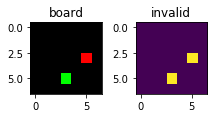

In [71]:
plot_state(state, channels_last=False)

In [72]:
state = state.transpose(1,2,0).reshape(1, BOARD_SIZE, BOARD_SIZE, 4)

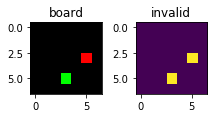

In [73]:
plot_state(state[0], channels_last=True)

### Initialization of models should be random

In [74]:
board_probs, pass_decision = actor([state.astype(np.float32), 1 - state[:,:,:,2].astype(np.float32)])

In [75]:
board_vals, pass_vals = critic([state.astype(np.float32), 1 - state[:,:,:,2].astype(np.float32)])

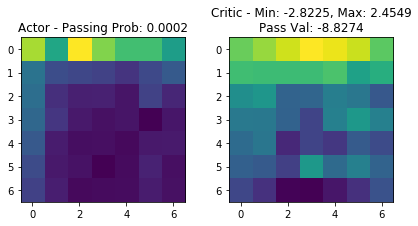

In [76]:
plt.subplot(1,2,1)
plt.title('Actor - Passing Prob: {:.4f}'.format(pass_decision[0][0]))
plt.imshow(board_probs[0])
plt.subplot(1,2,2)
plt.title('Critic - Min: {:.4f}, Max: {:.4f}\nPass Val: {:.4f}'.
          format(tf.math.reduce_min(board_vals[0]), 
                 tf.math.reduce_max(board_vals[0]), 
                 pass_vals[0][0]))
plt.imshow(board_vals[0])
plt.tight_layout()

# Training Setup

### Hyperparameters

In [20]:
NUM_EPISODES = 1000
BATCH_SIZE = 128
REPLAY_MEM_SIZE = 1024

ACTOR_LEARNING_RATE = 1e-4
OPPONENT_UPDATE = 100 

EPSILON = 1
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.01

CRITIC_LEARNING_RATE = 1e-3
GAMMA = 0.95
TARGET_UPDATE = 1 # number of episodes to update the target critic model

In [21]:
from collections import deque

In [22]:
replay_mem = deque(maxlen=int(REPLAY_MEM_SIZE))

### Metrics and Tensorboard

Metrics

In [23]:
actor_metrics = {}
for metric_key in ['loss']:
    actor_metrics[metric_key] = tf.keras.metrics.Mean('actor_{}'.format(metric_key), dtype=tf.float32)

critic_metrics = {}
for metric_key in ['loss']:
    critic_metrics[metric_key] = tf.keras.metrics.Mean('critic_{}'.format(metric_key), dtype=tf.float32)

Tensorboard

In [24]:
summary_writers = {}
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
for summary_key in ['main']:
    log_dir = 'logs/actor_critic/{}/{}'.format(current_time, summary_key)
    summary_writers[summary_key] = tf.summary.create_file_writer(log_dir)

### Functions

In [25]:
from sklearn import preprocessing
def random_weighted_action(state, pass_prob, board_weights):
    # Decide with 1 / BOARD_SIZE ** 2 chance to pass (pass if we have to)
    if np.random.uniform() < pass_prob or np.isnan(board_weights).any() or np.sum(board_weights) <= 0:
        action = None
    else:
        board_weights_sum = np.sum(board_weights)
        board_weights = tf.reshape(board_weights, (1,BOARD_SIZE**2))
        board_weights = preprocessing.normalize(board_weights, norm='l1')
        board_weights = board_weights.reshape((BOARD_SIZE**2,))
        action_1d = np.random.choice(np.arange(BOARD_SIZE**2), p=board_weights)
        action = (action_1d // BOARD_SIZE, action_1d % BOARD_SIZE)
    return action

In [26]:
def get_action(policy, state, epsilon):
    """
    Gets an action based on exploration/exploitation
    """
    epsilon_choice = np.random.uniform()
    if epsilon_choice < EPSILON:
        # Random move
        logging.debug("Exploring a random move")
        board_weights = 1 - state[2]
        action = random_weighted_action(state, 
                        pass_prob=1/BOARD_SIZE**2, 
                        board_weights=board_weights)
    else:
        # policy makes a move
        logging.debug("Exploiting policy's move")
        if state.shape[0] == 4:
            state = state.transpose(1,2,0)
        reshaped_state = state.reshape(1, BOARD_SIZE, BOARD_SIZE, 4).astype(np.float32)
        act_prob_distr, pass_decision = policy([reshaped_state, 1-reshaped_state[:,:,:,2]])
        
        action = random_weighted_action(state, pass_prob=pass_decision, 
                                        board_weights=act_prob_distr)
        
    return action

In [27]:
def get_value_for_action(board_values, passing_values, actions):
    '''
    Get value from board_values based on action, or take the passing_values if the action is None
    '''
    action_values = tf.gather_nd(board_values, [(i, a[0], a[1]) if a is not None 
                                                    else (i, 0, 0) 
                                                    for i, a in enumerate(actions)])
    action_values = tf.where([a is not None for a in actions], action_values, passing_values)
    return action_values

In [28]:
def get_batch_obs(size=BATCH_SIZE):
    '''
    Get a batch of orig_states, actions, states, rewards, terminals as np array out of replay memory
    '''
    batch = random.sample(replay_mem, size)
    batch = list(zip(*batch))
    orig_states = np.array(list(batch[0]), dtype=np.float32).transpose(0,3,2,1)
    actions = np.array(list(batch[1]))
    states = np.array(list(batch[2]), dtype=np.float32).transpose(0,3,2,1)
    rewards = np.array(list(batch[3]), dtype=np.float32)
    terminals = np.array(list(batch[4]), dtype=np.uint8)
    return orig_states, actions, states, rewards, terminals
    

In [29]:
def calculate_state_vals(states, policy, actval_func):
    '''
    Get the expected value of states
    '''
    board_prob_distrs, passing_probs = policy([states, 1-states[:,:,:,2]])
    board_val_distrs, passing_vals = actval_func([states, 1-states[:,:,:,2]])
    
    passing_probs = tf.reshape(passing_probs, (-1,))
    passing_vals = tf.reshape(passing_vals, (-1,))
    
    # state value is the expected critic value based on the actor's policy
    state_vals = tf.reduce_sum(board_prob_distrs * board_val_distrs, axis=[1,2])
    state_vals = passing_probs * passing_vals + (1 - passing_probs) * state_vals
    return state_vals

In [30]:
critic_optimizer = tf.keras.optimizers.Adam(CRITIC_LEARNING_RATE)
def update_critic():
    """
    Optimizes the critic in one step and updates the critic loss metric
    """
    
    mse = tf.keras.losses.MeanSquaredError()
    
    states, actions, next_states, rewards, terminals  = get_batch_obs()
    
    # get expected values for next state
    next_state_vals = calculate_state_vals(next_states, actor, target_critic)
    
    with tf.GradientTape() as tape:
        board_val_distrs, passing_vals = critic([states, 1-states[:,:,:,2]])
        passing_vals = tf.reshape(passing_vals, (-1,))
        action_vals = get_value_for_action(board_val_distrs, passing_vals, actions)
        val_loss = mse(rewards + GAMMA * next_state_vals * (1-terminals), action_vals)
    
    critic_metrics['loss'](val_loss)
    
    # compute and apply gradients
    gradients = tape.gradient(val_loss, critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(gradients, critic.trainable_variables))

In [31]:
actor_optimizer = tf.keras.optimizers.Adam(ACTOR_LEARNING_RATE)
def update_actor():
    """
    Optimizes the actor in one step and updates the critic loss metric
    """
    
    mse = tf.keras.losses.MeanSquaredError()
    
    states, actions, next_states, rewards, terminals = get_batch_obs()
    
    # State values
    state_vals = calculate_state_vals(states, actor, critic)
    
    # Next state values
    next_state_vals = calculate_state_vals(next_states, actor, critic)
    
    # Advantage values
    avntg_vals = (rewards + GAMMA * next_state_vals * (1-terminals)) - state_vals
    
    with tf.GradientTape() as tape:
        board_prob_distrs, passing_probs = actor([states, 1-states[:,:,:,2]])
        passing_probs = tf.reshape(passing_probs, (-1,))
        action_probs = get_value_for_action(board_prob_distrs, passing_probs, actions)
        avntg_loss = - tf.math.log(action_probs + 1e-6) * avntg_vals
        avntg_loss = tf.math.reduce_mean(avntg_loss)
    
    # log the loss in tensorboard
    actor_metrics['loss'](avntg_loss)
        
    # compute and apply gradients
    gradients = tape.gradient(avntg_loss, actor.trainable_variables)
    actor_optimizer.apply_gradients(zip(gradients, actor.trainable_variables))

In [32]:
def train(episode):
    """
    Plays out a game, and iteratively updates the models at each step
    """
    global EPSILON
    
    # Basic setup
    done = False
    num_of_turns = 0
    state = go_env.reset()
    max_steps = BOARD_SIZE**3
    rewards = []
    
    while not done and num_of_turns <= max_steps:
        # Copy state for memory
        orig_state = np.copy(state)
        
        action = get_action(actor, state, EPSILON)
        if action is None:
            logging.debug("Black (actor) passed")
            
        state, reward, done, info = go_env.step(action)
        num_of_turns += 1
        rewards.append(reward)
        
        # Add to memory
        replay_mem.append((orig_state, action, state, reward, done))
        
        # Update the critic and then actor if we have enough events
        if len(replay_mem) >= BATCH_SIZE:
            update_critic()        
            update_actor()
    
            # Update exploration/exploitation
            if EPSILON > EPSILON_MIN:
                EPSILON *= EPSILON_DECAY
                logging.debug("Epsilon decayed to {}".format(EPSILON))
            
        if done:
            break
            
        # opponent makes a move
        # swap the black and white layers
        temp = np.copy(state[0])
        state[0] = state[1]
        state[1] = temp
        # get action from opponent
        action = get_action(opponent, state, epsilon=0)
        if action is None:
            logging.debug("White (opponent) passed")

        state, reward, done, info = go_env.step(action)
        num_of_turns += 1
        rewards.append(reward)
    
    # Game ended
    return num_of_turns, rewards

# Train

In [33]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

  0%|          | 0/1000 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
I0720 17:32:44.067708 4623369664 <ipython-input-34-fc3bfac52b9e>:10] Updated opponent


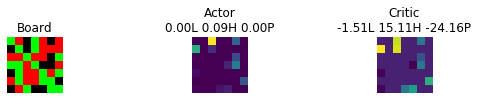

  0%|          | 1/1000 [00:13<3:49:17, 13.77s/it]

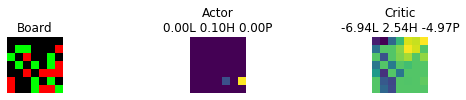

  0%|          | 2/1000 [00:52<5:53:44, 21.27s/it]

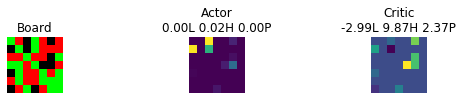

  0%|          | 3/1000 [01:31<7:20:22, 26.50s/it]

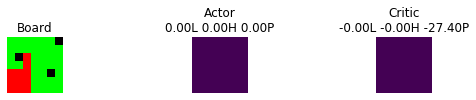

  0%|          | 4/1000 [02:09<8:20:54, 30.18s/it]

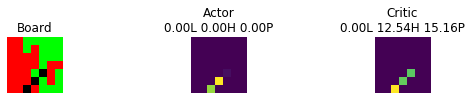

  0%|          | 5/1000 [02:48<9:01:43, 32.67s/it]

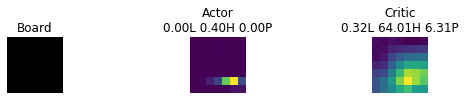

  1%|          | 6/1000 [03:29<9:40:59, 35.07s/it]

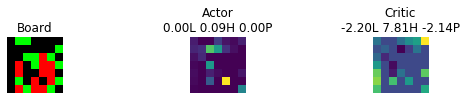

  1%|          | 7/1000 [04:09<10:08:59, 36.80s/it]

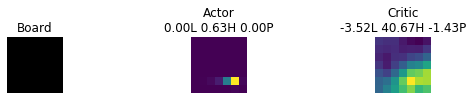

  1%|          | 8/1000 [04:19<7:51:31, 28.52s/it] 

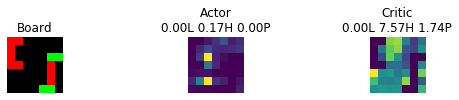

  1%|          | 9/1000 [04:31<6:30:09, 23.62s/it]

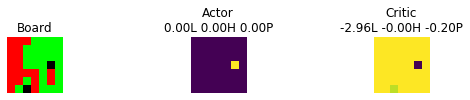

  1%|          | 10/1000 [04:44<5:39:34, 20.58s/it]

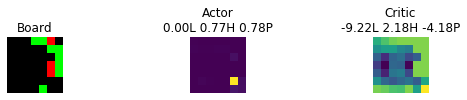

  1%|          | 11/1000 [05:24<7:15:33, 26.42s/it]

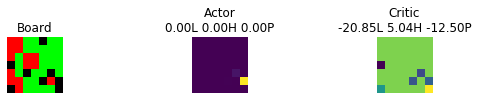

  1%|          | 12/1000 [05:42<6:29:41, 23.67s/it]

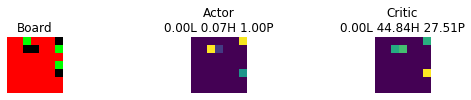

  1%|▏         | 13/1000 [06:08<6:43:39, 24.54s/it]

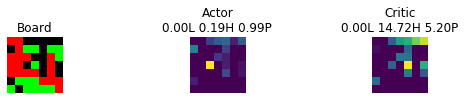

  1%|▏         | 14/1000 [06:48<7:57:42, 29.07s/it]

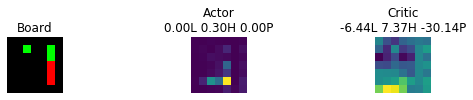

  2%|▏         | 15/1000 [07:00<6:33:14, 23.95s/it]

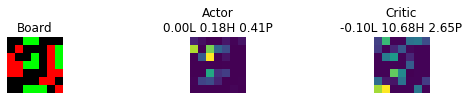

  2%|▏         | 16/1000 [07:36<7:32:06, 27.57s/it]

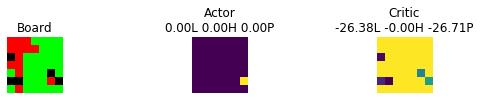

  2%|▏         | 17/1000 [07:51<6:29:00, 23.74s/it]

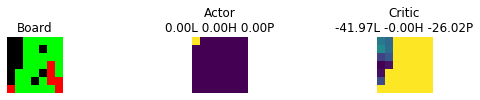

  2%|▏         | 18/1000 [08:10<6:05:56, 22.36s/it]

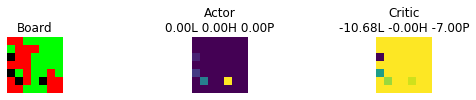

  2%|▏         | 19/1000 [08:29<5:52:09, 21.54s/it]

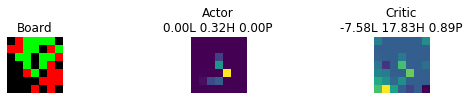

  2%|▏         | 20/1000 [08:42<5:05:18, 18.69s/it]

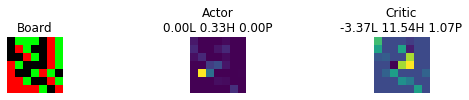

  2%|▏         | 21/1000 [08:53<4:32:03, 16.67s/it]

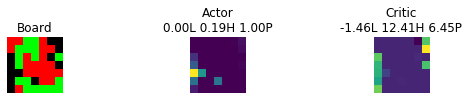

  2%|▏         | 22/1000 [09:09<4:24:35, 16.23s/it]

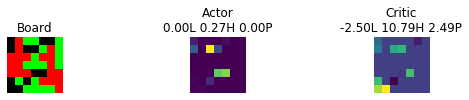

  2%|▏         | 23/1000 [09:19<3:54:02, 14.37s/it]

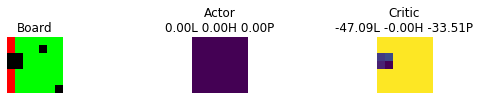

  2%|▏         | 24/1000 [09:40<4:26:54, 16.41s/it]

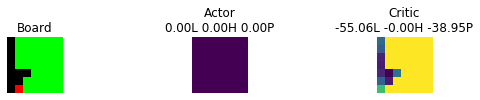

  2%|▎         | 25/1000 [09:48<3:46:01, 13.91s/it]

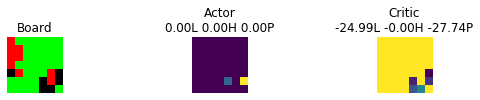

  3%|▎         | 26/1000 [10:06<4:04:02, 15.03s/it]

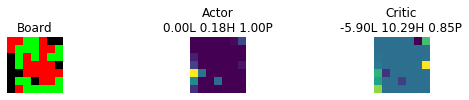

  3%|▎         | 27/1000 [10:37<5:24:35, 20.02s/it]

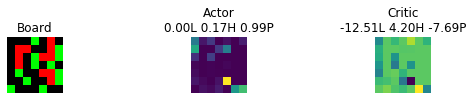

  3%|▎         | 28/1000 [11:01<5:42:49, 21.16s/it]

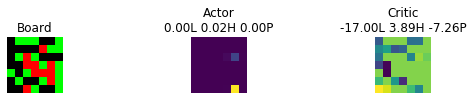

  3%|▎         | 29/1000 [11:21<5:37:56, 20.88s/it]

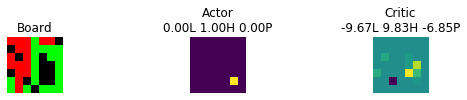

  3%|▎         | 30/1000 [11:33<4:52:31, 18.09s/it]

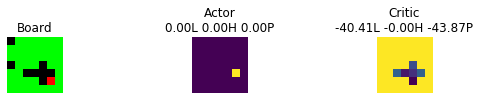

  3%|▎         | 31/1000 [11:45<4:22:59, 16.28s/it]

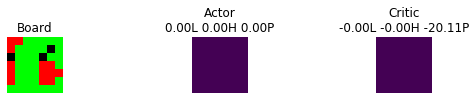

  3%|▎         | 32/1000 [11:58<4:07:17, 15.33s/it]

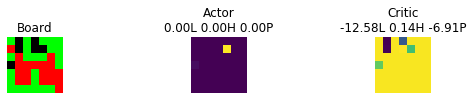

  3%|▎         | 33/1000 [12:19<4:34:05, 17.01s/it]

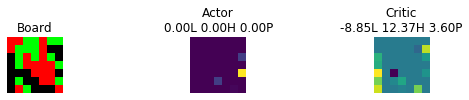

  3%|▎         | 34/1000 [12:32<4:15:09, 15.85s/it]

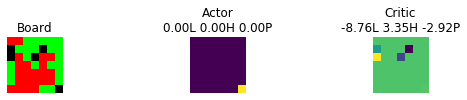

  4%|▎         | 35/1000 [13:05<5:38:05, 21.02s/it]

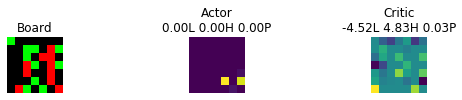

  4%|▎         | 36/1000 [13:23<5:23:53, 20.16s/it]

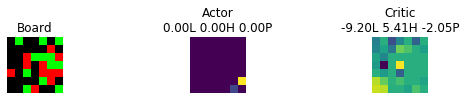

  4%|▎         | 37/1000 [13:36<4:47:38, 17.92s/it]

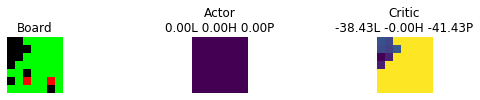

  4%|▍         | 38/1000 [13:59<5:13:21, 19.54s/it]

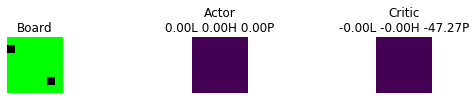

  4%|▍         | 39/1000 [14:12<4:39:00, 17.42s/it]

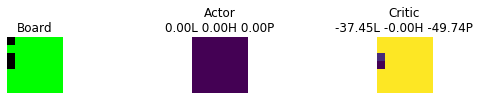

  4%|▍         | 40/1000 [14:30<4:44:28, 17.78s/it]

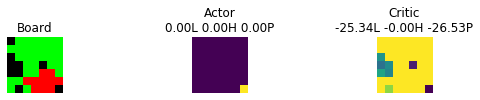

  4%|▍         | 41/1000 [14:54<5:12:33, 19.56s/it]

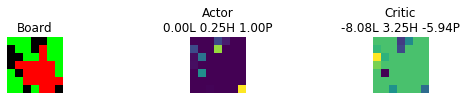

  4%|▍         | 42/1000 [15:12<5:02:21, 18.94s/it]

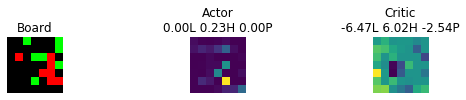

  4%|▍         | 43/1000 [15:23<4:26:56, 16.74s/it]

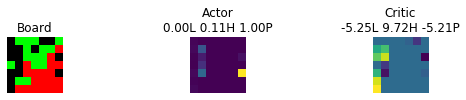

  4%|▍         | 44/1000 [15:36<4:05:08, 15.39s/it]

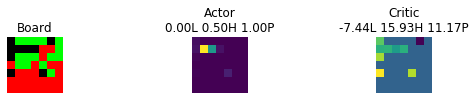

  4%|▍         | 45/1000 [15:52<4:08:13, 15.59s/it]

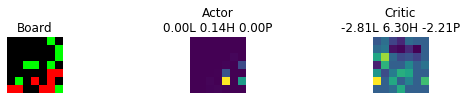

  5%|▍         | 46/1000 [16:09<4:18:32, 16.26s/it]

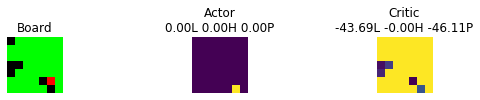

  5%|▍         | 47/1000 [16:22<3:59:03, 15.05s/it]

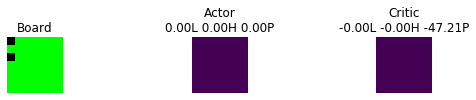

  5%|▍         | 48/1000 [16:34<3:44:20, 14.14s/it]

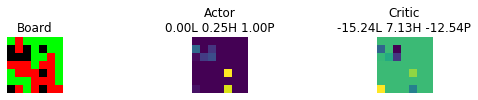

  5%|▍         | 49/1000 [17:01<4:44:36, 17.96s/it]

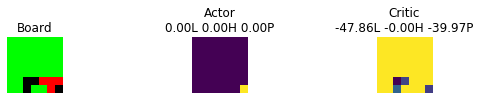

  5%|▌         | 50/1000 [17:12<4:13:46, 16.03s/it]

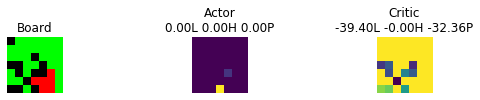

  5%|▌         | 51/1000 [17:24<3:52:17, 14.69s/it]

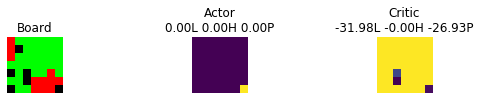

  5%|▌         | 52/1000 [17:42<4:08:22, 15.72s/it]

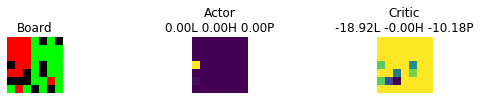

  5%|▌         | 53/1000 [17:54<3:53:04, 14.77s/it]

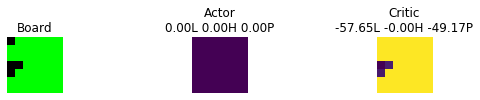

  5%|▌         | 54/1000 [18:06<3:37:06, 13.77s/it]

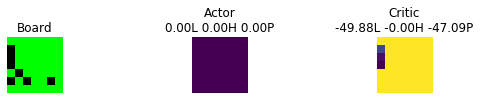

  6%|▌         | 55/1000 [18:23<3:52:41, 14.77s/it]

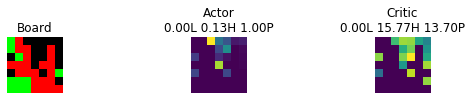

  6%|▌         | 56/1000 [18:35<3:41:38, 14.09s/it]

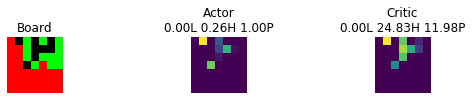

  6%|▌         | 57/1000 [18:46<3:27:14, 13.19s/it]

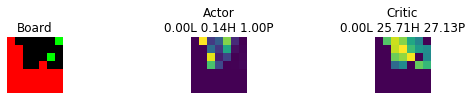

  6%|▌         | 58/1000 [18:58<3:18:17, 12.63s/it]

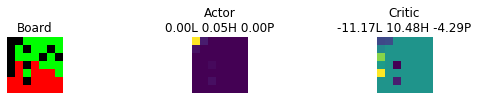

  6%|▌         | 59/1000 [19:23<4:19:44, 16.56s/it]

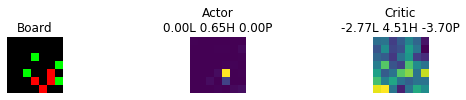

  6%|▌         | 60/1000 [19:36<4:02:35, 15.48s/it]

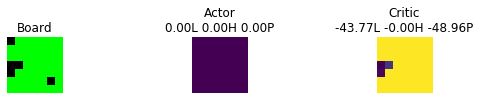

  6%|▌         | 61/1000 [19:50<3:52:16, 14.84s/it]

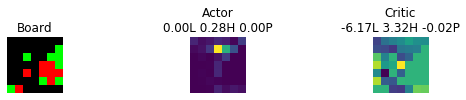

  6%|▌         | 62/1000 [20:04<3:48:56, 14.64s/it]

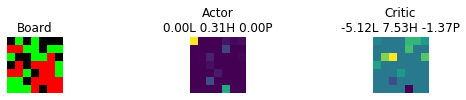

  6%|▋         | 63/1000 [20:33<4:55:14, 18.91s/it]

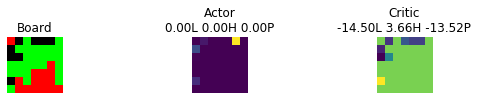

  6%|▋         | 64/1000 [21:05<5:57:39, 22.93s/it]

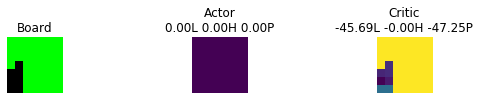

  6%|▋         | 65/1000 [21:24<5:39:53, 21.81s/it]

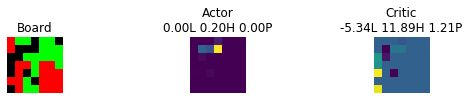

  7%|▋         | 66/1000 [21:35<4:48:34, 18.54s/it]

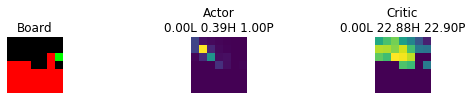

  7%|▋         | 67/1000 [21:48<4:23:15, 16.93s/it]

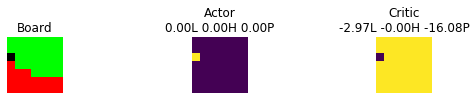

  7%|▋         | 68/1000 [22:10<4:44:29, 18.31s/it]

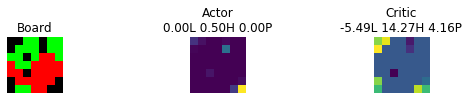

  7%|▋         | 69/1000 [22:21<4:12:28, 16.27s/it]

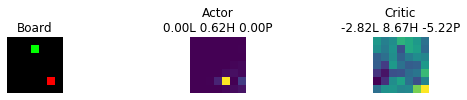

  7%|▋         | 70/1000 [22:33<3:50:04, 14.84s/it]

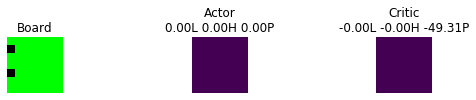

  7%|▋         | 71/1000 [22:45<3:35:45, 13.93s/it]

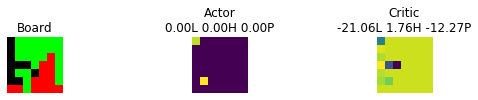

  7%|▋         | 72/1000 [23:10<4:26:20, 17.22s/it]

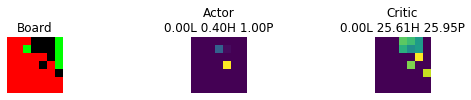

  7%|▋         | 73/1000 [23:34<4:59:34, 19.39s/it]

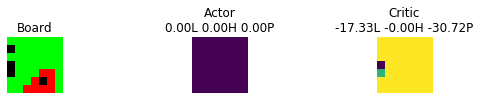

  7%|▋         | 74/1000 [23:47<4:29:22, 17.45s/it]

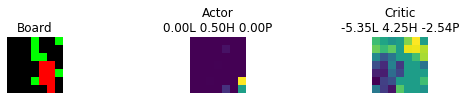

  8%|▊         | 75/1000 [24:05<4:31:03, 17.58s/it]

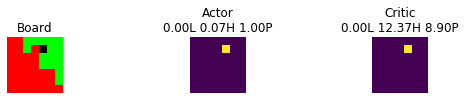

  8%|▊         | 76/1000 [24:30<5:07:37, 19.98s/it]

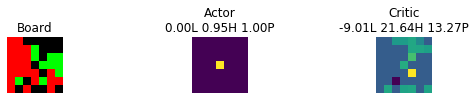

  8%|▊         | 77/1000 [25:03<6:07:19, 23.88s/it]

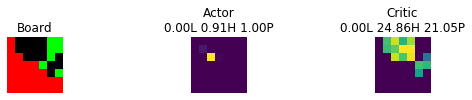

  8%|▊         | 78/1000 [25:16<5:15:35, 20.54s/it]

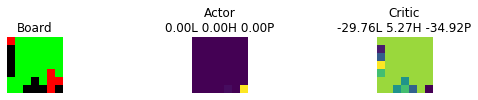

  8%|▊         | 79/1000 [25:40<5:29:24, 21.46s/it]

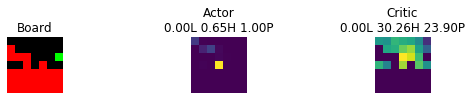

  8%|▊         | 80/1000 [25:52<4:45:17, 18.61s/it]

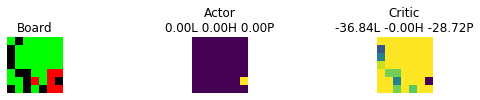

  8%|▊         | 81/1000 [26:10<4:43:22, 18.50s/it]

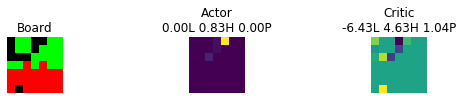

  8%|▊         | 82/1000 [26:34<5:09:10, 20.21s/it]

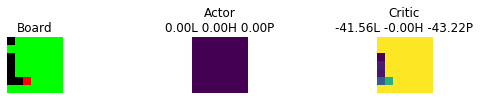

  8%|▊         | 83/1000 [27:01<5:38:03, 22.12s/it]

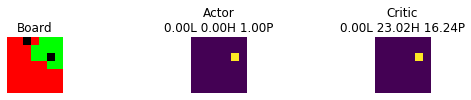

  8%|▊         | 84/1000 [27:13<4:54:16, 19.28s/it]

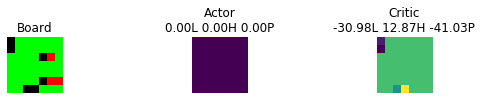

  8%|▊         | 85/1000 [27:31<4:45:13, 18.70s/it]

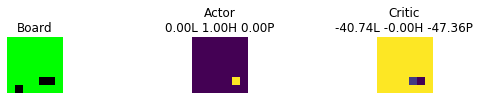

  9%|▊         | 86/1000 [27:55<5:08:29, 20.25s/it]

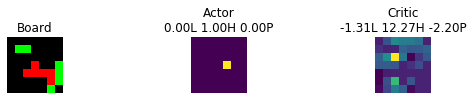

  9%|▊         | 87/1000 [28:08<4:36:17, 18.16s/it]

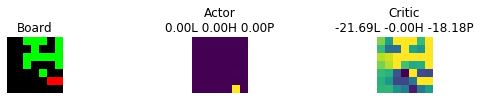

  9%|▉         | 88/1000 [28:27<4:38:59, 18.36s/it]

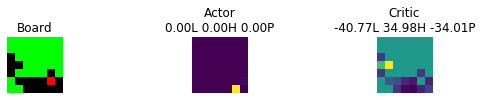

  9%|▉         | 89/1000 [28:39<4:12:49, 16.65s/it]

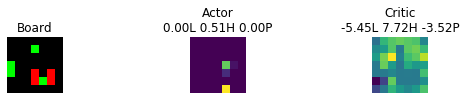

  9%|▉         | 90/1000 [28:52<3:53:45, 15.41s/it]

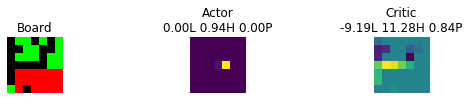

  9%|▉         | 91/1000 [29:05<3:41:21, 14.61s/it]

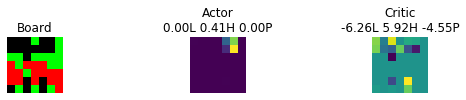

  9%|▉         | 92/1000 [29:30<4:30:30, 17.87s/it]

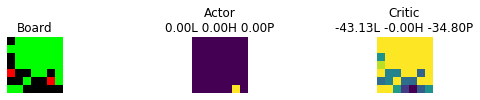

  9%|▉         | 93/1000 [30:07<5:54:31, 23.45s/it]

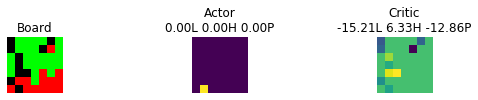

  9%|▉         | 94/1000 [30:18<5:00:44, 19.92s/it]

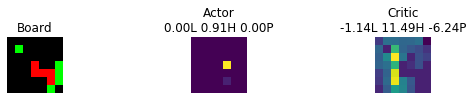

 10%|▉         | 95/1000 [30:31<4:27:17, 17.72s/it]

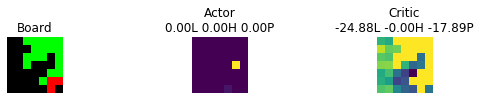

 10%|▉         | 96/1000 [30:44<4:04:04, 16.20s/it]

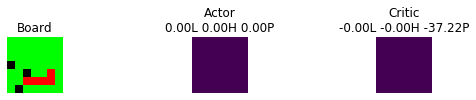

 10%|▉         | 97/1000 [30:55<3:41:48, 14.74s/it]

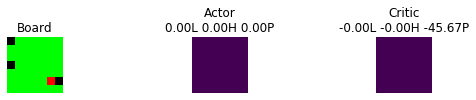

 10%|▉         | 98/1000 [31:28<5:05:26, 20.32s/it]

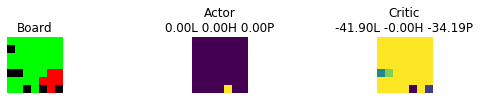

 10%|▉         | 99/1000 [31:41<4:29:56, 17.98s/it]

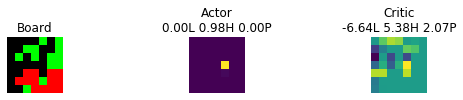

 10%|█         | 100/1000 [31:53<4:04:58, 16.33s/it]I0720 18:04:37.680295 4623369664 <ipython-input-34-fc3bfac52b9e>:10] Updated opponent


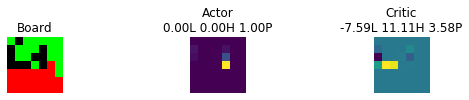

 10%|█         | 101/1000 [32:28<5:25:52, 21.75s/it]

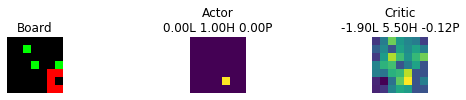

 10%|█         | 102/1000 [33:06<6:40:32, 26.76s/it]

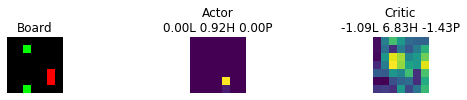

 10%|█         | 103/1000 [33:27<6:15:12, 25.10s/it]

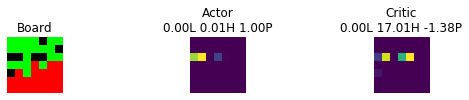

 10%|█         | 104/1000 [34:06<7:14:41, 29.11s/it]

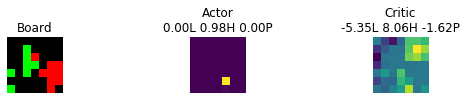

 10%|█         | 105/1000 [34:44<7:54:51, 31.83s/it]

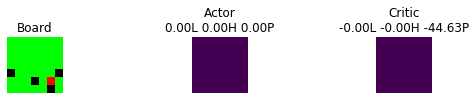

 11%|█         | 106/1000 [35:23<8:24:27, 33.86s/it]

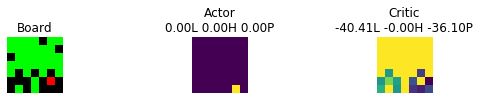

 11%|█         | 107/1000 [36:02<8:47:04, 35.41s/it]

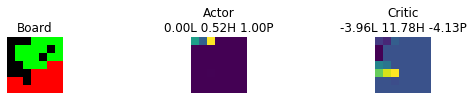

 11%|█         | 108/1000 [36:36<8:42:23, 35.14s/it]

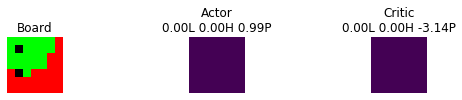

 11%|█         | 109/1000 [36:47<6:56:04, 28.02s/it]

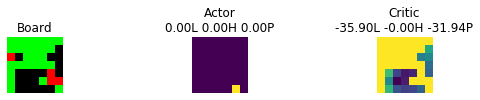

 11%|█         | 110/1000 [36:58<5:37:36, 22.76s/it]

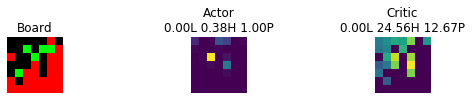

 11%|█         | 111/1000 [37:09<4:43:32, 19.14s/it]

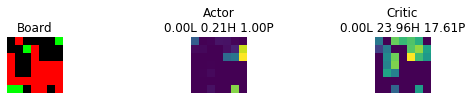

 11%|█         | 112/1000 [37:28<4:42:38, 19.10s/it]

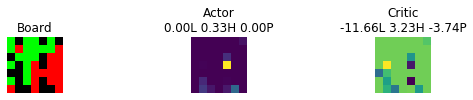

 11%|█▏        | 113/1000 [37:39<4:07:20, 16.73s/it]

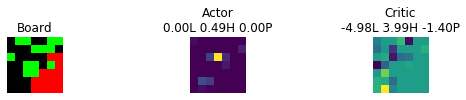

 11%|█▏        | 114/1000 [38:06<4:55:12, 19.99s/it]

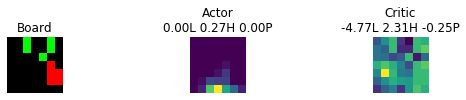

 12%|█▏        | 115/1000 [38:18<4:18:14, 17.51s/it]

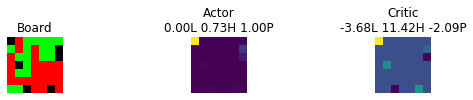

 12%|█▏        | 116/1000 [38:35<4:13:02, 17.18s/it]

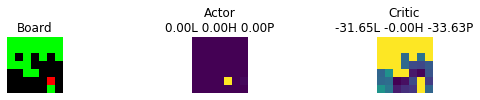

 12%|█▏        | 117/1000 [39:13<5:47:17, 23.60s/it]

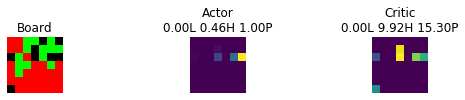

 12%|█▏        | 118/1000 [39:31<5:21:41, 21.88s/it]

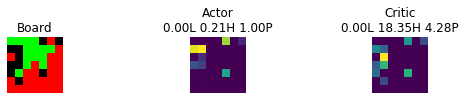

 12%|█▏        | 119/1000 [40:10<6:34:53, 26.89s/it]

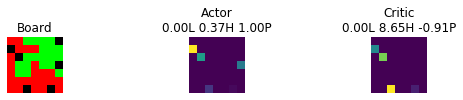

 12%|█▏        | 120/1000 [40:21<5:27:32, 22.33s/it]

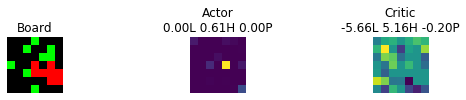

 12%|█▏        | 121/1000 [41:00<6:39:11, 27.25s/it]

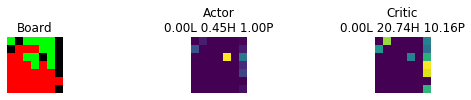

 12%|█▏        | 122/1000 [41:29<6:47:19, 27.84s/it]

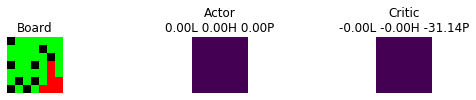

 12%|█▏        | 123/1000 [42:08<7:34:23, 31.09s/it]

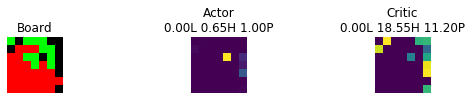

 12%|█▏        | 124/1000 [42:46<8:06:34, 33.33s/it]

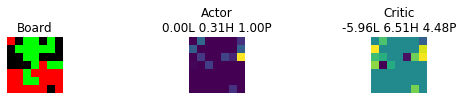

 12%|█▎        | 125/1000 [42:58<6:28:50, 26.66s/it]

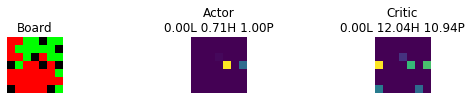

 13%|█▎        | 126/1000 [43:31<6:59:23, 28.79s/it]

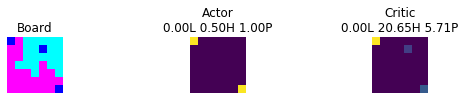

 13%|█▎        | 127/1000 [43:59<6:55:08, 28.53s/it]

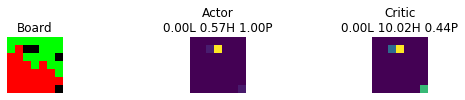

 13%|█▎        | 128/1000 [44:11<5:40:54, 23.46s/it]

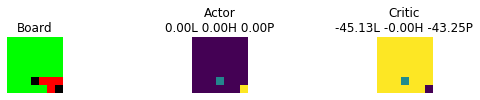

 13%|█▎        | 129/1000 [44:47<6:34:40, 27.19s/it]

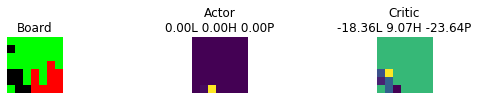

 13%|█▎        | 130/1000 [45:26<7:24:25, 30.65s/it]

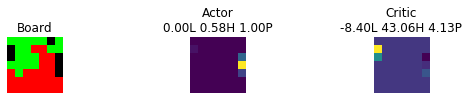

 13%|█▎        | 131/1000 [45:55<7:20:18, 30.40s/it]

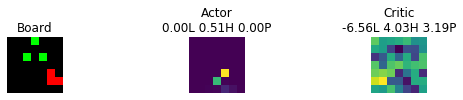

 13%|█▎        | 132/1000 [46:14<6:26:54, 26.75s/it]

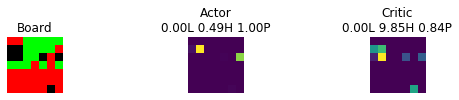

 13%|█▎        | 133/1000 [46:55<7:28:49, 31.06s/it]

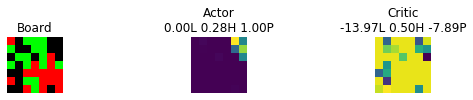

 13%|█▎        | 134/1000 [47:34<8:03:11, 33.48s/it]

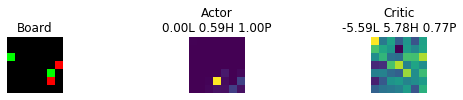

 14%|█▎        | 135/1000 [48:13<8:28:04, 35.24s/it]

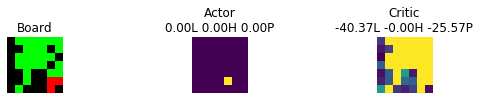

 14%|█▎        | 136/1000 [48:41<7:56:12, 33.07s/it]

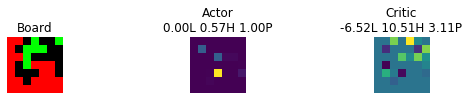

 14%|█▎        | 137/1000 [49:20<8:21:07, 34.84s/it]

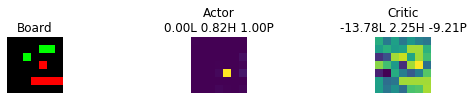

 14%|█▍        | 138/1000 [49:32<6:40:30, 27.88s/it]

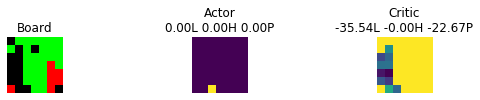

 14%|█▍        | 139/1000 [50:10<7:26:18, 31.10s/it]

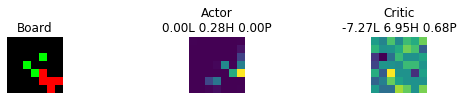

 14%|█▍        | 140/1000 [50:50<8:00:59, 33.56s/it]

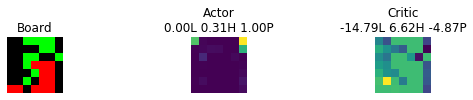

 14%|█▍        | 141/1000 [51:29<8:24:26, 35.23s/it]

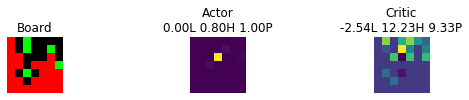

 14%|█▍        | 142/1000 [51:52<7:33:30, 31.71s/it]

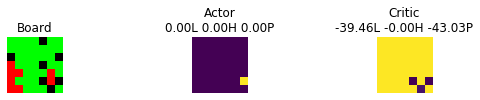

 14%|█▍        | 143/1000 [52:26<7:39:33, 32.17s/it]

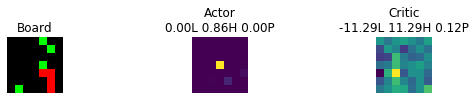

 14%|█▍        | 144/1000 [52:37<6:10:39, 25.98s/it]

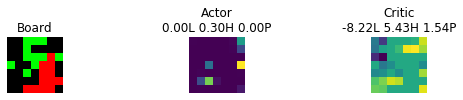

 14%|█▍        | 145/1000 [53:16<7:05:54, 29.89s/it]

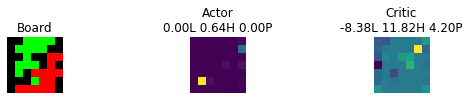

 15%|█▍        | 146/1000 [53:55<7:42:43, 32.51s/it]

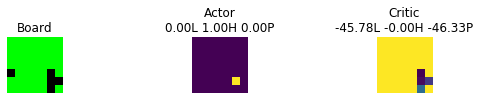

 15%|█▍        | 147/1000 [54:34<8:08:53, 34.39s/it]

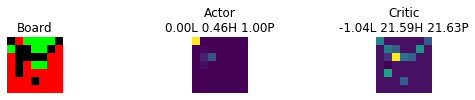

 15%|█▍        | 148/1000 [55:04<7:52:14, 33.26s/it]

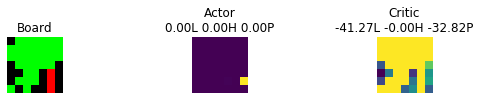

 15%|█▍        | 149/1000 [55:29<7:15:02, 30.67s/it]

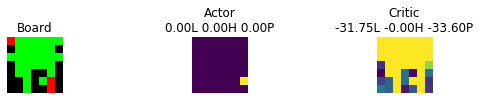

 15%|█▌        | 150/1000 [56:07<7:45:46, 32.88s/it]

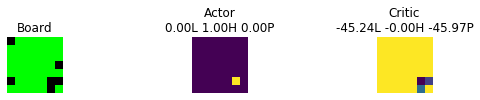

 15%|█▌        | 151/1000 [56:46<8:10:16, 34.65s/it]

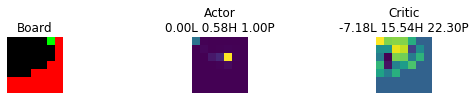

 15%|█▌        | 152/1000 [57:25<8:27:58, 35.94s/it]

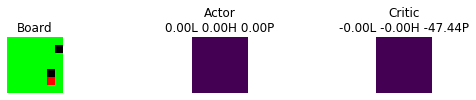

 15%|█▌        | 153/1000 [58:03<8:38:49, 36.75s/it]

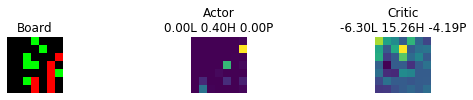

 15%|█▌        | 154/1000 [58:42<8:45:39, 37.28s/it]

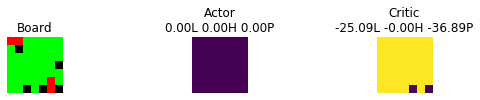

 16%|█▌        | 155/1000 [59:20<8:51:22, 37.73s/it]

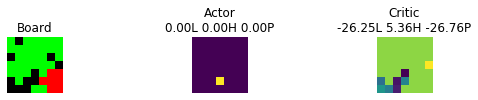

 16%|█▌        | 156/1000 [59:59<8:55:26, 38.06s/it]

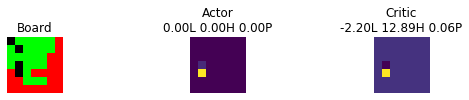

 16%|█▌        | 157/1000 [1:00:11<7:04:17, 30.20s/it]

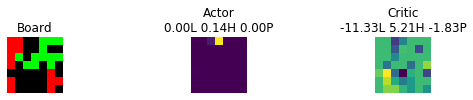

 16%|█▌        | 158/1000 [1:00:22<5:43:26, 24.47s/it]

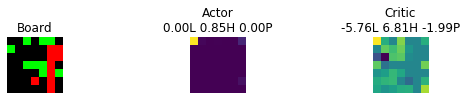

 16%|█▌        | 159/1000 [1:01:02<6:46:38, 29.01s/it]

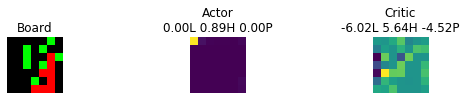

 16%|█▌        | 160/1000 [1:01:13<5:32:46, 23.77s/it]

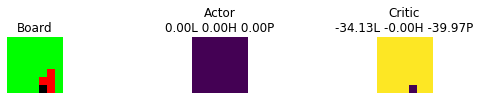

 16%|█▌        | 161/1000 [1:01:35<5:24:21, 23.20s/it]

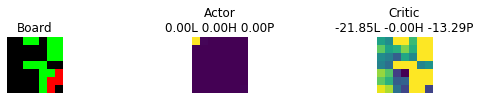

 16%|█▌        | 162/1000 [1:01:53<5:00:19, 21.50s/it]

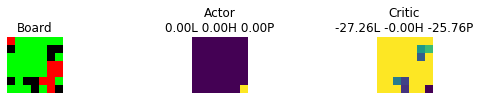

 16%|█▋        | 163/1000 [1:02:05<4:19:27, 18.60s/it]

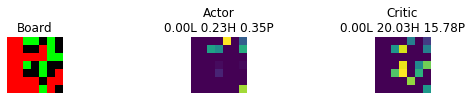

 16%|█▋        | 164/1000 [1:02:16<3:49:50, 16.50s/it]

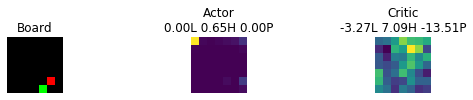

 16%|█▋        | 165/1000 [1:02:38<4:12:12, 18.12s/it]

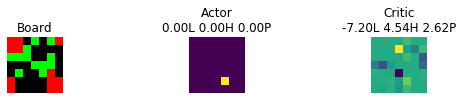

 17%|█▋        | 166/1000 [1:03:00<4:28:18, 19.30s/it]

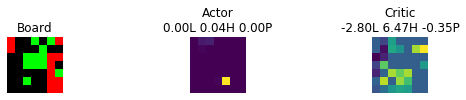

 17%|█▋        | 167/1000 [1:03:39<5:49:14, 25.16s/it]

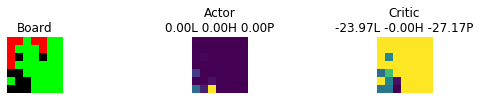

 17%|█▋        | 168/1000 [1:04:01<5:36:21, 24.26s/it]

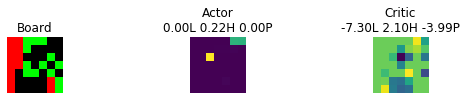

 17%|█▋        | 169/1000 [1:04:13<4:44:29, 20.54s/it]

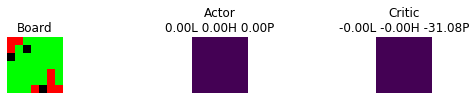

 17%|█▋        | 170/1000 [1:04:36<4:52:38, 21.15s/it]

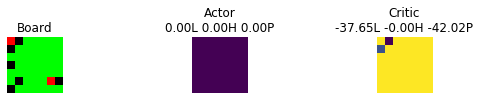

 17%|█▋        | 171/1000 [1:04:57<4:54:58, 21.35s/it]

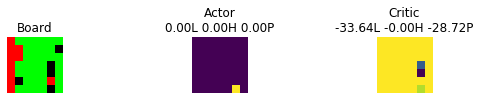

 17%|█▋        | 172/1000 [1:05:25<5:21:39, 23.31s/it]

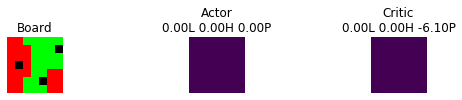

 17%|█▋        | 173/1000 [1:05:37<4:32:14, 19.75s/it]

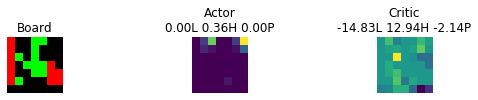

 17%|█▋        | 174/1000 [1:06:16<5:50:55, 25.49s/it]

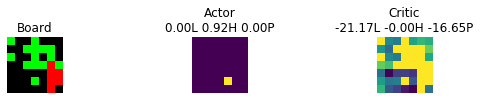

 18%|█▊        | 175/1000 [1:06:27<4:53:47, 21.37s/it]

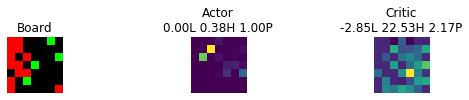

 18%|█▊        | 176/1000 [1:07:07<6:07:10, 26.74s/it]

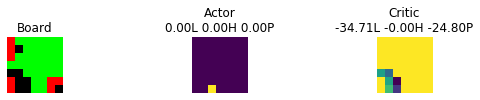

 18%|█▊        | 177/1000 [1:07:30<5:51:34, 25.63s/it]

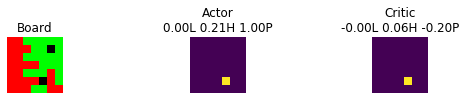

 18%|█▊        | 178/1000 [1:07:53<5:40:49, 24.88s/it]

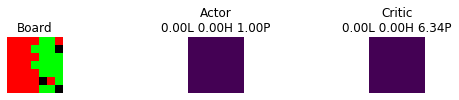

 18%|█▊        | 179/1000 [1:08:32<6:37:09, 29.03s/it]

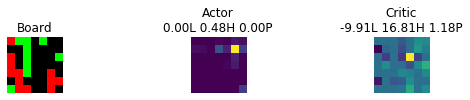

 18%|█▊        | 180/1000 [1:09:00<6:35:03, 28.91s/it]

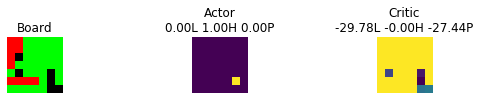

 18%|█▊        | 181/1000 [1:09:36<7:02:35, 30.96s/it]

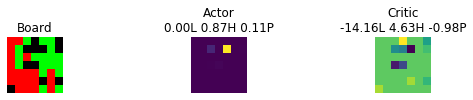

 18%|█▊        | 182/1000 [1:10:15<7:33:43, 33.28s/it]

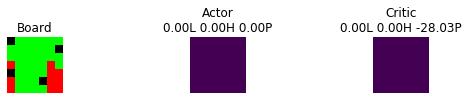

 18%|█▊        | 183/1000 [1:10:26<6:03:07, 26.67s/it]

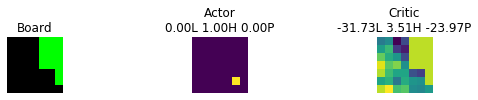

 18%|█▊        | 184/1000 [1:10:37<4:59:43, 22.04s/it]

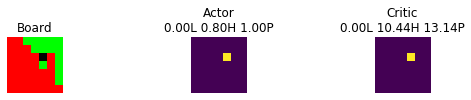

 18%|█▊        | 185/1000 [1:10:56<4:48:25, 21.23s/it]

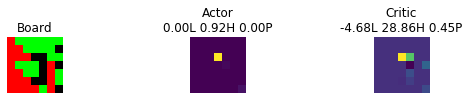

 19%|█▊        | 186/1000 [1:11:20<4:58:40, 22.02s/it]

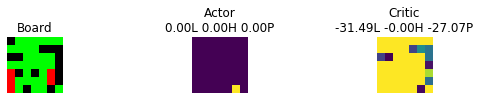

 19%|█▊        | 187/1000 [1:11:32<4:17:04, 18.97s/it]

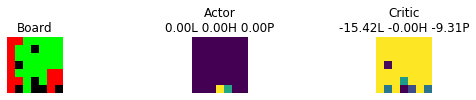

 19%|█▉        | 188/1000 [1:12:04<5:10:22, 22.93s/it]

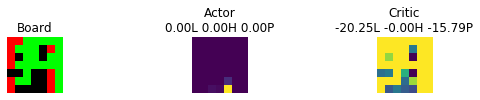

 19%|█▉        | 189/1000 [1:12:37<5:47:27, 25.71s/it]

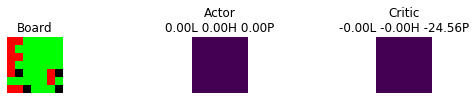

 19%|█▉        | 190/1000 [1:12:54<5:14:32, 23.30s/it]

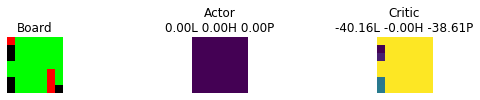

 19%|█▉        | 191/1000 [1:13:33<6:16:55, 27.96s/it]

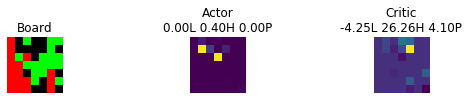

 19%|█▉        | 192/1000 [1:14:06<6:36:23, 29.43s/it]

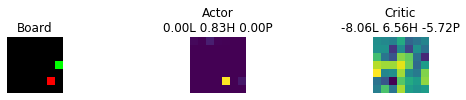

 19%|█▉        | 193/1000 [1:14:30<6:12:59, 27.73s/it]

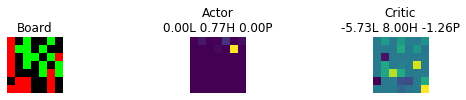

 19%|█▉        | 194/1000 [1:14:41<5:08:25, 22.96s/it]

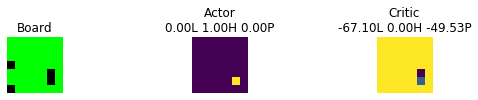

 20%|█▉        | 195/1000 [1:15:20<6:11:48, 27.71s/it]

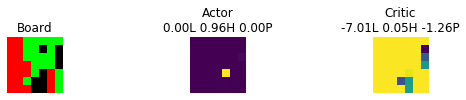

 20%|█▉        | 196/1000 [1:15:32<5:05:16, 22.78s/it]

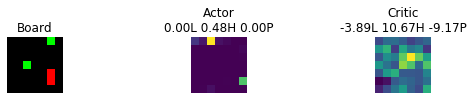

 20%|█▉        | 197/1000 [1:15:43<4:21:05, 19.51s/it]

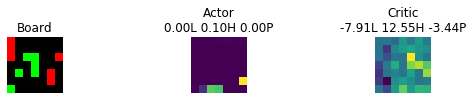

 20%|█▉        | 198/1000 [1:16:06<4:31:26, 20.31s/it]

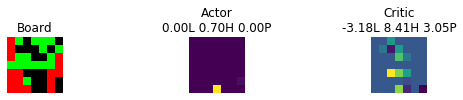

 20%|█▉        | 199/1000 [1:16:40<5:26:38, 24.47s/it]

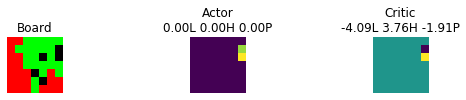

 20%|██        | 200/1000 [1:17:02<5:18:20, 23.88s/it]I0720 18:49:46.733001 4623369664 <ipython-input-34-fc3bfac52b9e>:10] Updated opponent


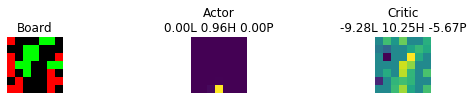

 20%|██        | 201/1000 [1:17:17<4:42:32, 21.22s/it]

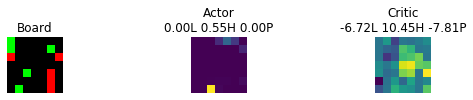

 20%|██        | 202/1000 [1:17:31<4:12:56, 19.02s/it]

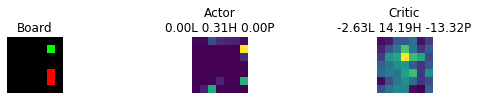

 20%|██        | 203/1000 [1:17:43<3:44:27, 16.90s/it]

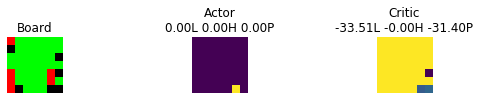

 20%|██        | 204/1000 [1:18:04<4:00:11, 18.10s/it]

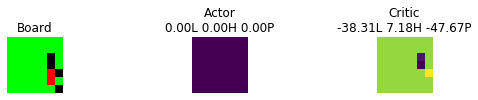

 20%|██        | 205/1000 [1:18:16<3:35:46, 16.28s/it]

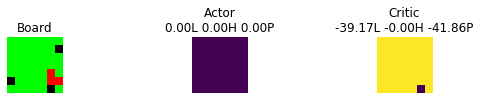

 21%|██        | 206/1000 [1:18:55<5:03:51, 22.96s/it]

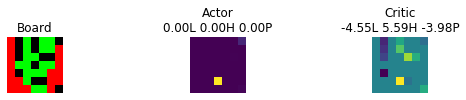

 21%|██        | 207/1000 [1:19:07<4:21:49, 19.81s/it]

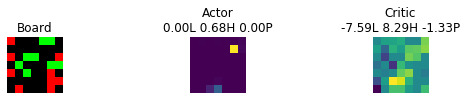

 21%|██        | 208/1000 [1:19:17<3:41:37, 16.79s/it]

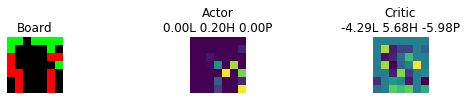

 21%|██        | 209/1000 [1:19:28<3:18:21, 15.05s/it]

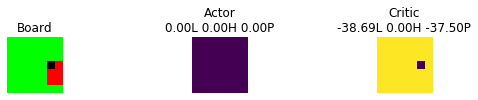

 21%|██        | 210/1000 [1:19:42<3:13:30, 14.70s/it]

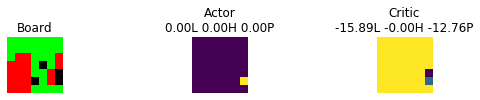

 21%|██        | 211/1000 [1:19:52<2:54:10, 13.25s/it]

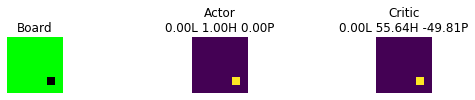

 21%|██        | 212/1000 [1:20:14<3:29:56, 15.99s/it]

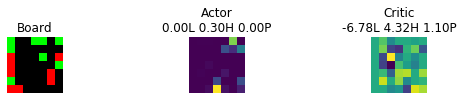

 21%|██▏       | 213/1000 [1:20:32<3:39:32, 16.74s/it]

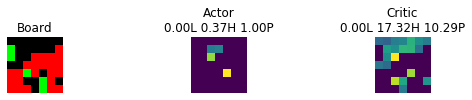

 21%|██▏       | 214/1000 [1:20:59<4:16:49, 19.60s/it]

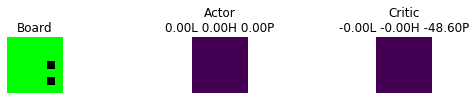

 22%|██▏       | 215/1000 [1:21:20<4:23:12, 20.12s/it]

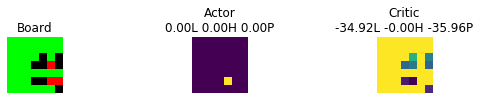

 22%|██▏       | 216/1000 [1:21:28<3:33:56, 16.37s/it]

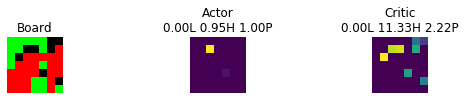

 22%|██▏       | 217/1000 [1:21:40<3:17:49, 15.16s/it]

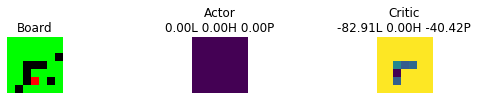

 22%|██▏       | 218/1000 [1:21:46<2:42:02, 12.43s/it]

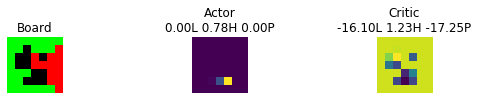

 22%|██▏       | 219/1000 [1:22:07<3:15:22, 15.01s/it]

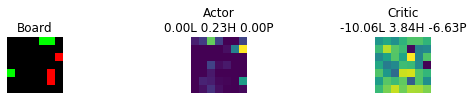

 22%|██▏       | 220/1000 [1:22:19<3:01:23, 13.95s/it]

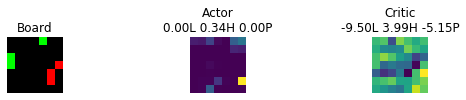

 22%|██▏       | 221/1000 [1:22:52<4:17:22, 19.82s/it]

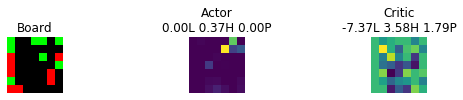

 22%|██▏       | 222/1000 [1:23:09<4:05:16, 18.92s/it]

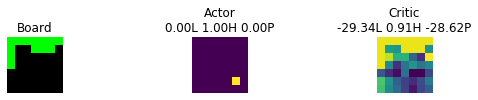

 22%|██▏       | 223/1000 [1:23:40<4:54:08, 22.71s/it]

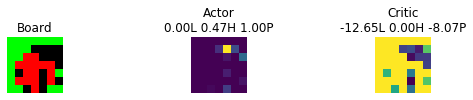

 22%|██▏       | 224/1000 [1:23:51<4:05:16, 18.96s/it]

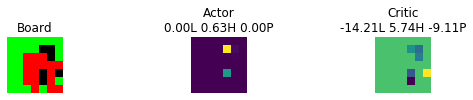

 22%|██▎       | 225/1000 [1:24:24<5:00:20, 23.25s/it]

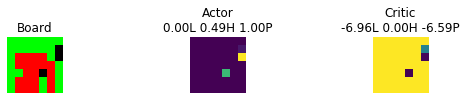

 23%|██▎       | 226/1000 [1:25:00<5:48:44, 27.03s/it]

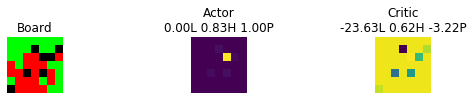

 23%|██▎       | 227/1000 [1:25:12<4:51:06, 22.60s/it]

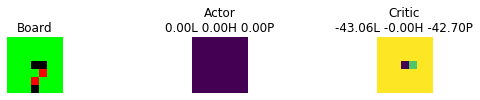

 23%|██▎       | 228/1000 [1:25:28<4:24:16, 20.54s/it]

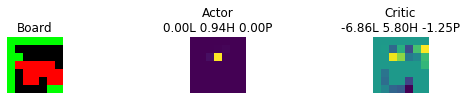

 23%|██▎       | 229/1000 [1:25:38<3:45:45, 17.57s/it]

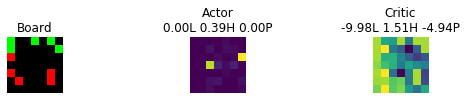

 23%|██▎       | 230/1000 [1:25:49<3:19:26, 15.54s/it]

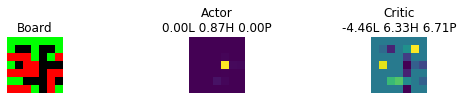

 23%|██▎       | 231/1000 [1:26:02<3:08:32, 14.71s/it]

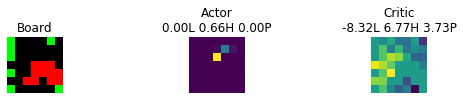

 23%|██▎       | 232/1000 [1:26:41<4:40:47, 21.94s/it]

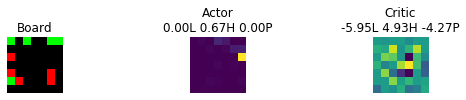

 23%|██▎       | 233/1000 [1:26:53<4:02:40, 18.98s/it]

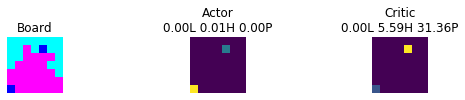

 23%|██▎       | 234/1000 [1:27:05<3:37:23, 17.03s/it]

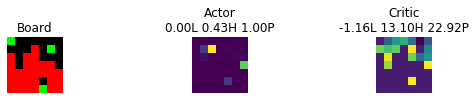

 24%|██▎       | 235/1000 [1:27:16<3:13:57, 15.21s/it]

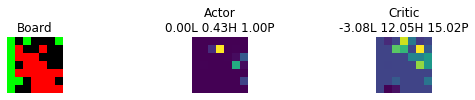

 24%|██▎       | 236/1000 [1:27:31<3:10:00, 14.92s/it]

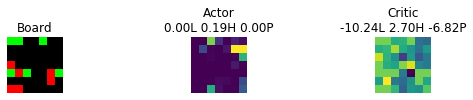

 24%|██▎       | 237/1000 [1:27:40<2:48:55, 13.28s/it]

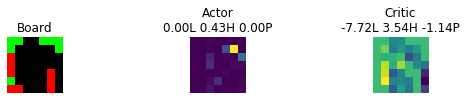

 24%|██▍       | 238/1000 [1:27:58<3:07:12, 14.74s/it]

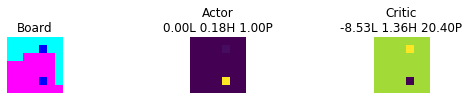

 24%|██▍       | 239/1000 [1:28:04<2:34:54, 12.21s/it]

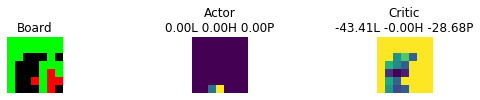

 24%|██▍       | 240/1000 [1:28:15<2:29:49, 11.83s/it]

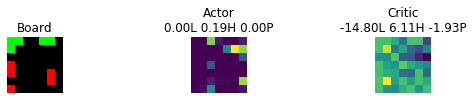

 24%|██▍       | 241/1000 [1:28:30<2:39:11, 12.58s/it]

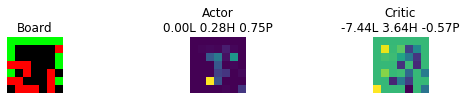

 24%|██▍       | 242/1000 [1:28:36<2:16:20, 10.79s/it]

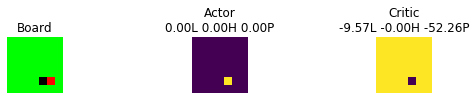

 24%|██▍       | 243/1000 [1:28:49<2:24:47, 11.48s/it]

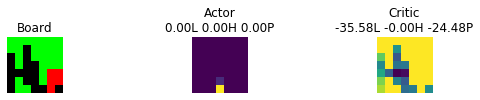

 24%|██▍       | 244/1000 [1:29:01<2:26:07, 11.60s/it]

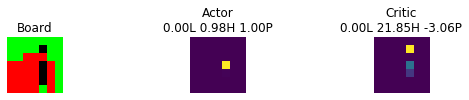

 24%|██▍       | 245/1000 [1:29:19<2:48:21, 13.38s/it]

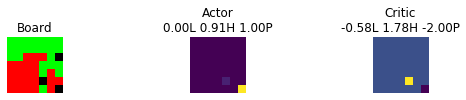

 25%|██▍       | 246/1000 [1:29:30<2:38:03, 12.58s/it]

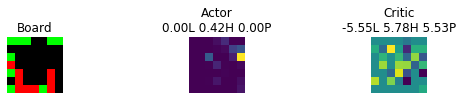

 25%|██▍       | 247/1000 [1:29:53<3:19:31, 15.90s/it]

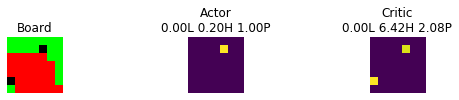

 25%|██▍       | 248/1000 [1:30:04<3:01:27, 14.48s/it]

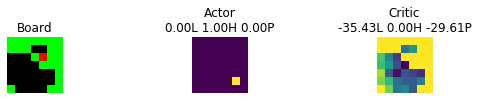

 25%|██▍       | 249/1000 [1:30:11<2:32:05, 12.15s/it]

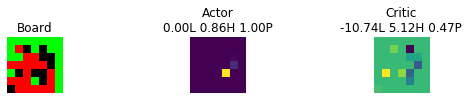

 25%|██▌       | 250/1000 [1:30:21<2:21:39, 11.33s/it]

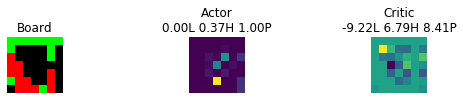

 25%|██▌       | 251/1000 [1:30:31<2:16:32, 10.94s/it]

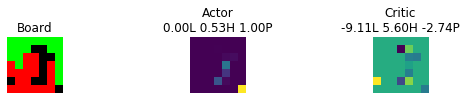

 25%|██▌       | 252/1000 [1:30:37<1:58:17,  9.49s/it]

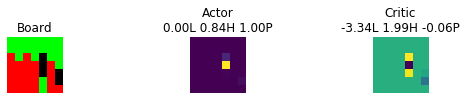

 25%|██▌       | 253/1000 [1:30:43<1:45:41,  8.49s/it]

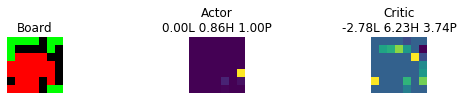

 25%|██▌       | 254/1000 [1:31:05<2:35:46, 12.53s/it]

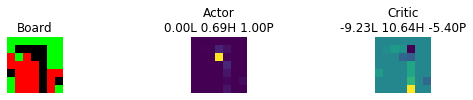

 26%|██▌       | 255/1000 [1:31:17<2:33:00, 12.32s/it]

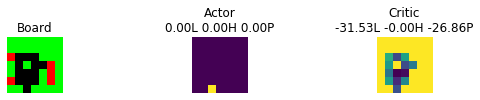

 26%|██▌       | 256/1000 [1:31:28<2:27:44, 11.91s/it]

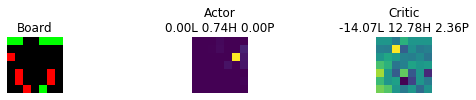

 26%|██▌       | 257/1000 [1:31:38<2:20:23, 11.34s/it]

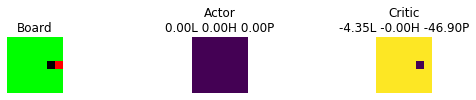

 26%|██▌       | 258/1000 [1:31:56<2:45:11, 13.36s/it]

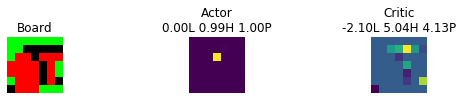

 26%|██▌       | 259/1000 [1:32:07<2:35:54, 12.62s/it]

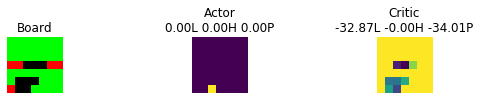

 26%|██▌       | 260/1000 [1:32:23<2:49:11, 13.72s/it]

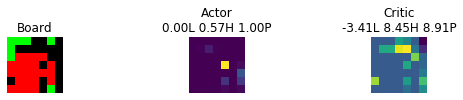

 26%|██▌       | 261/1000 [1:32:41<3:05:05, 15.03s/it]

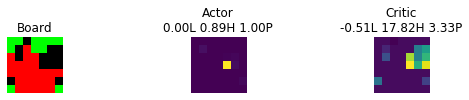

 26%|██▌       | 262/1000 [1:32:54<2:56:24, 14.34s/it]

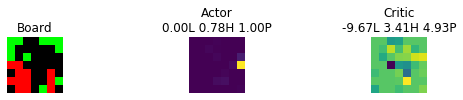

 26%|██▋       | 263/1000 [1:33:06<2:49:00, 13.76s/it]

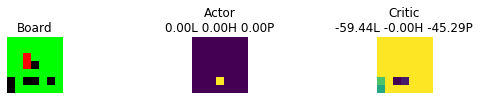

 26%|██▋       | 264/1000 [1:33:36<3:47:53, 18.58s/it]

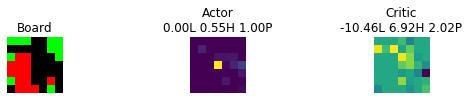

 26%|██▋       | 265/1000 [1:33:49<3:27:00, 16.90s/it]

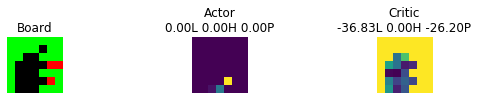

 27%|██▋       | 266/1000 [1:34:00<3:03:52, 15.03s/it]

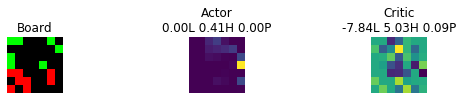

 27%|██▋       | 267/1000 [1:34:11<2:50:30, 13.96s/it]

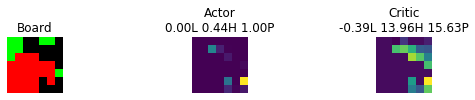

 27%|██▋       | 268/1000 [1:34:32<3:17:51, 16.22s/it]

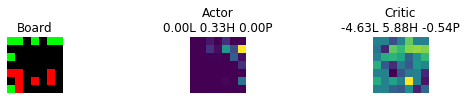

 27%|██▋       | 269/1000 [1:34:50<3:21:07, 16.51s/it]

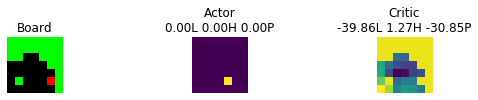

 27%|██▋       | 270/1000 [1:35:28<4:41:52, 23.17s/it]

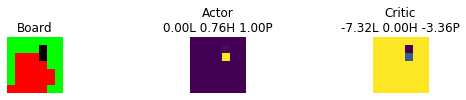

 27%|██▋       | 271/1000 [1:35:57<5:02:28, 24.89s/it]

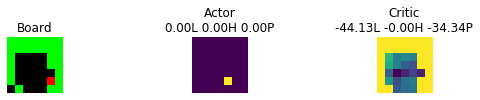

 27%|██▋       | 272/1000 [1:36:04<3:55:27, 19.41s/it]

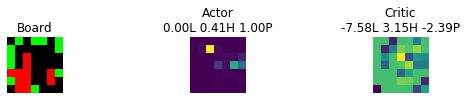

 27%|██▋       | 273/1000 [1:36:24<3:59:35, 19.77s/it]

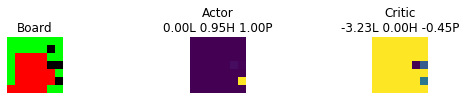

 27%|██▋       | 274/1000 [1:36:36<3:28:16, 17.21s/it]

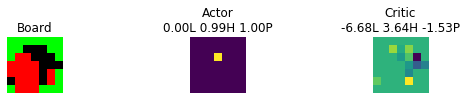

 28%|██▊       | 275/1000 [1:37:04<4:08:58, 20.60s/it]

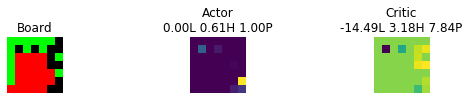

 28%|██▊       | 276/1000 [1:37:16<3:35:15, 17.84s/it]

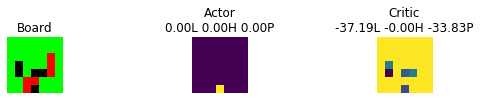

 28%|██▊       | 277/1000 [1:37:28<3:13:25, 16.05s/it]

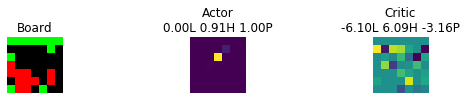

 28%|██▊       | 278/1000 [1:37:40<3:00:20, 14.99s/it]

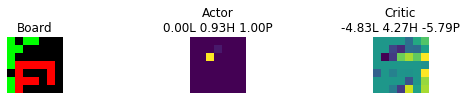

 28%|██▊       | 279/1000 [1:37:47<2:30:57, 12.56s/it]

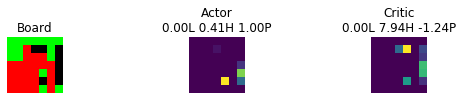

 28%|██▊       | 280/1000 [1:38:03<2:44:43, 13.73s/it]

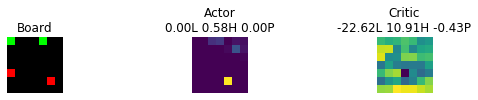

 28%|██▊       | 281/1000 [1:38:16<2:38:59, 13.27s/it]

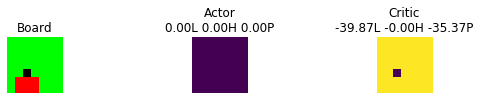

 28%|██▊       | 282/1000 [1:38:35<3:00:40, 15.10s/it]

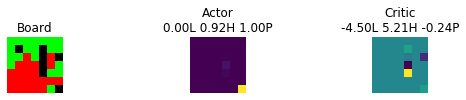

 28%|██▊       | 283/1000 [1:38:56<3:22:48, 16.97s/it]

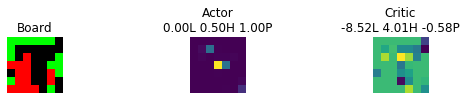

 28%|██▊       | 284/1000 [1:39:21<3:50:16, 19.30s/it]

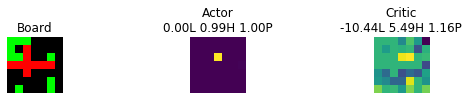

 28%|██▊       | 285/1000 [1:39:28<3:05:07, 15.54s/it]

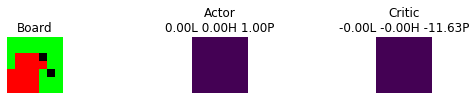

 29%|██▊       | 286/1000 [1:40:06<4:27:23, 22.47s/it]

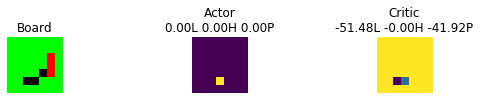

 29%|██▊       | 287/1000 [1:40:18<3:46:50, 19.09s/it]

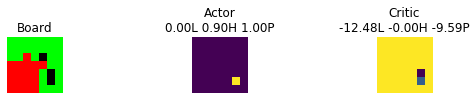

 29%|██▉       | 288/1000 [1:40:31<3:28:00, 17.53s/it]

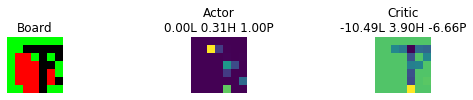

 29%|██▉       | 289/1000 [1:40:54<3:47:08, 19.17s/it]

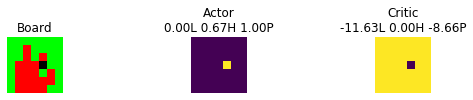

 29%|██▉       | 290/1000 [1:41:06<3:18:53, 16.81s/it]

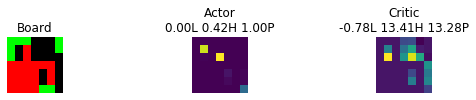

 29%|██▉       | 291/1000 [1:41:13<2:46:00, 14.05s/it]

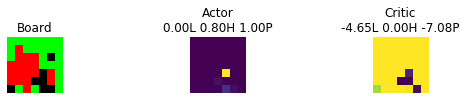

 29%|██▉       | 292/1000 [1:41:34<3:08:44, 16.00s/it]

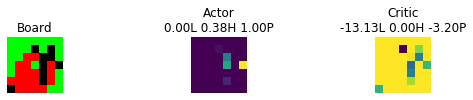

 29%|██▉       | 293/1000 [1:41:42<2:41:11, 13.68s/it]

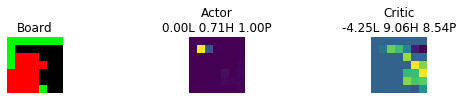

 29%|██▉       | 294/1000 [1:41:54<2:35:26, 13.21s/it]

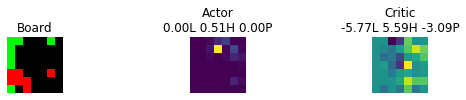

 30%|██▉       | 295/1000 [1:42:22<3:26:19, 17.56s/it]

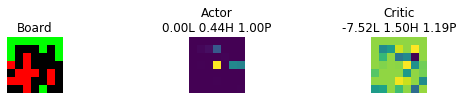

 30%|██▉       | 296/1000 [1:42:34<3:07:45, 16.00s/it]

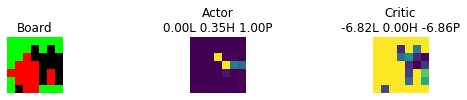

 30%|██▉       | 297/1000 [1:43:09<4:12:38, 21.56s/it]

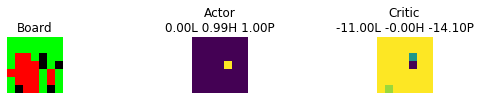

 30%|██▉       | 298/1000 [1:43:37<4:36:39, 23.65s/it]

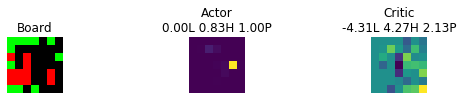

 30%|██▉       | 299/1000 [1:43:56<4:18:53, 22.16s/it]

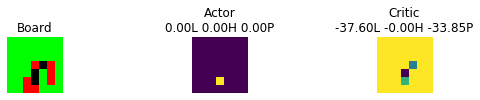

 30%|███       | 300/1000 [1:44:09<3:46:29, 19.41s/it]I0720 19:16:53.667322 4623369664 <ipython-input-34-fc3bfac52b9e>:10] Updated opponent


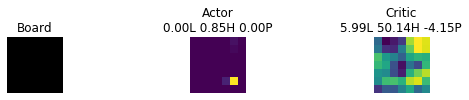

 30%|███       | 301/1000 [1:44:49<4:56:07, 25.42s/it]

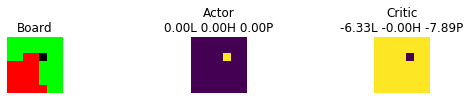

 30%|███       | 302/1000 [1:45:10<4:43:07, 24.34s/it]

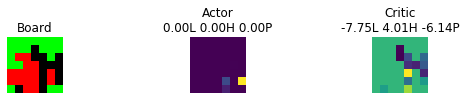

 30%|███       | 303/1000 [1:45:22<3:57:55, 20.48s/it]

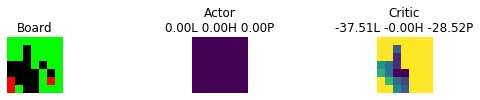

 30%|███       | 304/1000 [1:45:33<3:25:40, 17.73s/it]

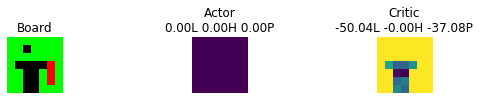

 30%|███       | 305/1000 [1:45:45<3:05:53, 16.05s/it]

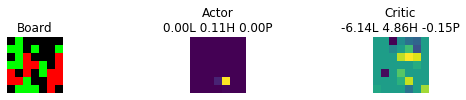

 31%|███       | 306/1000 [1:45:57<2:49:50, 14.68s/it]

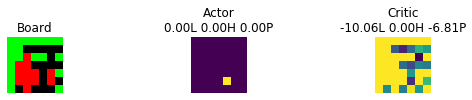

 31%|███       | 307/1000 [1:46:08<2:37:44, 13.66s/it]

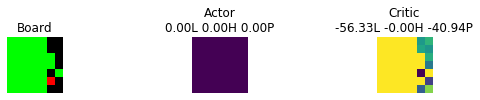

 31%|███       | 308/1000 [1:46:30<3:06:05, 16.14s/it]

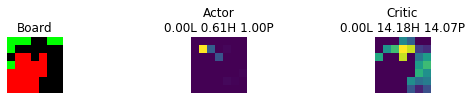

 31%|███       | 309/1000 [1:46:42<2:50:22, 14.79s/it]

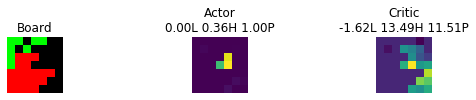

 31%|███       | 310/1000 [1:46:53<2:38:38, 13.80s/it]

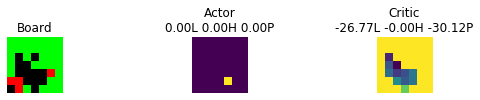

 31%|███       | 311/1000 [1:47:26<3:43:28, 19.46s/it]

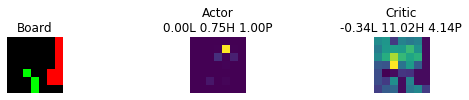

 31%|███       | 312/1000 [1:47:37<3:15:44, 17.07s/it]

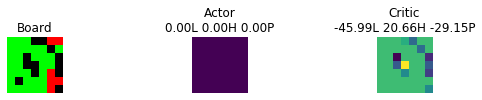

 31%|███▏      | 313/1000 [1:47:49<2:55:56, 15.37s/it]

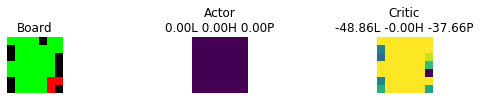

 31%|███▏      | 314/1000 [1:48:01<2:44:03, 14.35s/it]

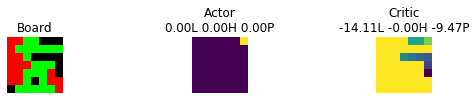

 32%|███▏      | 315/1000 [1:48:13<2:35:20, 13.61s/it]

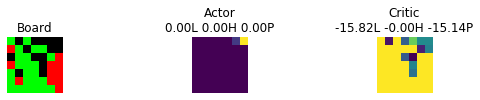

 32%|███▏      | 316/1000 [1:48:35<3:07:02, 16.41s/it]

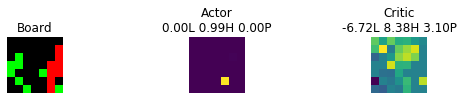

 32%|███▏      | 317/1000 [1:49:01<3:36:18, 19.00s/it]

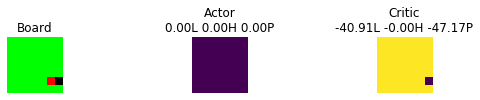

 32%|███▏      | 318/1000 [1:49:13<3:12:05, 16.90s/it]

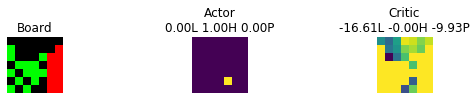

 32%|███▏      | 319/1000 [1:49:26<3:01:09, 15.96s/it]

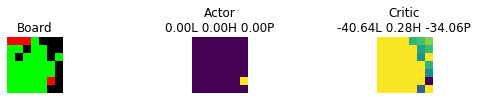

 32%|███▏      | 320/1000 [1:49:40<2:53:33, 15.31s/it]

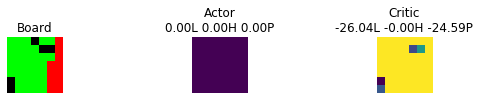

 32%|███▏      | 321/1000 [1:50:19<4:12:50, 22.34s/it]

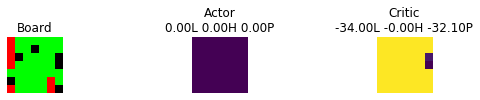

 32%|███▏      | 322/1000 [1:50:30<3:35:14, 19.05s/it]

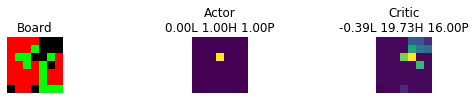

 32%|███▏      | 323/1000 [1:50:42<3:10:54, 16.92s/it]

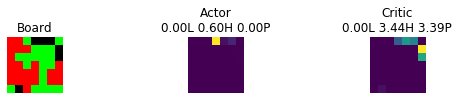

 32%|███▏      | 324/1000 [1:50:54<2:52:29, 15.31s/it]

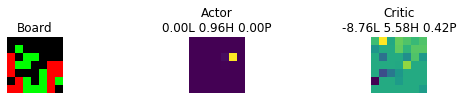

 32%|███▎      | 325/1000 [1:51:06<2:43:36, 14.54s/it]

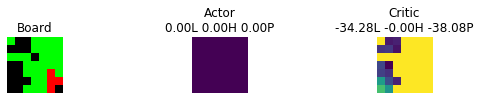

 33%|███▎      | 326/1000 [1:51:45<4:05:04, 21.82s/it]

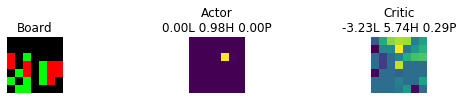

 33%|███▎      | 327/1000 [1:51:57<3:29:29, 18.68s/it]

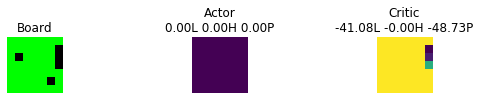

 33%|███▎      | 328/1000 [1:52:15<3:27:33, 18.53s/it]

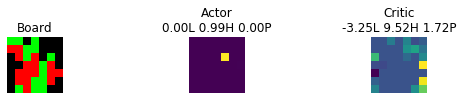

 33%|███▎      | 329/1000 [1:52:28<3:07:51, 16.80s/it]

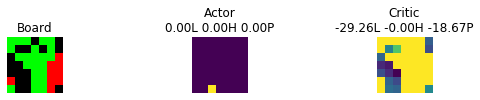

 33%|███▎      | 330/1000 [1:52:40<2:51:54, 15.39s/it]

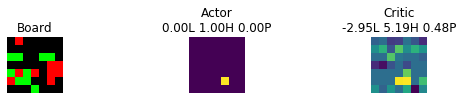

 33%|███▎      | 331/1000 [1:52:52<2:41:45, 14.51s/it]

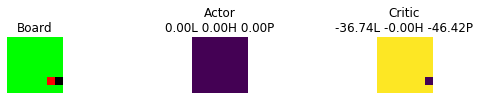

 33%|███▎      | 332/1000 [1:53:05<2:34:54, 13.91s/it]

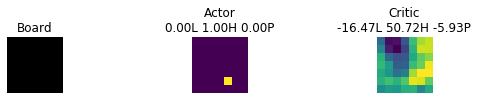

 33%|███▎      | 333/1000 [1:53:18<2:32:13, 13.69s/it]

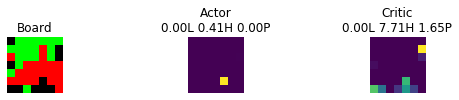

 33%|███▎      | 334/1000 [1:53:30<2:25:28, 13.11s/it]

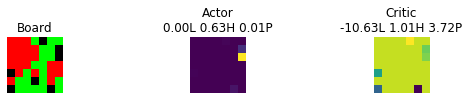

 34%|███▎      | 335/1000 [1:53:45<2:33:03, 13.81s/it]

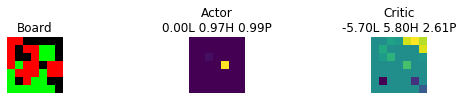

 34%|███▎      | 336/1000 [1:53:58<2:30:24, 13.59s/it]

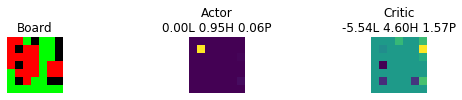

 34%|███▎      | 337/1000 [1:54:10<2:23:50, 13.02s/it]

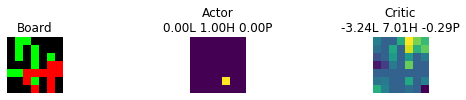

 34%|███▍      | 338/1000 [1:54:22<2:21:29, 12.82s/it]

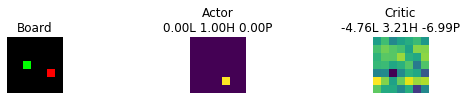

 34%|███▍      | 339/1000 [1:54:34<2:16:54, 12.43s/it]

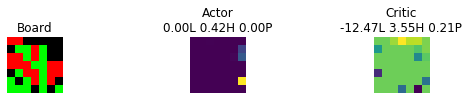

 34%|███▍      | 340/1000 [1:54:47<2:20:07, 12.74s/it]

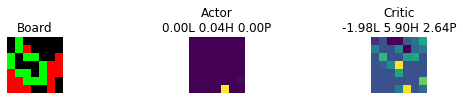

 34%|███▍      | 341/1000 [1:55:09<2:51:16, 15.59s/it]

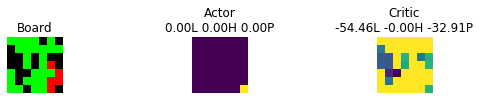

 34%|███▍      | 342/1000 [1:55:21<2:38:30, 14.45s/it]

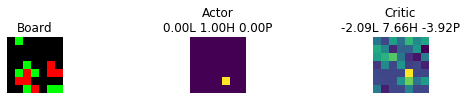

 34%|███▍      | 343/1000 [1:55:32<2:27:55, 13.51s/it]

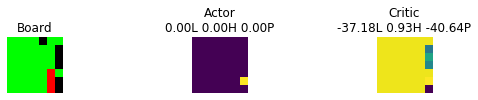

 34%|███▍      | 344/1000 [1:55:45<2:23:12, 13.10s/it]

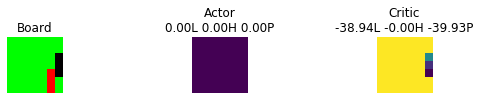

 34%|███▍      | 345/1000 [1:56:03<2:39:01, 14.57s/it]

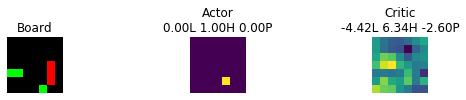

 35%|███▍      | 346/1000 [1:56:27<3:09:35, 17.39s/it]

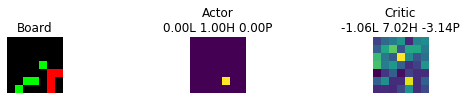

 35%|███▍      | 347/1000 [1:56:45<3:11:52, 17.63s/it]

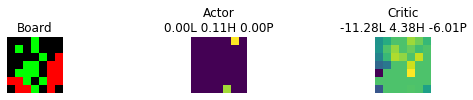

 35%|███▍      | 348/1000 [1:57:19<4:05:28, 22.59s/it]

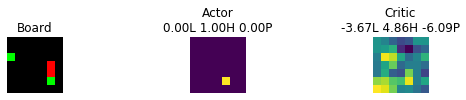

 35%|███▍      | 349/1000 [1:57:37<3:50:56, 21.28s/it]

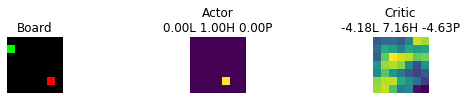

 35%|███▌      | 350/1000 [1:57:49<3:18:59, 18.37s/it]

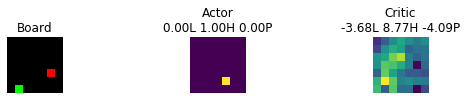

 35%|███▌      | 351/1000 [1:58:00<2:55:51, 16.26s/it]

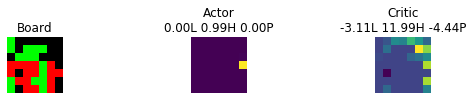

 35%|███▌      | 352/1000 [1:58:11<2:39:25, 14.76s/it]

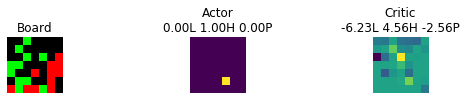

 35%|███▌      | 353/1000 [1:58:23<2:29:52, 13.90s/it]

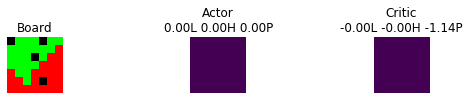

 35%|███▌      | 354/1000 [1:58:35<2:22:37, 13.25s/it]

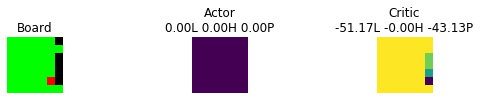

 36%|███▌      | 355/1000 [1:58:46<2:16:39, 12.71s/it]

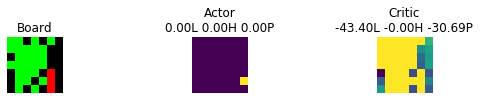

 36%|███▌      | 356/1000 [1:58:58<2:12:08, 12.31s/it]

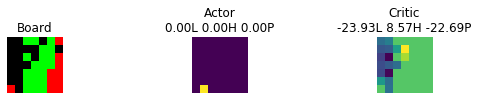

 36%|███▌      | 357/1000 [1:59:10<2:11:07, 12.24s/it]

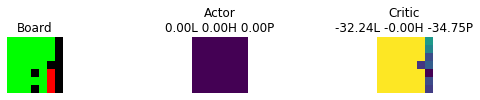

 36%|███▌      | 358/1000 [1:59:21<2:08:44, 12.03s/it]

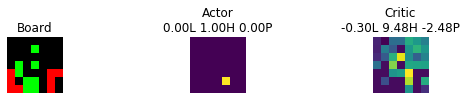

 36%|███▌      | 359/1000 [1:59:50<3:00:44, 16.92s/it]

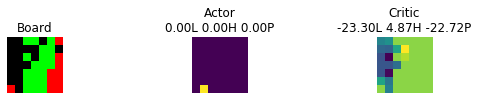

 36%|███▌      | 360/1000 [2:00:01<2:42:48, 15.26s/it]

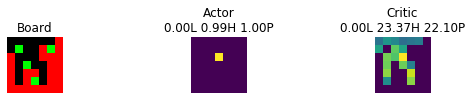

 36%|███▌      | 361/1000 [2:00:13<2:31:29, 14.22s/it]

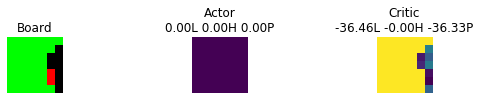

 36%|███▌      | 362/1000 [2:00:25<2:23:28, 13.49s/it]

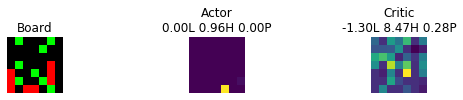

 36%|███▋      | 363/1000 [2:00:36<2:17:23, 12.94s/it]

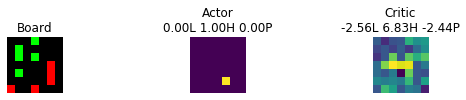

 36%|███▋      | 364/1000 [2:00:53<2:29:58, 14.15s/it]

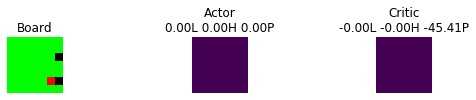

 36%|███▋      | 365/1000 [2:01:16<2:56:04, 16.64s/it]

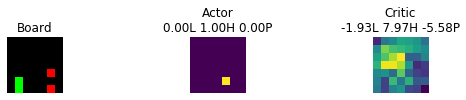

 37%|███▋      | 366/1000 [2:01:27<2:40:02, 15.15s/it]

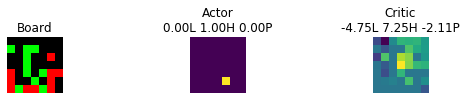

 37%|███▋      | 367/1000 [2:01:52<3:08:09, 17.83s/it]

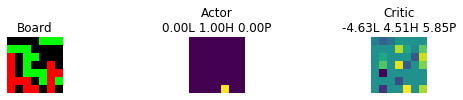

 37%|███▋      | 368/1000 [2:02:11<3:13:28, 18.37s/it]

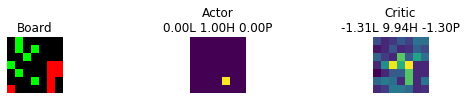

 37%|███▋      | 369/1000 [2:02:33<3:25:10, 19.51s/it]

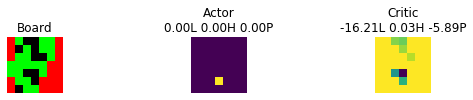

 37%|███▋      | 370/1000 [2:02:45<2:59:27, 17.09s/it]

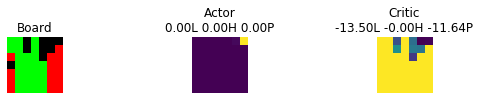

 37%|███▋      | 371/1000 [2:02:56<2:41:23, 15.39s/it]

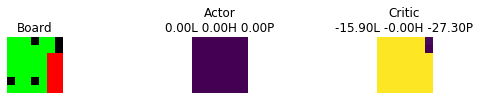

 37%|███▋      | 372/1000 [2:03:09<2:32:32, 14.57s/it]

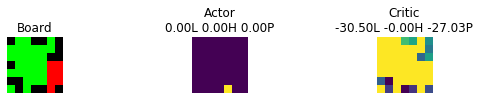

 37%|███▋      | 373/1000 [2:03:21<2:23:21, 13.72s/it]

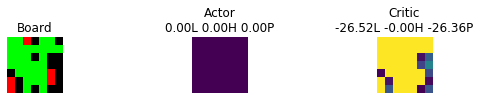

 37%|███▋      | 374/1000 [2:03:32<2:17:08, 13.14s/it]

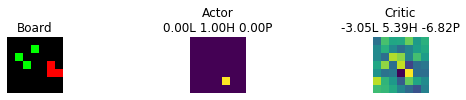

 38%|███▊      | 375/1000 [2:03:46<2:18:50, 13.33s/it]

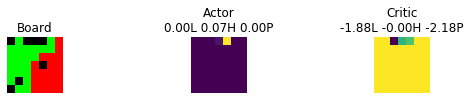

 38%|███▊      | 376/1000 [2:03:58<2:12:36, 12.75s/it]

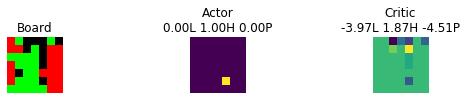

 38%|███▊      | 377/1000 [2:04:09<2:08:48, 12.41s/it]

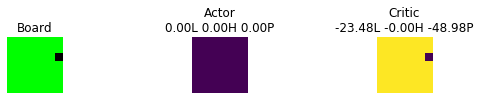

 38%|███▊      | 378/1000 [2:04:21<2:06:09, 12.17s/it]

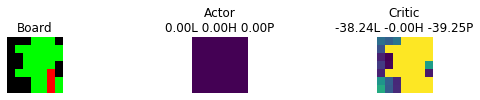

 38%|███▊      | 379/1000 [2:04:33<2:04:57, 12.07s/it]

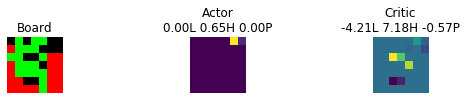

 38%|███▊      | 380/1000 [2:04:45<2:07:02, 12.29s/it]

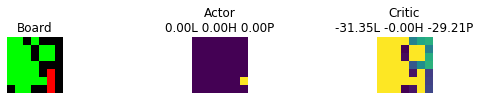

 38%|███▊      | 381/1000 [2:04:58<2:06:11, 12.23s/it]

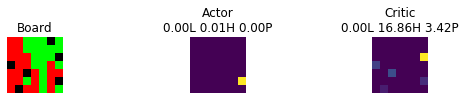

 38%|███▊      | 382/1000 [2:05:10<2:05:31, 12.19s/it]

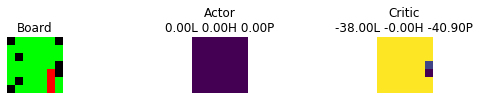

 38%|███▊      | 383/1000 [2:05:32<2:37:28, 15.31s/it]

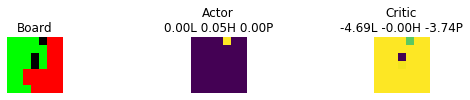

 38%|███▊      | 384/1000 [2:05:44<2:25:30, 14.17s/it]

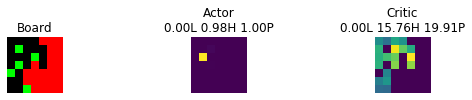

 38%|███▊      | 385/1000 [2:05:56<2:20:22, 13.70s/it]

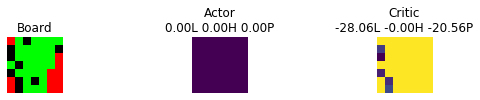

 39%|███▊      | 386/1000 [2:06:08<2:14:44, 13.17s/it]

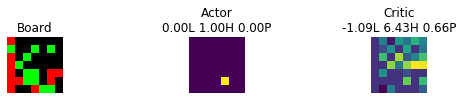

 39%|███▊      | 387/1000 [2:06:20<2:09:31, 12.68s/it]

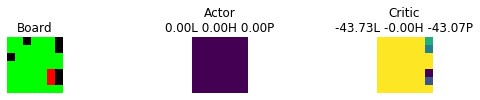

 39%|███▉      | 388/1000 [2:06:43<2:41:22, 15.82s/it]

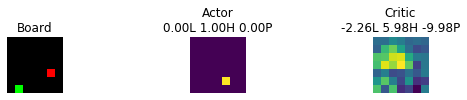

 39%|███▉      | 389/1000 [2:06:54<2:25:15, 14.26s/it]

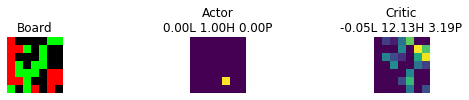

 39%|███▉      | 390/1000 [2:07:11<2:34:04, 15.16s/it]

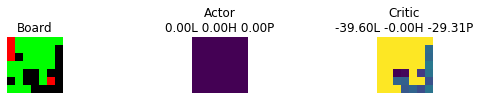

 39%|███▉      | 391/1000 [2:07:35<3:00:05, 17.74s/it]

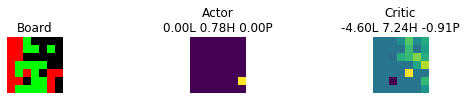

 39%|███▉      | 392/1000 [2:07:46<2:40:36, 15.85s/it]

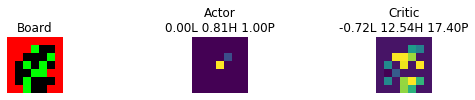

 39%|███▉      | 393/1000 [2:07:58<2:27:42, 14.60s/it]

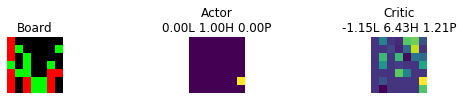

 39%|███▉      | 394/1000 [2:08:10<2:20:49, 13.94s/it]

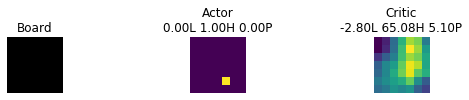

 40%|███▉      | 395/1000 [2:08:39<3:06:23, 18.48s/it]

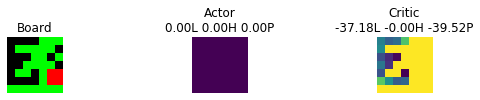

 40%|███▉      | 396/1000 [2:09:01<3:16:50, 19.55s/it]

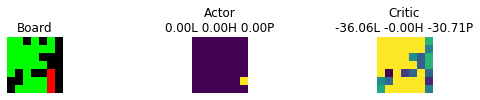

 40%|███▉      | 397/1000 [2:09:13<2:53:41, 17.28s/it]

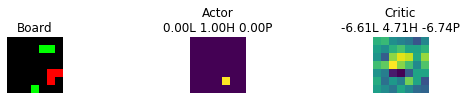

 40%|███▉      | 398/1000 [2:09:24<2:32:58, 15.25s/it]

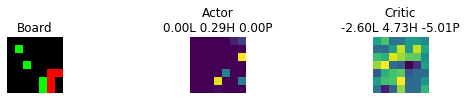

 40%|███▉      | 399/1000 [2:09:47<2:58:05, 17.78s/it]

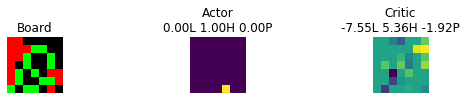

 40%|████      | 400/1000 [2:09:59<2:39:37, 15.96s/it]I0720 19:42:43.735897 4623369664 <ipython-input-34-fc3bfac52b9e>:10] Updated opponent


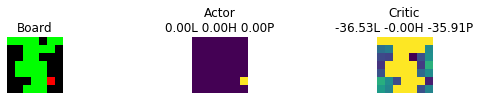

 40%|████      | 401/1000 [2:10:11<2:28:03, 14.83s/it]

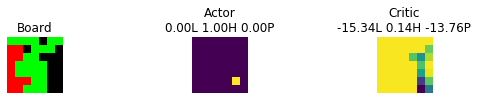

 40%|████      | 402/1000 [2:10:24<2:22:14, 14.27s/it]

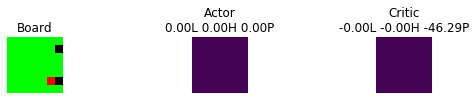

 40%|████      | 403/1000 [2:10:34<2:08:52, 12.95s/it]

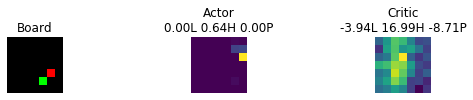

 40%|████      | 404/1000 [2:10:47<2:07:43, 12.86s/it]

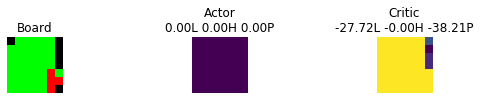

 40%|████      | 405/1000 [2:10:59<2:05:41, 12.68s/it]

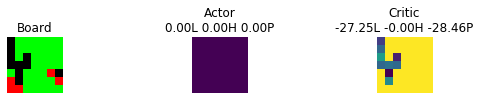

 41%|████      | 406/1000 [2:11:12<2:05:13, 12.65s/it]

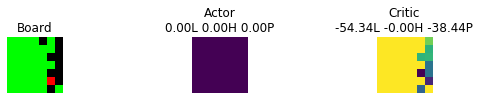

 41%|████      | 407/1000 [2:11:24<2:04:37, 12.61s/it]

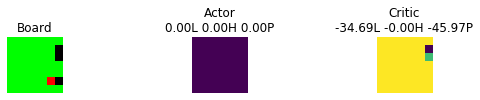

 41%|████      | 408/1000 [2:11:36<2:01:51, 12.35s/it]

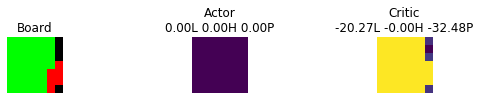

 41%|████      | 409/1000 [2:11:46<1:55:22, 11.71s/it]

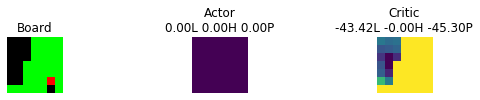

 41%|████      | 410/1000 [2:12:02<2:06:03, 12.82s/it]

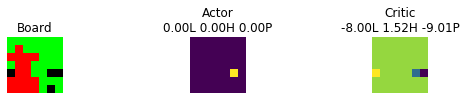

 41%|████      | 411/1000 [2:12:27<2:42:58, 16.60s/it]

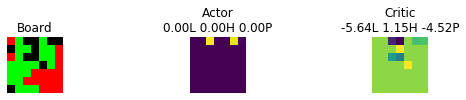

 41%|████      | 412/1000 [2:12:39<2:28:33, 15.16s/it]

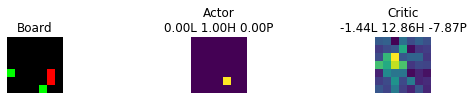

 41%|████▏     | 413/1000 [2:12:51<2:18:57, 14.20s/it]

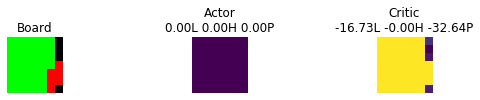

 41%|████▏     | 414/1000 [2:13:03<2:12:48, 13.60s/it]

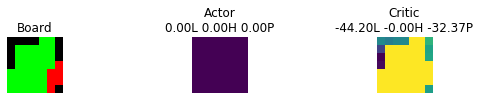

 42%|████▏     | 415/1000 [2:13:14<2:06:12, 12.95s/it]

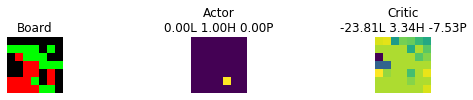

 42%|████▏     | 416/1000 [2:13:23<1:52:51, 11.59s/it]

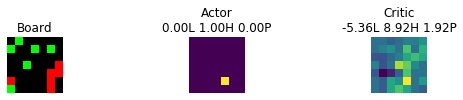

 42%|████▏     | 417/1000 [2:13:42<2:14:23, 13.83s/it]

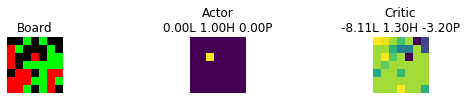

 42%|████▏     | 418/1000 [2:13:53<2:07:17, 13.12s/it]

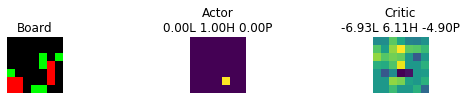

 42%|████▏     | 419/1000 [2:14:18<2:40:00, 16.52s/it]

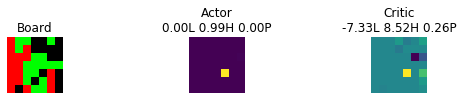

 42%|████▏     | 420/1000 [2:14:30<2:26:53, 15.20s/it]

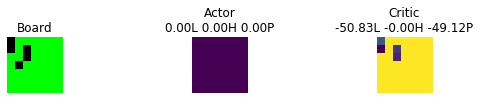

 42%|████▏     | 421/1000 [2:14:43<2:19:45, 14.48s/it]

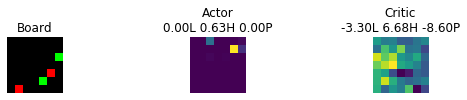

 42%|████▏     | 422/1000 [2:14:59<2:25:35, 15.11s/it]

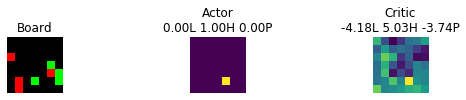

 42%|████▏     | 423/1000 [2:15:22<2:47:44, 17.44s/it]

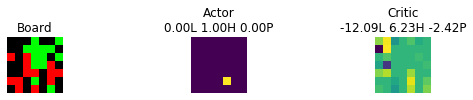

 42%|████▏     | 424/1000 [2:15:35<2:34:12, 16.06s/it]

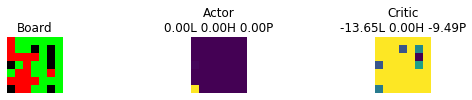

 42%|████▎     | 425/1000 [2:16:03<3:07:21, 19.55s/it]

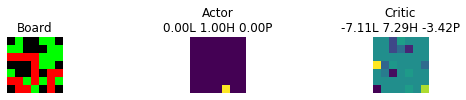

 43%|████▎     | 426/1000 [2:16:14<2:44:31, 17.20s/it]

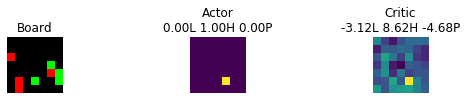

 43%|████▎     | 427/1000 [2:16:26<2:29:18, 15.63s/it]

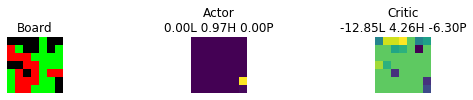

 43%|████▎     | 428/1000 [2:16:39<2:21:31, 14.85s/it]

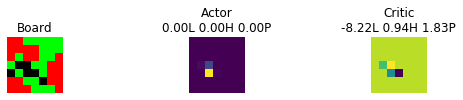

 43%|████▎     | 429/1000 [2:16:51<2:13:04, 13.98s/it]

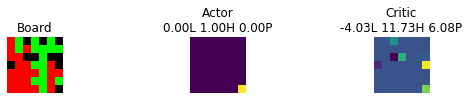

 43%|████▎     | 430/1000 [2:17:04<2:08:23, 13.51s/it]

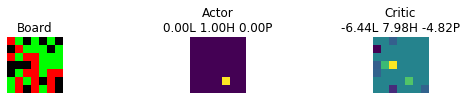

 43%|████▎     | 431/1000 [2:17:17<2:08:05, 13.51s/it]

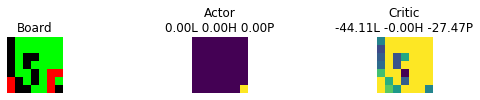

 43%|████▎     | 432/1000 [2:17:30<2:04:43, 13.18s/it]

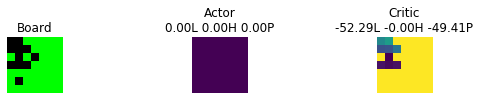

 43%|████▎     | 433/1000 [2:17:42<2:03:02, 13.02s/it]

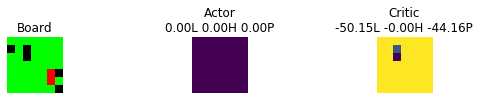

 43%|████▎     | 434/1000 [2:17:54<2:00:02, 12.73s/it]

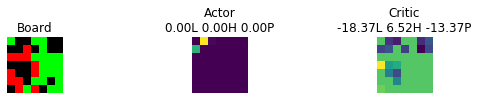

 44%|████▎     | 435/1000 [2:18:06<1:57:52, 12.52s/it]

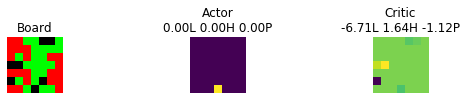

 44%|████▎     | 436/1000 [2:18:32<2:35:40, 16.56s/it]

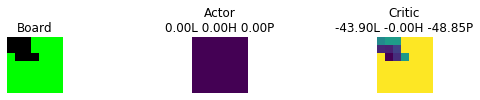

 44%|████▎     | 437/1000 [2:18:45<2:25:04, 15.46s/it]

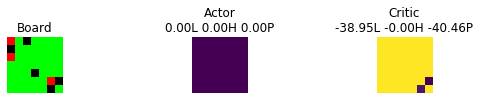

 44%|████▍     | 438/1000 [2:18:58<2:17:03, 14.63s/it]

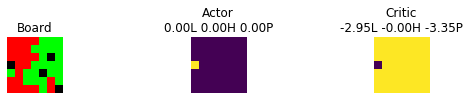

 44%|████▍     | 439/1000 [2:19:10<2:09:58, 13.90s/it]

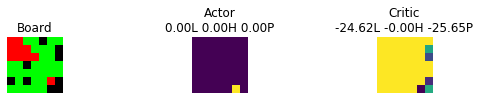

 44%|████▍     | 440/1000 [2:19:22<2:04:44, 13.36s/it]

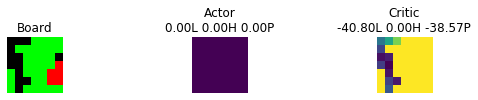

 44%|████▍     | 441/1000 [2:19:34<1:59:36, 12.84s/it]

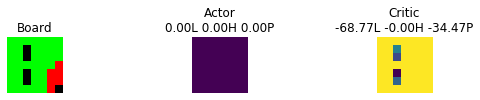

 44%|████▍     | 442/1000 [2:19:47<1:59:17, 12.83s/it]

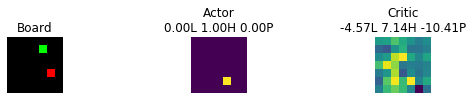

 44%|████▍     | 443/1000 [2:19:59<1:56:21, 12.53s/it]

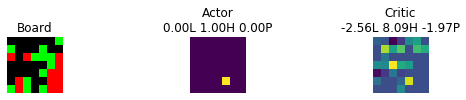

 44%|████▍     | 444/1000 [2:20:10<1:54:29, 12.35s/it]

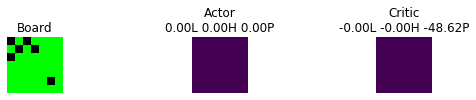

 44%|████▍     | 445/1000 [2:20:22<1:52:23, 12.15s/it]

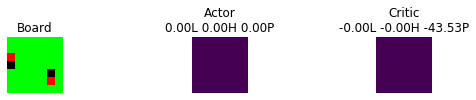

 45%|████▍     | 446/1000 [2:20:34<1:52:23, 12.17s/it]

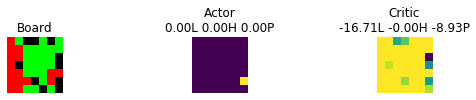

 45%|████▍     | 447/1000 [2:20:56<2:17:22, 14.90s/it]

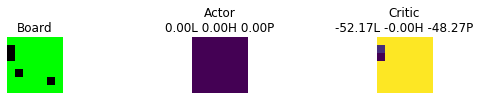

 45%|████▍     | 448/1000 [2:21:07<2:08:27, 13.96s/it]

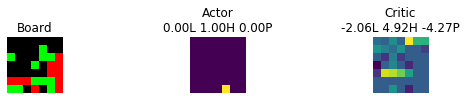

 45%|████▍     | 449/1000 [2:21:19<2:02:01, 13.29s/it]

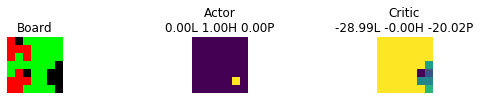

 45%|████▌     | 450/1000 [2:21:32<2:00:00, 13.09s/it]

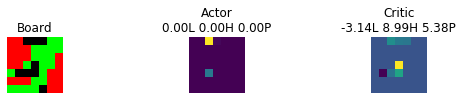

 45%|████▌     | 451/1000 [2:21:44<1:56:14, 12.70s/it]

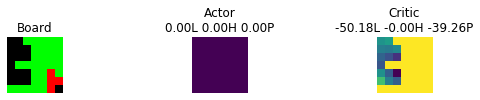

 45%|████▌     | 452/1000 [2:22:18<2:55:17, 19.19s/it]

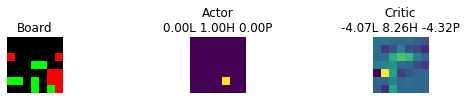

 45%|████▌     | 453/1000 [2:22:30<2:36:13, 17.14s/it]

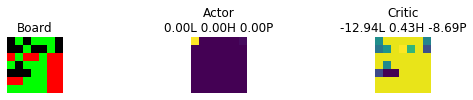

 45%|████▌     | 454/1000 [2:22:54<2:53:23, 19.05s/it]

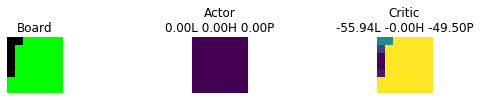

 46%|████▌     | 455/1000 [2:23:04<2:28:05, 16.30s/it]

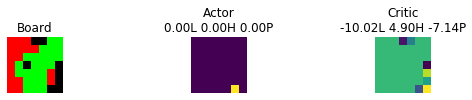

 46%|████▌     | 456/1000 [2:23:17<2:19:16, 15.36s/it]

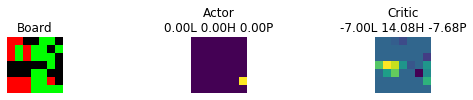

 46%|████▌     | 457/1000 [2:23:29<2:10:24, 14.41s/it]

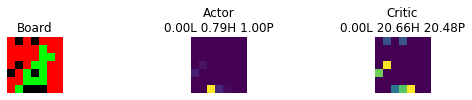

 46%|████▌     | 458/1000 [2:23:41<2:03:44, 13.70s/it]

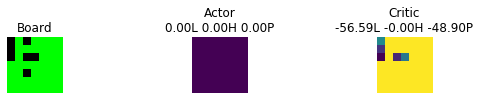

 46%|████▌     | 459/1000 [2:23:53<1:58:21, 13.13s/it]

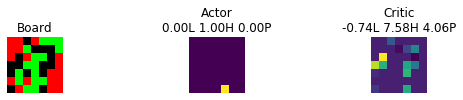

 46%|████▌     | 460/1000 [2:24:05<1:55:26, 12.83s/it]

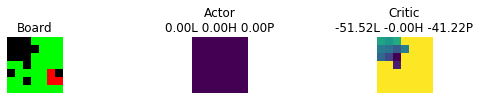

 46%|████▌     | 461/1000 [2:24:25<2:14:08, 14.93s/it]

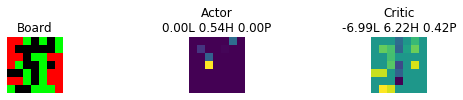

 46%|████▌     | 462/1000 [2:24:49<2:39:14, 17.76s/it]

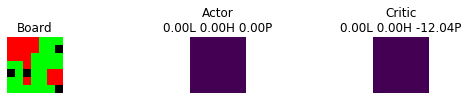

 46%|████▋     | 463/1000 [2:25:01<2:23:13, 16.00s/it]

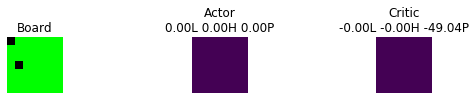

 46%|████▋     | 464/1000 [2:25:14<2:13:53, 14.99s/it]

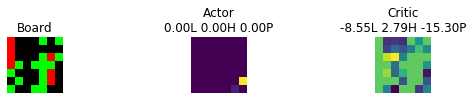

 46%|████▋     | 465/1000 [2:25:27<2:10:06, 14.59s/it]

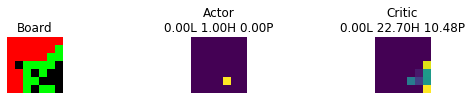

 47%|████▋     | 466/1000 [2:25:39<2:03:12, 13.84s/it]

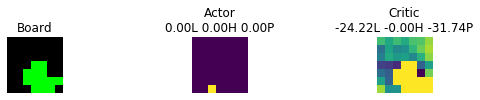

 47%|████▋     | 467/1000 [2:25:51<1:57:15, 13.20s/it]

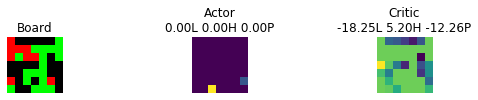

 47%|████▋     | 468/1000 [2:26:03<1:54:22, 12.90s/it]

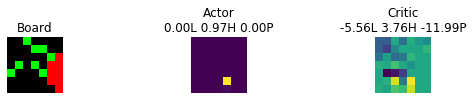

 47%|████▋     | 469/1000 [2:26:22<2:09:41, 14.65s/it]

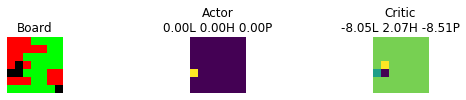

 47%|████▋     | 470/1000 [2:26:34<2:02:27, 13.86s/it]

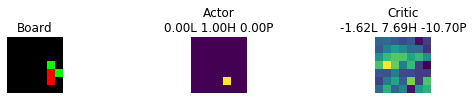

 47%|████▋     | 471/1000 [2:26:54<2:18:02, 15.66s/it]

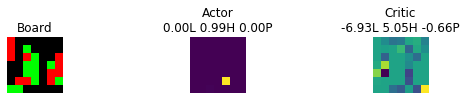

 47%|████▋     | 472/1000 [2:27:06<2:08:01, 14.55s/it]

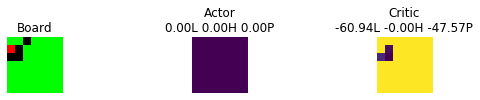

 47%|████▋     | 473/1000 [2:27:17<1:59:29, 13.61s/it]

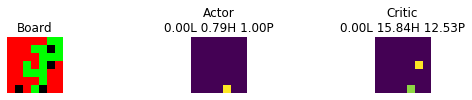

 47%|████▋     | 474/1000 [2:27:41<2:25:42, 16.62s/it]

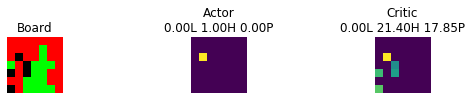

 48%|████▊     | 475/1000 [2:27:53<2:13:13, 15.23s/it]

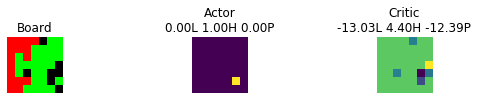

 48%|████▊     | 476/1000 [2:28:05<2:03:41, 14.16s/it]

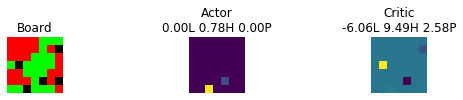

 48%|████▊     | 477/1000 [2:28:16<1:57:13, 13.45s/it]

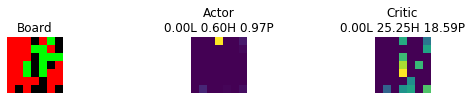

 48%|████▊     | 478/1000 [2:28:39<2:21:49, 16.30s/it]

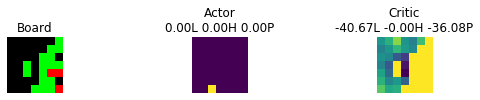

 48%|████▊     | 479/1000 [2:28:51<2:09:31, 14.92s/it]

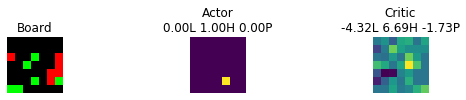

 48%|████▊     | 480/1000 [2:29:04<2:02:56, 14.19s/it]

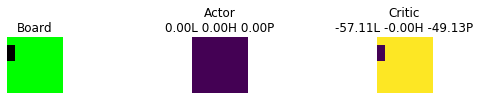

 48%|████▊     | 481/1000 [2:29:16<1:59:07, 13.77s/it]

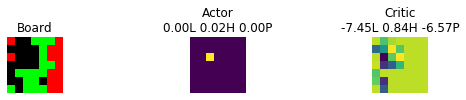

 48%|████▊     | 482/1000 [2:29:40<2:24:18, 16.72s/it]

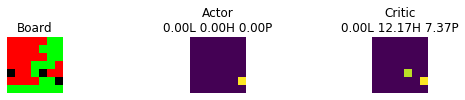

 48%|████▊     | 483/1000 [2:30:04<2:41:46, 18.78s/it]

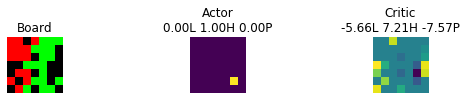

 48%|████▊     | 484/1000 [2:30:16<2:24:23, 16.79s/it]

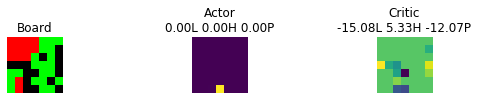

 48%|████▊     | 485/1000 [2:30:28<2:11:27, 15.32s/it]

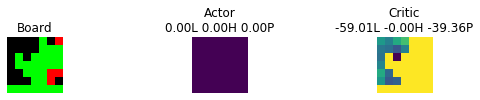

 49%|████▊     | 486/1000 [2:30:40<2:03:06, 14.37s/it]

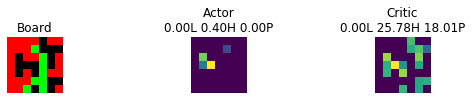

 49%|████▊     | 487/1000 [2:30:52<1:57:52, 13.79s/it]

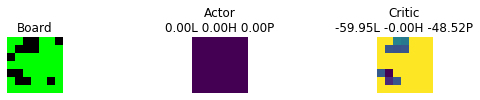

 49%|████▉     | 488/1000 [2:31:05<1:55:32, 13.54s/it]

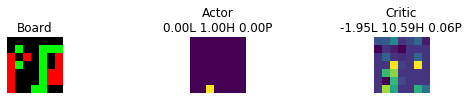

 49%|████▉     | 489/1000 [2:31:17<1:52:06, 13.16s/it]

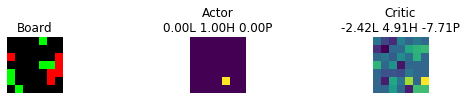

 49%|████▉     | 490/1000 [2:31:36<2:04:46, 14.68s/it]

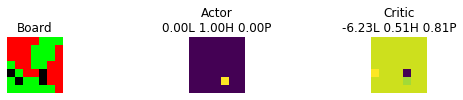

 49%|████▉     | 491/1000 [2:31:47<1:57:13, 13.82s/it]

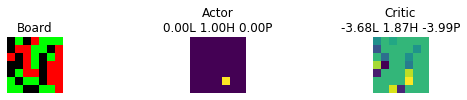

 49%|████▉     | 492/1000 [2:32:02<1:59:21, 14.10s/it]

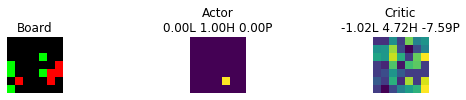

 49%|████▉     | 493/1000 [2:32:15<1:55:26, 13.66s/it]

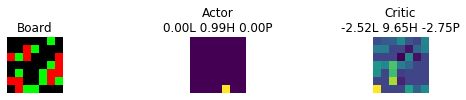

 49%|████▉     | 494/1000 [2:32:46<2:38:33, 18.80s/it]

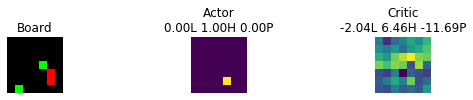

 50%|████▉     | 495/1000 [2:33:00<2:27:38, 17.54s/it]

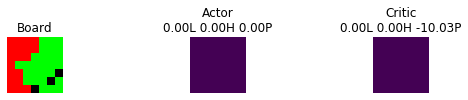

 50%|████▉     | 496/1000 [2:33:12<2:12:16, 15.75s/it]

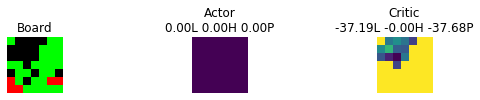

 50%|████▉     | 497/1000 [2:33:24<2:02:09, 14.57s/it]

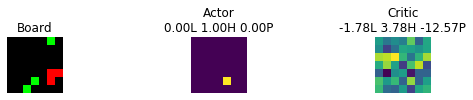

 50%|████▉     | 498/1000 [2:33:36<1:55:23, 13.79s/it]

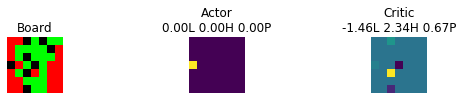

 50%|████▉     | 499/1000 [2:33:54<2:06:02, 15.10s/it]

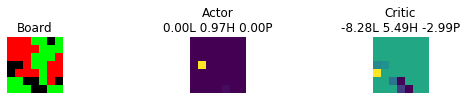

 50%|█████     | 500/1000 [2:34:06<1:59:45, 14.37s/it]I0720 20:06:51.091745 4623369664 <ipython-input-34-fc3bfac52b9e>:10] Updated opponent


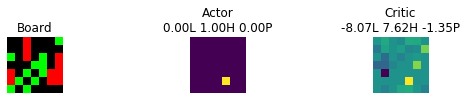

 50%|█████     | 501/1000 [2:34:19<1:54:37, 13.78s/it]

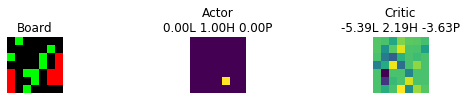

 50%|█████     | 502/1000 [2:34:30<1:48:44, 13.10s/it]

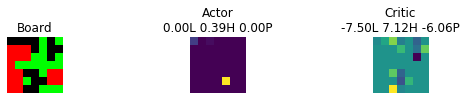

 50%|█████     | 503/1000 [2:34:42<1:44:49, 12.65s/it]

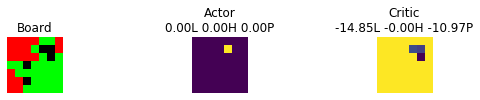

 50%|█████     | 504/1000 [2:34:54<1:42:47, 12.44s/it]

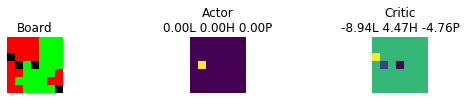

 50%|█████     | 505/1000 [2:35:06<1:41:26, 12.30s/it]

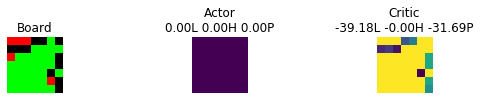

 51%|█████     | 506/1000 [2:35:18<1:40:35, 12.22s/it]

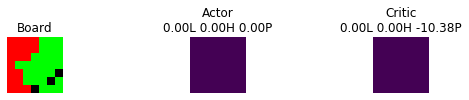

 51%|█████     | 507/1000 [2:35:37<1:57:42, 14.33s/it]

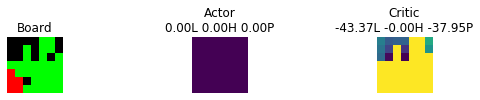

 51%|█████     | 508/1000 [2:35:49<1:51:28, 13.60s/it]

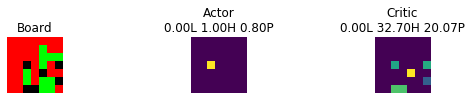

 51%|█████     | 509/1000 [2:36:17<2:26:31, 17.91s/it]

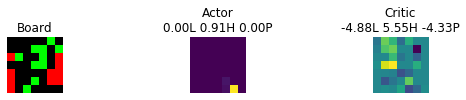

 51%|█████     | 510/1000 [2:36:29<2:11:13, 16.07s/it]

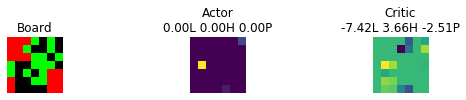

 51%|█████     | 511/1000 [2:36:47<2:17:09, 16.83s/it]

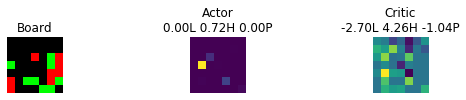

 51%|█████     | 512/1000 [2:36:59<2:05:10, 15.39s/it]

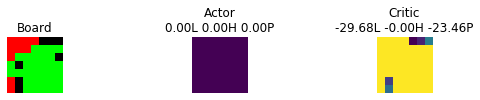

 51%|█████▏    | 513/1000 [2:37:12<1:57:38, 14.49s/it]

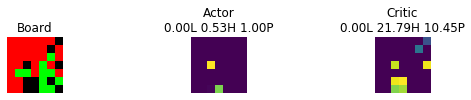

 51%|█████▏    | 514/1000 [2:37:23<1:50:38, 13.66s/it]

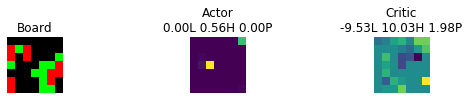

 52%|█████▏    | 515/1000 [2:37:35<1:45:58, 13.11s/it]

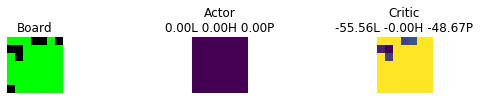

 52%|█████▏    | 516/1000 [2:37:47<1:42:18, 12.68s/it]

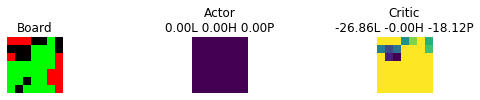

 52%|█████▏    | 517/1000 [2:37:59<1:40:13, 12.45s/it]

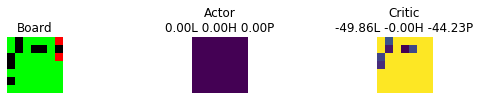

 52%|█████▏    | 518/1000 [2:38:11<1:38:26, 12.25s/it]

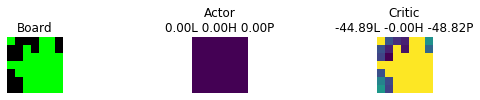

 52%|█████▏    | 519/1000 [2:38:22<1:36:57, 12.09s/it]

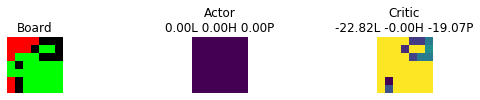

 52%|█████▏    | 520/1000 [2:38:35<1:37:09, 12.15s/it]

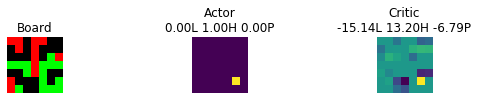

 52%|█████▏    | 521/1000 [2:38:47<1:36:14, 12.06s/it]

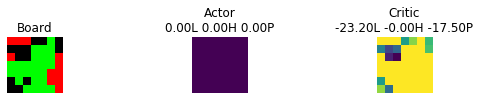

 52%|█████▏    | 522/1000 [2:38:59<1:37:31, 12.24s/it]

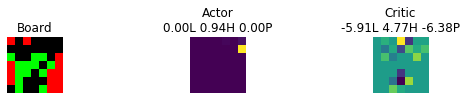

 52%|█████▏    | 523/1000 [2:39:12<1:37:40, 12.29s/it]

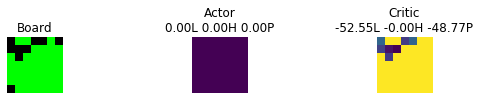

 52%|█████▏    | 524/1000 [2:39:23<1:36:10, 12.12s/it]

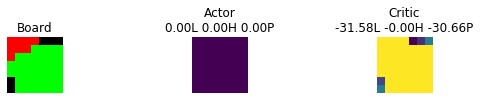

 52%|█████▎    | 525/1000 [2:39:36<1:36:15, 12.16s/it]

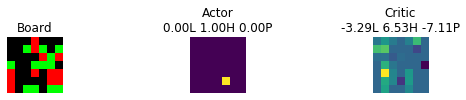

 53%|█████▎    | 526/1000 [2:39:48<1:35:50, 12.13s/it]

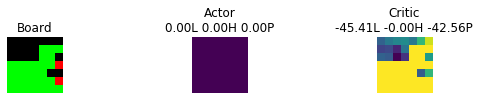

 53%|█████▎    | 527/1000 [2:40:00<1:35:10, 12.07s/it]

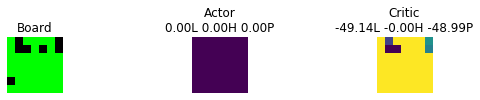

 53%|█████▎    | 528/1000 [2:40:11<1:34:13, 11.98s/it]

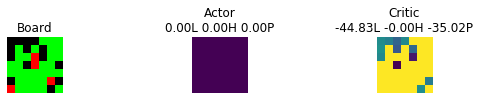

 53%|█████▎    | 529/1000 [2:40:24<1:34:59, 12.10s/it]

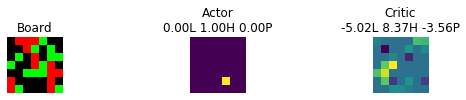

 53%|█████▎    | 530/1000 [2:40:35<1:34:01, 12.00s/it]

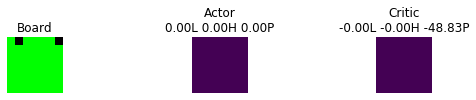

 53%|█████▎    | 531/1000 [2:40:48<1:34:38, 12.11s/it]

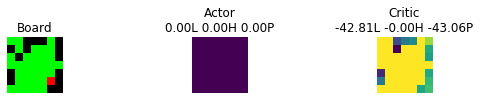

 53%|█████▎    | 532/1000 [2:40:59<1:31:28, 11.73s/it]

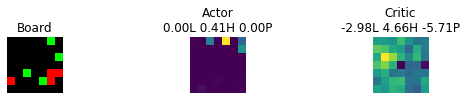

 53%|█████▎    | 533/1000 [2:41:11<1:31:52, 11.80s/it]

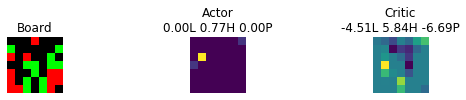

 53%|█████▎    | 534/1000 [2:41:18<1:21:08, 10.45s/it]

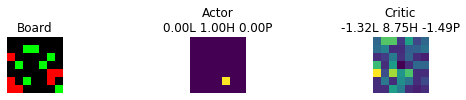

 54%|█████▎    | 535/1000 [2:41:30<1:24:57, 10.96s/it]

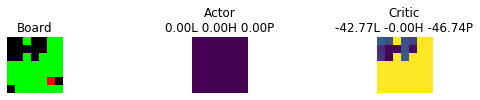

 54%|█████▎    | 536/1000 [2:41:43<1:28:13, 11.41s/it]

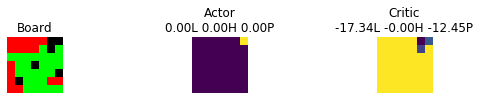

 54%|█████▎    | 537/1000 [2:41:55<1:29:43, 11.63s/it]

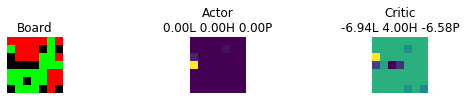

 54%|█████▍    | 538/1000 [2:42:07<1:31:45, 11.92s/it]

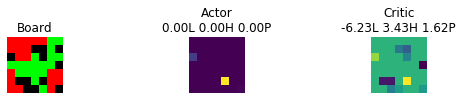

 54%|█████▍    | 539/1000 [2:42:19<1:31:56, 11.97s/it]

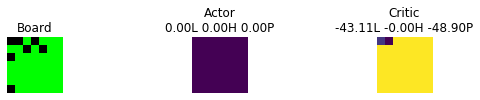

 54%|█████▍    | 540/1000 [2:42:32<1:32:16, 12.03s/it]

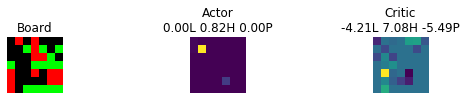

 54%|█████▍    | 541/1000 [2:42:40<1:23:33, 10.92s/it]

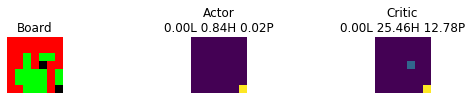

 54%|█████▍    | 542/1000 [2:42:59<1:41:46, 13.33s/it]

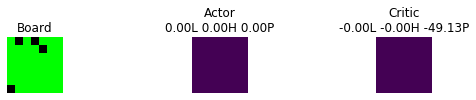

 54%|█████▍    | 543/1000 [2:43:12<1:40:58, 13.26s/it]

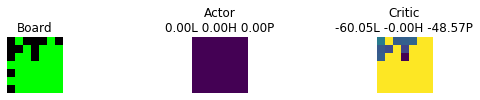

 54%|█████▍    | 544/1000 [2:43:24<1:39:08, 13.04s/it]

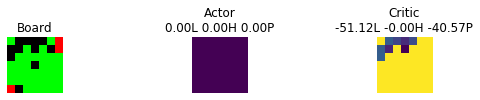

 55%|█████▍    | 545/1000 [2:43:47<2:00:50, 15.93s/it]

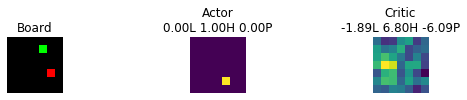

 55%|█████▍    | 546/1000 [2:44:01<1:55:53, 15.32s/it]

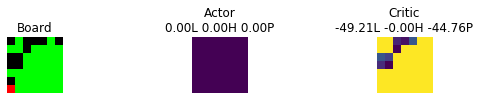

 55%|█████▍    | 547/1000 [2:44:14<1:49:53, 14.55s/it]

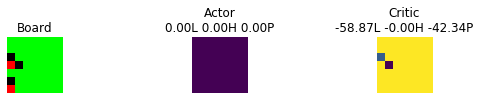

 55%|█████▍    | 548/1000 [2:44:27<1:45:48, 14.05s/it]

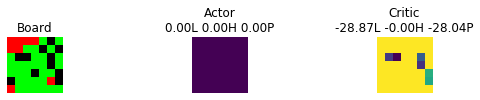

 55%|█████▍    | 549/1000 [2:44:52<2:10:29, 17.36s/it]

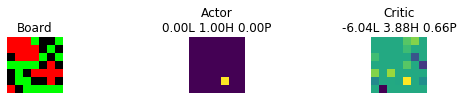

 55%|█████▌    | 550/1000 [2:45:04<1:59:31, 15.94s/it]

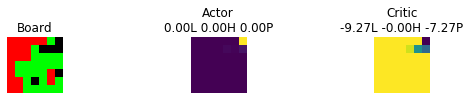

 55%|█████▌    | 551/1000 [2:45:17<1:50:50, 14.81s/it]

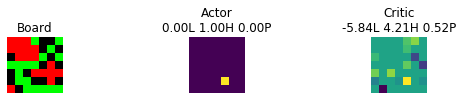

 55%|█████▌    | 552/1000 [2:45:28<1:44:03, 13.94s/it]

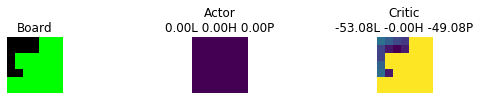

 55%|█████▌    | 553/1000 [2:45:53<2:06:49, 17.02s/it]

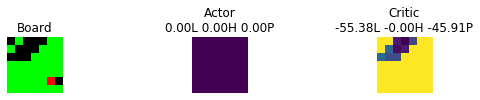

 55%|█████▌    | 554/1000 [2:46:06<1:59:23, 16.06s/it]

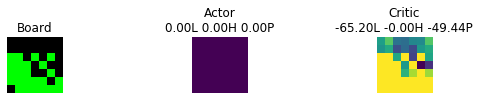

 56%|█████▌    | 555/1000 [2:46:20<1:54:12, 15.40s/it]

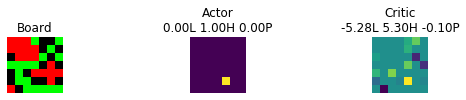

 56%|█████▌    | 556/1000 [2:46:33<1:48:15, 14.63s/it]

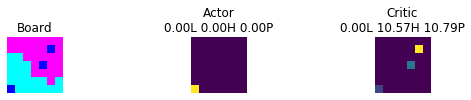

 56%|█████▌    | 557/1000 [2:46:52<1:57:45, 15.95s/it]

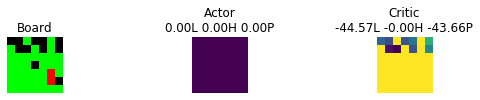

 56%|█████▌    | 558/1000 [2:47:05<1:50:16, 14.97s/it]

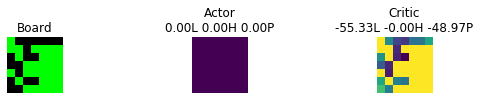

 56%|█████▌    | 559/1000 [2:47:17<1:44:13, 14.18s/it]

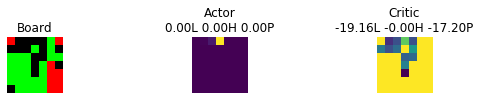

 56%|█████▌    | 560/1000 [2:47:30<1:40:39, 13.73s/it]

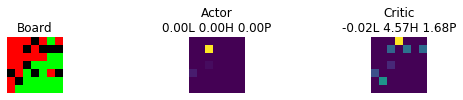

 56%|█████▌    | 561/1000 [2:47:43<1:40:00, 13.67s/it]

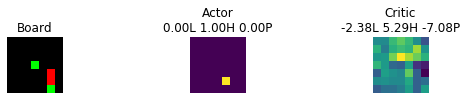

 56%|█████▌    | 562/1000 [2:47:58<1:42:25, 14.03s/it]

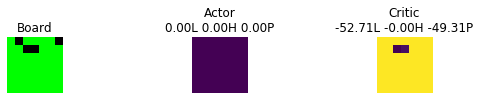

 56%|█████▋    | 563/1000 [2:48:11<1:38:20, 13.50s/it]

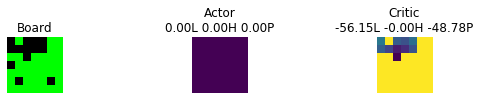

 56%|█████▋    | 564/1000 [2:48:23<1:36:01, 13.22s/it]

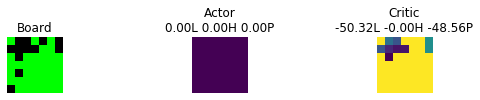

 56%|█████▋    | 565/1000 [2:48:36<1:35:05, 13.12s/it]

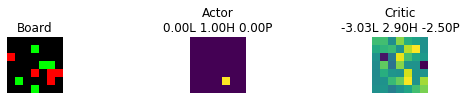

 57%|█████▋    | 566/1000 [2:48:57<1:51:39, 15.44s/it]

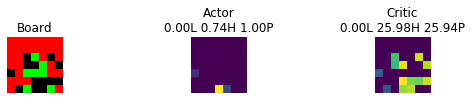

 57%|█████▋    | 567/1000 [2:49:18<2:02:46, 17.01s/it]

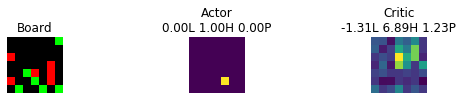

 57%|█████▋    | 568/1000 [2:49:26<1:44:31, 14.52s/it]

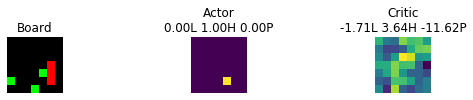

 57%|█████▋    | 569/1000 [2:49:40<1:42:41, 14.30s/it]

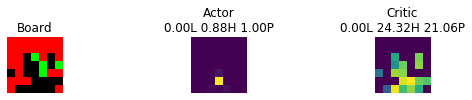

 57%|█████▋    | 570/1000 [2:49:52<1:38:01, 13.68s/it]

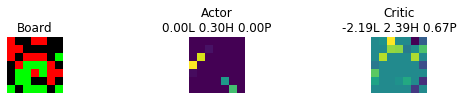

 57%|█████▋    | 571/1000 [2:50:04<1:34:31, 13.22s/it]

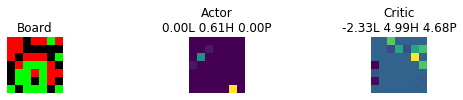

 57%|█████▋    | 572/1000 [2:50:17<1:32:37, 12.98s/it]

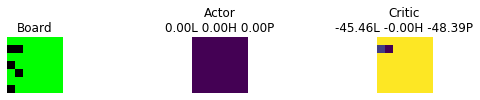

 57%|█████▋    | 573/1000 [2:50:28<1:28:45, 12.47s/it]

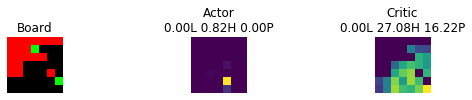

 57%|█████▋    | 574/1000 [2:50:41<1:30:22, 12.73s/it]

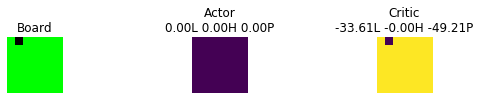

 57%|█████▊    | 575/1000 [2:50:54<1:28:50, 12.54s/it]

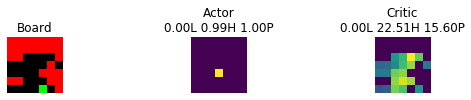

 58%|█████▊    | 576/1000 [2:51:06<1:29:15, 12.63s/it]

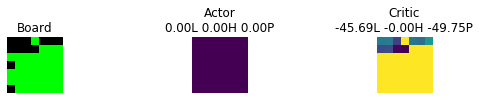

 58%|█████▊    | 577/1000 [2:51:32<1:55:40, 16.41s/it]

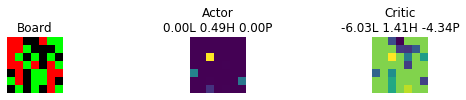

 58%|█████▊    | 578/1000 [2:51:45<1:48:50, 15.47s/it]

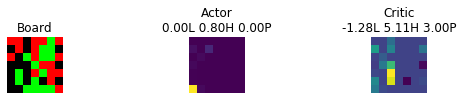

 58%|█████▊    | 579/1000 [2:51:57<1:42:03, 14.55s/it]

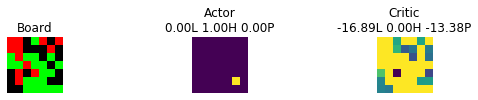

 58%|█████▊    | 580/1000 [2:52:19<1:56:50, 16.69s/it]

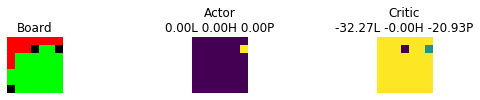

 58%|█████▊    | 581/1000 [2:52:42<2:10:25, 18.68s/it]

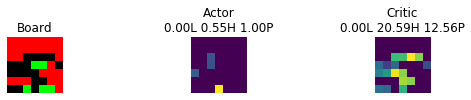

 58%|█████▊    | 582/1000 [2:53:08<2:24:28, 20.74s/it]

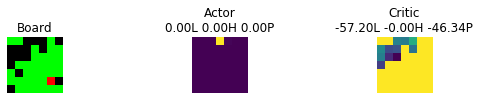

 58%|█████▊    | 583/1000 [2:53:29<2:24:06, 20.73s/it]

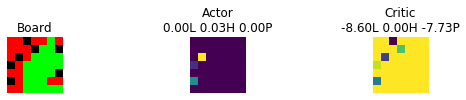

 58%|█████▊    | 584/1000 [2:53:36<1:56:47, 16.84s/it]

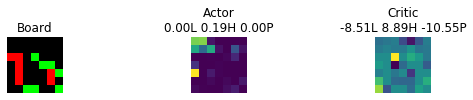

 58%|█████▊    | 585/1000 [2:54:04<2:18:06, 19.97s/it]

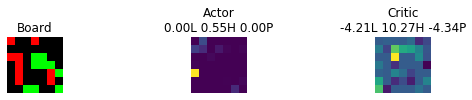

 59%|█████▊    | 586/1000 [2:54:16<2:02:00, 17.68s/it]

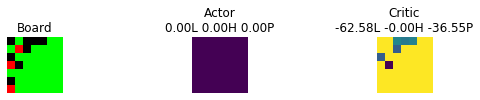

 59%|█████▊    | 587/1000 [2:54:29<1:52:04, 16.28s/it]

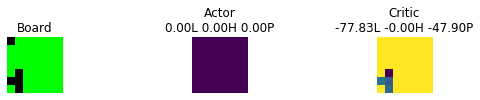

 59%|█████▉    | 588/1000 [2:54:42<1:44:29, 15.22s/it]

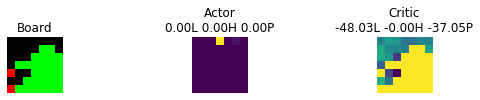

 59%|█████▉    | 589/1000 [2:55:06<2:02:27, 17.88s/it]

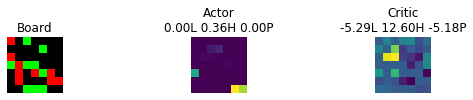

 59%|█████▉    | 590/1000 [2:55:18<1:50:22, 16.15s/it]

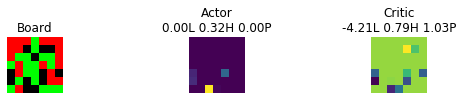

 59%|█████▉    | 591/1000 [2:55:33<1:48:51, 15.97s/it]

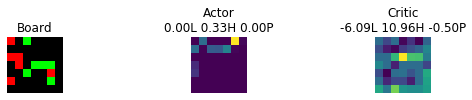

 59%|█████▉    | 592/1000 [2:55:46<1:41:03, 14.86s/it]

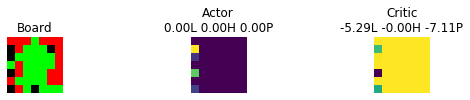

 59%|█████▉    | 593/1000 [2:55:58<1:35:20, 14.05s/it]

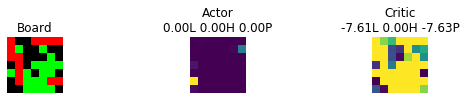

 59%|█████▉    | 594/1000 [2:56:10<1:31:50, 13.57s/it]

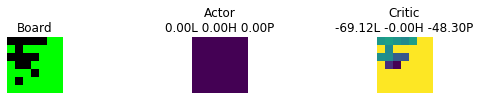

 60%|█████▉    | 595/1000 [2:56:23<1:29:00, 13.19s/it]

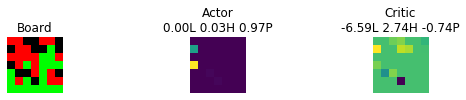

 60%|█████▉    | 596/1000 [2:56:36<1:28:14, 13.10s/it]

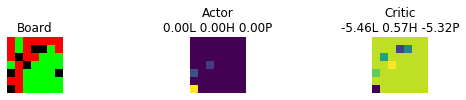

 60%|█████▉    | 597/1000 [2:56:49<1:27:43, 13.06s/it]

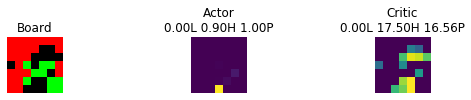

 60%|█████▉    | 598/1000 [2:57:01<1:26:45, 12.95s/it]

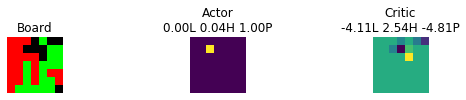

 60%|█████▉    | 599/1000 [2:57:13<1:25:04, 12.73s/it]

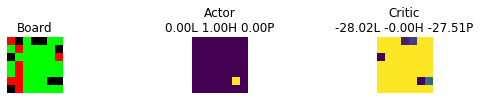

 60%|██████    | 600/1000 [2:57:26<1:24:11, 12.63s/it]I0720 20:30:10.556262 4623369664 <ipython-input-34-fc3bfac52b9e>:10] Updated opponent


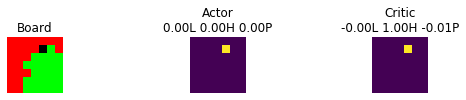

 60%|██████    | 601/1000 [2:57:49<1:45:50, 15.92s/it]

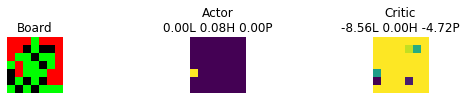

 60%|██████    | 602/1000 [2:58:06<1:46:45, 16.09s/it]

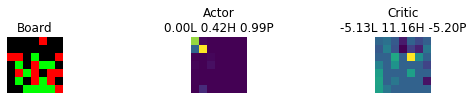

 60%|██████    | 603/1000 [2:58:32<2:07:06, 19.21s/it]

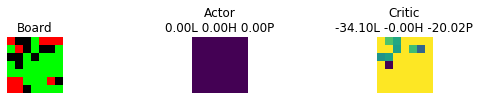

 60%|██████    | 604/1000 [2:58:49<2:01:29, 18.41s/it]

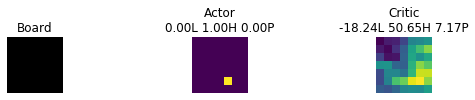

 60%|██████    | 605/1000 [2:59:01<1:49:03, 16.57s/it]

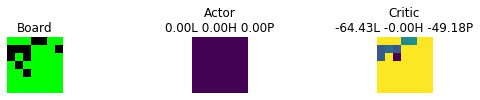

 61%|██████    | 606/1000 [2:59:15<1:42:26, 15.60s/it]

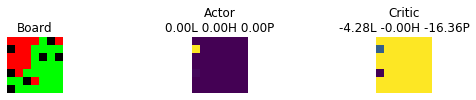

 61%|██████    | 607/1000 [2:59:23<1:27:19, 13.33s/it]

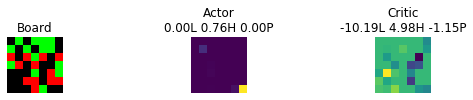

 61%|██████    | 608/1000 [2:59:43<1:40:19, 15.36s/it]

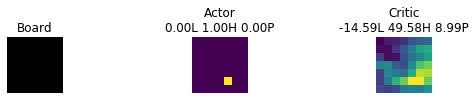

 61%|██████    | 609/1000 [3:00:03<1:48:58, 16.72s/it]

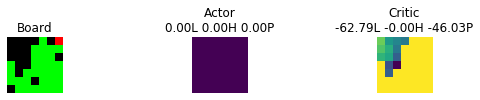

 61%|██████    | 610/1000 [3:00:19<1:47:23, 16.52s/it]

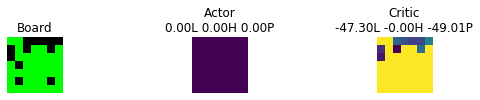

 61%|██████    | 611/1000 [3:00:32<1:40:07, 15.44s/it]

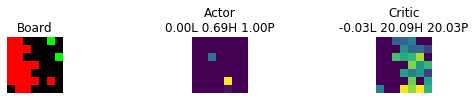

 61%|██████    | 612/1000 [3:00:44<1:34:11, 14.57s/it]

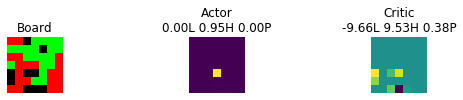

 61%|██████▏   | 613/1000 [3:01:03<1:43:13, 16.00s/it]

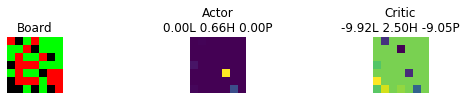

 61%|██████▏   | 614/1000 [3:01:16<1:36:53, 15.06s/it]

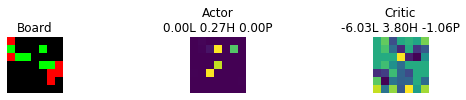

 62%|██████▏   | 615/1000 [3:01:29<1:32:44, 14.45s/it]

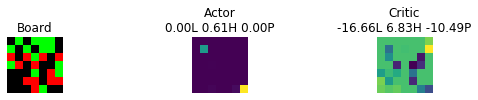

 62%|██████▏   | 616/1000 [3:01:43<1:30:13, 14.10s/it]

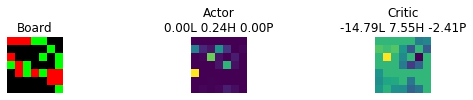

 62%|██████▏   | 617/1000 [3:02:11<1:57:02, 18.33s/it]

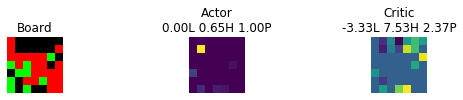

 62%|██████▏   | 618/1000 [3:02:21<1:41:18, 15.91s/it]

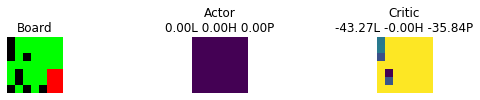

 62%|██████▏   | 619/1000 [3:02:41<1:49:19, 17.22s/it]

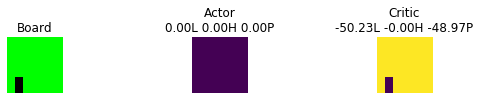

 62%|██████▏   | 620/1000 [3:03:06<2:02:47, 19.39s/it]

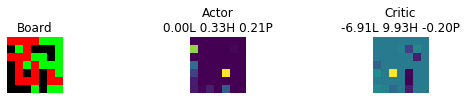

 62%|██████▏   | 621/1000 [3:03:19<1:50:35, 17.51s/it]

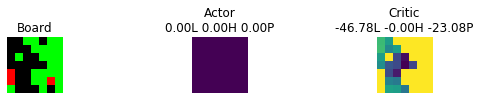

 62%|██████▏   | 622/1000 [3:03:36<1:48:57, 17.29s/it]

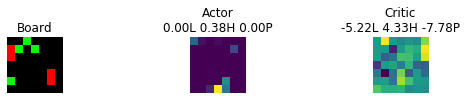

 62%|██████▏   | 623/1000 [3:03:44<1:31:31, 14.57s/it]

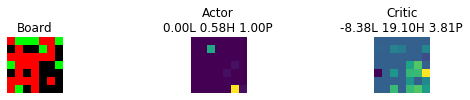

 62%|██████▏   | 624/1000 [3:04:11<1:55:03, 18.36s/it]

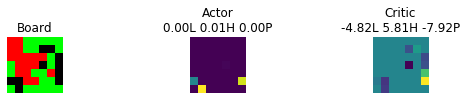

 62%|██████▎   | 625/1000 [3:04:25<1:46:22, 17.02s/it]

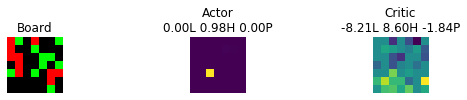

 63%|██████▎   | 626/1000 [3:04:34<1:30:30, 14.52s/it]

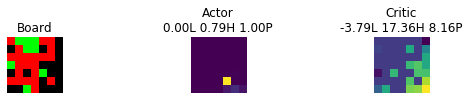

 63%|██████▎   | 627/1000 [3:04:47<1:27:31, 14.08s/it]

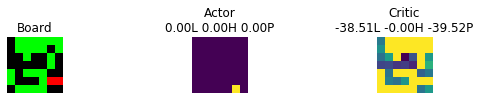

 63%|██████▎   | 628/1000 [3:05:00<1:26:30, 13.95s/it]

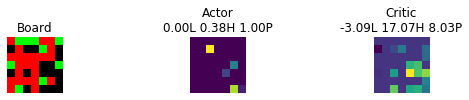

 63%|██████▎   | 629/1000 [3:05:07<1:13:32, 11.89s/it]

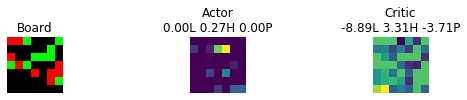

 63%|██████▎   | 630/1000 [3:05:37<1:45:29, 17.11s/it]

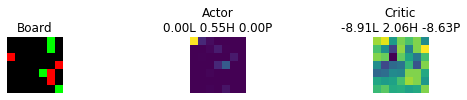

 63%|██████▎   | 631/1000 [3:05:44<1:27:11, 14.18s/it]

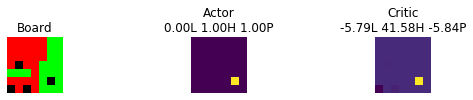

 63%|██████▎   | 632/1000 [3:05:52<1:15:22, 12.29s/it]

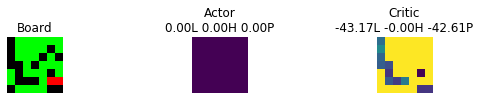

 63%|██████▎   | 633/1000 [3:06:04<1:15:32, 12.35s/it]

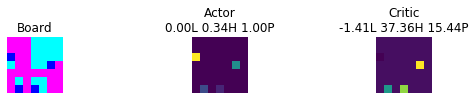

 63%|██████▎   | 634/1000 [3:06:45<2:07:37, 20.92s/it]

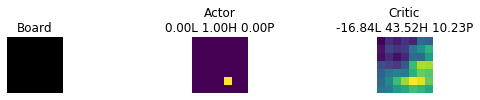

 64%|██████▎   | 635/1000 [3:07:26<2:43:48, 26.93s/it]

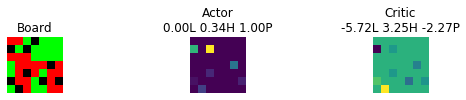

 64%|██████▎   | 636/1000 [3:07:36<2:11:49, 21.73s/it]

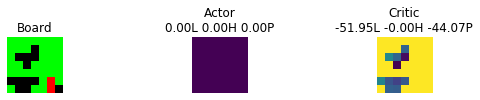

 64%|██████▎   | 637/1000 [3:08:15<2:42:31, 26.86s/it]

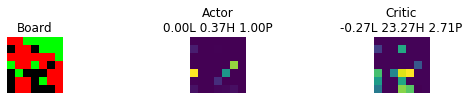

 64%|██████▍   | 638/1000 [3:08:25<2:12:21, 21.94s/it]

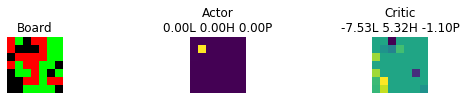

 64%|██████▍   | 639/1000 [3:08:38<1:54:51, 19.09s/it]

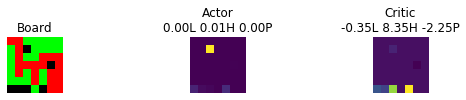

 64%|██████▍   | 640/1000 [3:08:58<1:57:31, 19.59s/it]

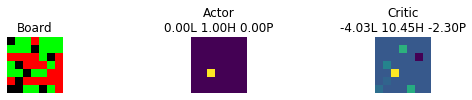

 64%|██████▍   | 641/1000 [3:09:18<1:56:46, 19.52s/it]

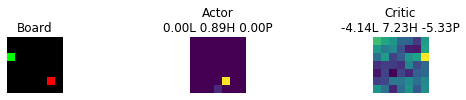

 64%|██████▍   | 642/1000 [3:09:29<1:40:42, 16.88s/it]

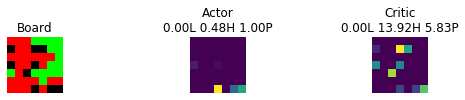

 64%|██████▍   | 643/1000 [3:09:37<1:25:58, 14.45s/it]

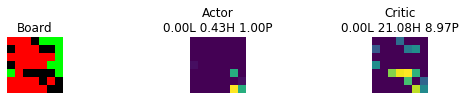

 64%|██████▍   | 644/1000 [3:10:06<1:50:37, 18.64s/it]

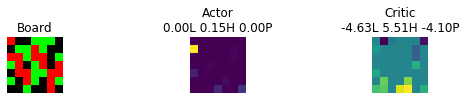

 64%|██████▍   | 645/1000 [3:10:17<1:36:21, 16.29s/it]

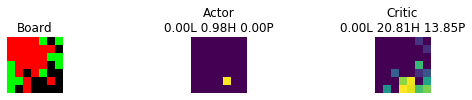

 65%|██████▍   | 646/1000 [3:10:30<1:30:30, 15.34s/it]

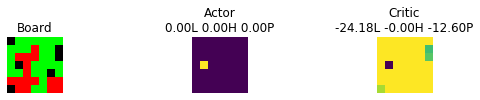

 65%|██████▍   | 647/1000 [3:10:38<1:18:30, 13.34s/it]

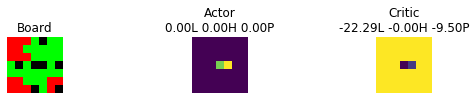

 65%|██████▍   | 648/1000 [3:10:51<1:16:45, 13.08s/it]

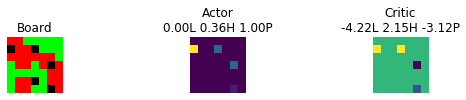

 65%|██████▍   | 649/1000 [3:11:06<1:20:05, 13.69s/it]

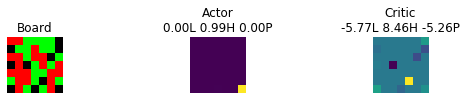

 65%|██████▌   | 650/1000 [3:11:20<1:20:12, 13.75s/it]

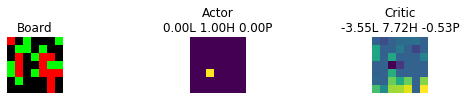

 65%|██████▌   | 651/1000 [3:11:41<1:33:49, 16.13s/it]

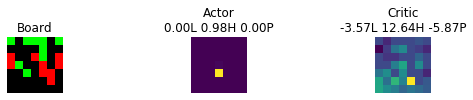

 65%|██████▌   | 652/1000 [3:11:57<1:32:14, 15.90s/it]

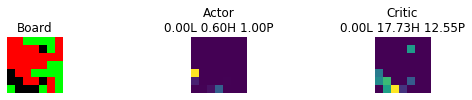

 65%|██████▌   | 653/1000 [3:12:12<1:30:54, 15.72s/it]

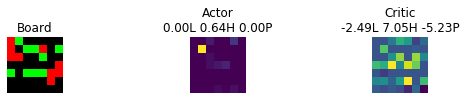

 65%|██████▌   | 654/1000 [3:12:26<1:26:39, 15.03s/it]

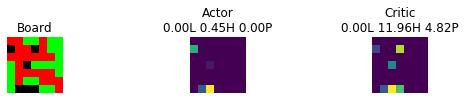

 66%|██████▌   | 655/1000 [3:12:42<1:29:30, 15.57s/it]

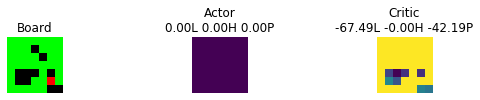

 66%|██████▌   | 656/1000 [3:12:56<1:26:24, 15.07s/it]

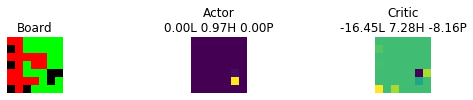

 66%|██████▌   | 657/1000 [3:13:08<1:19:55, 13.98s/it]

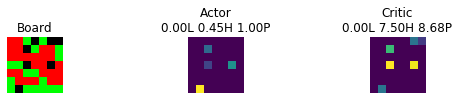

 66%|██████▌   | 658/1000 [3:13:19<1:14:32, 13.08s/it]

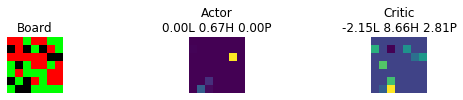

 66%|██████▌   | 659/1000 [3:13:31<1:12:37, 12.78s/it]

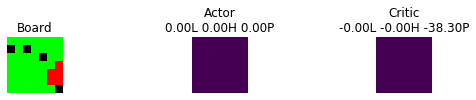

 66%|██████▌   | 660/1000 [3:13:39<1:04:48, 11.44s/it]

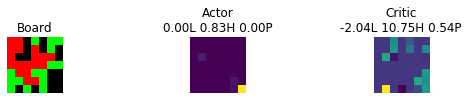

 66%|██████▌   | 661/1000 [3:13:58<1:16:28, 13.53s/it]

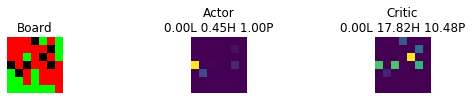

 66%|██████▌   | 662/1000 [3:14:08<1:10:48, 12.57s/it]

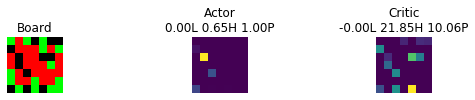

 66%|██████▋   | 663/1000 [3:14:21<1:11:45, 12.78s/it]

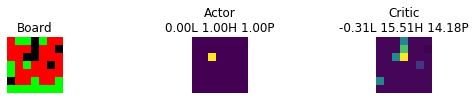

 66%|██████▋   | 664/1000 [3:14:35<1:12:37, 12.97s/it]

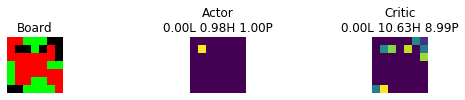

 66%|██████▋   | 665/1000 [3:14:47<1:11:03, 12.73s/it]

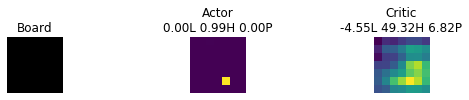

 67%|██████▋   | 666/1000 [3:15:01<1:12:58, 13.11s/it]

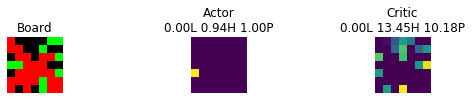

 67%|██████▋   | 667/1000 [3:15:23<1:28:06, 15.88s/it]

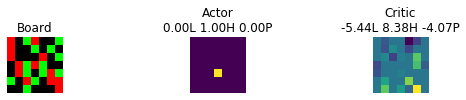

 67%|██████▋   | 668/1000 [3:15:45<1:37:28, 17.62s/it]

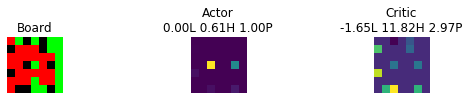

 67%|██████▋   | 669/1000 [3:16:12<1:53:28, 20.57s/it]

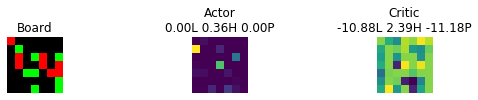

 67%|██████▋   | 670/1000 [3:16:26<1:42:44, 18.68s/it]

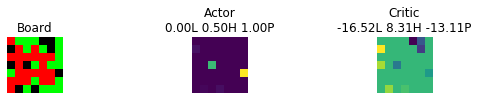

 67%|██████▋   | 671/1000 [3:16:39<1:31:35, 16.70s/it]

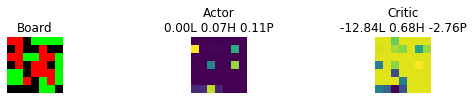

 67%|██████▋   | 672/1000 [3:16:52<1:26:40, 15.86s/it]

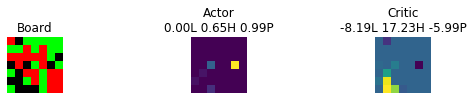

 67%|██████▋   | 673/1000 [3:17:05<1:20:33, 14.78s/it]

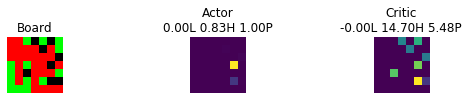

 67%|██████▋   | 674/1000 [3:17:15<1:13:42, 13.57s/it]

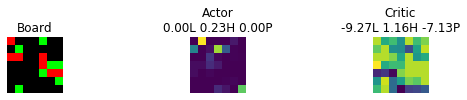

 68%|██████▊   | 675/1000 [3:17:23<1:03:02, 11.64s/it]

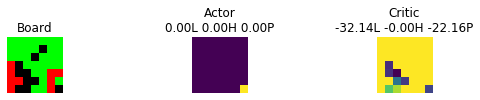

 68%|██████▊   | 676/1000 [3:17:45<1:19:49, 14.78s/it]

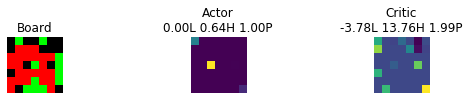

 68%|██████▊   | 677/1000 [3:18:07<1:32:10, 17.12s/it]

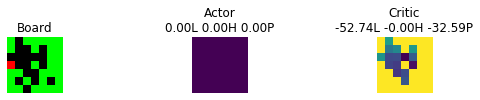

 68%|██████▊   | 678/1000 [3:18:30<1:41:27, 18.90s/it]

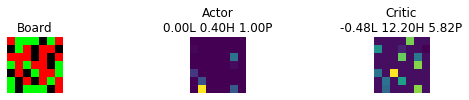

 68%|██████▊   | 679/1000 [3:18:56<1:52:40, 21.06s/it]

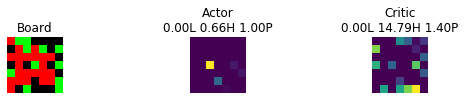

 68%|██████▊   | 680/1000 [3:19:09<1:39:18, 18.62s/it]

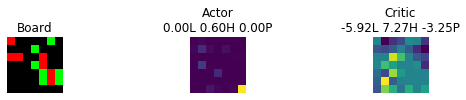

 68%|██████▊   | 681/1000 [3:19:23<1:30:45, 17.07s/it]

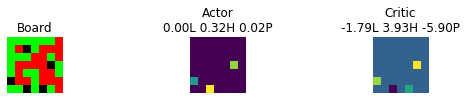

 68%|██████▊   | 682/1000 [3:19:33<1:19:05, 14.92s/it]

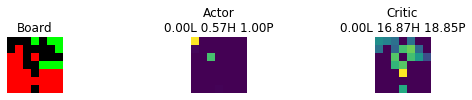

 68%|██████▊   | 683/1000 [3:19:42<1:09:36, 13.18s/it]

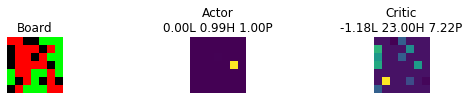

 68%|██████▊   | 684/1000 [3:20:17<1:44:26, 19.83s/it]

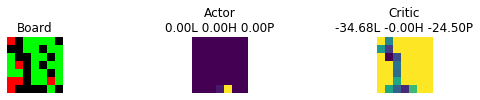

 68%|██████▊   | 685/1000 [3:20:25<1:25:21, 16.26s/it]

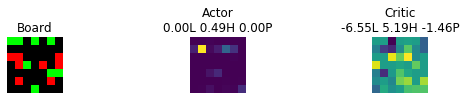

 69%|██████▊   | 686/1000 [3:20:33<1:12:33, 13.86s/it]

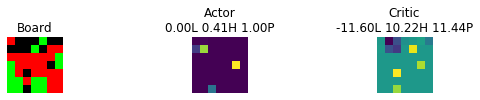

 69%|██████▊   | 687/1000 [3:21:01<1:33:53, 18.00s/it]

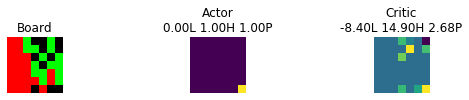

 69%|██████▉   | 688/1000 [3:21:09<1:18:10, 15.03s/it]

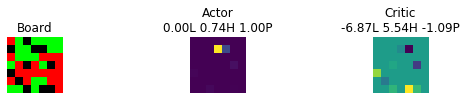

 69%|██████▉   | 689/1000 [3:21:21<1:13:42, 14.22s/it]

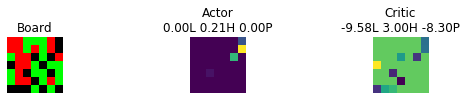

 69%|██████▉   | 690/1000 [3:21:39<1:18:15, 15.15s/it]

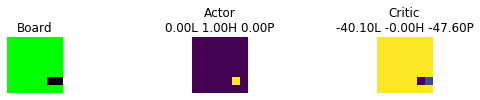

 69%|██████▉   | 691/1000 [3:22:03<1:31:53, 17.84s/it]

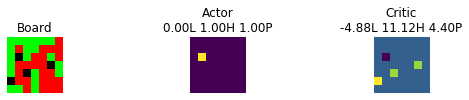

 69%|██████▉   | 692/1000 [3:22:14<1:20:38, 15.71s/it]

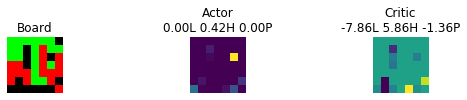

 69%|██████▉   | 693/1000 [3:22:26<1:16:03, 14.86s/it]

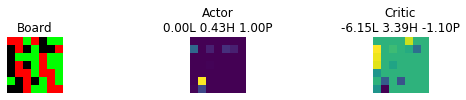

 69%|██████▉   | 694/1000 [3:22:46<1:23:32, 16.38s/it]

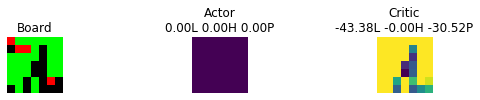

 70%|██████▉   | 695/1000 [3:22:59<1:17:05, 15.16s/it]

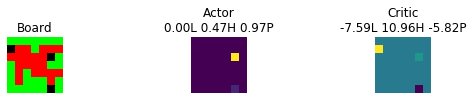

 70%|██████▉   | 696/1000 [3:23:23<1:30:12, 17.80s/it]

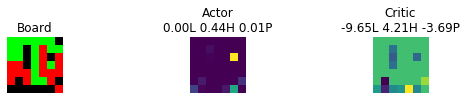

 70%|██████▉   | 697/1000 [3:23:33<1:18:16, 15.50s/it]

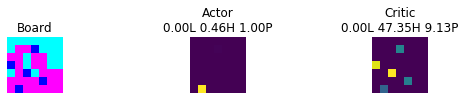

 70%|██████▉   | 698/1000 [3:23:46<1:14:36, 14.82s/it]

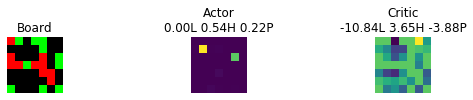

 70%|██████▉   | 699/1000 [3:23:59<1:11:21, 14.23s/it]

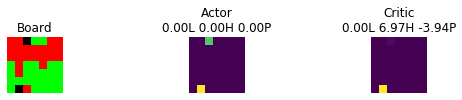

 70%|███████   | 700/1000 [3:24:12<1:09:12, 13.84s/it]I0720 20:56:56.618968 4623369664 <ipython-input-34-fc3bfac52b9e>:10] Updated opponent


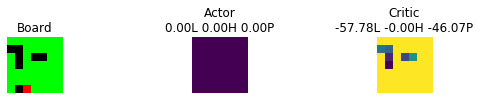

 70%|███████   | 701/1000 [3:24:44<1:36:57, 19.46s/it]

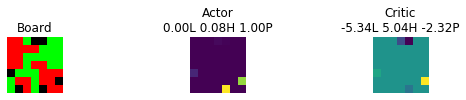

 70%|███████   | 702/1000 [3:24:53<1:20:22, 16.18s/it]

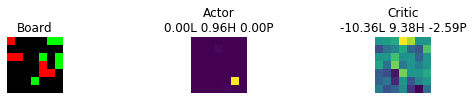

 70%|███████   | 703/1000 [3:25:18<1:33:11, 18.83s/it]

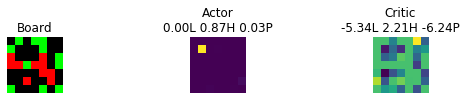

 70%|███████   | 704/1000 [3:25:39<1:36:53, 19.64s/it]

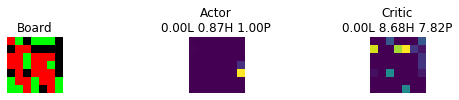

 70%|███████   | 705/1000 [3:25:53<1:28:06, 17.92s/it]

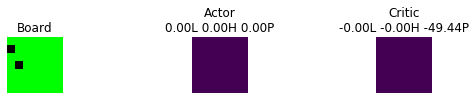

 71%|███████   | 706/1000 [3:26:08<1:23:10, 16.98s/it]

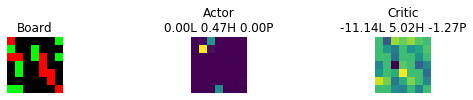

 71%|███████   | 707/1000 [3:26:20<1:14:52, 15.33s/it]

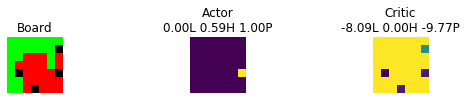

 71%|███████   | 708/1000 [3:26:30<1:07:43, 13.92s/it]

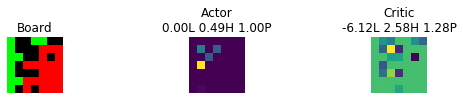

 71%|███████   | 709/1000 [3:26:47<1:11:45, 14.80s/it]

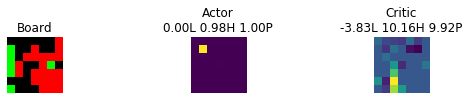

 71%|███████   | 710/1000 [3:27:06<1:17:36, 16.06s/it]

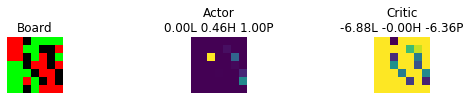

 71%|███████   | 711/1000 [3:27:41<1:44:22, 21.67s/it]

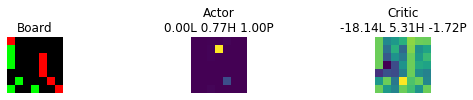

 71%|███████   | 712/1000 [3:27:54<1:31:26, 19.05s/it]

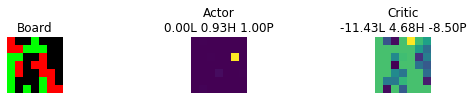

 71%|███████▏  | 713/1000 [3:28:06<1:21:39, 17.07s/it]

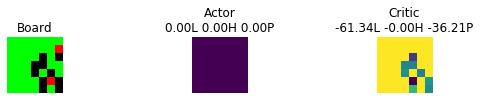

 71%|███████▏  | 714/1000 [3:28:14<1:08:35, 14.39s/it]

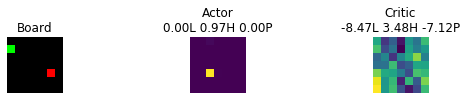

 72%|███████▏  | 715/1000 [3:28:27<1:05:17, 13.74s/it]

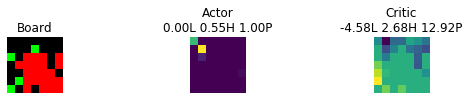

 72%|███████▏  | 716/1000 [3:28:35<57:58, 12.25s/it]  

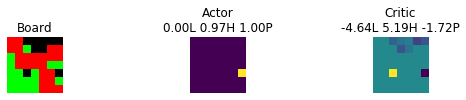

 72%|███████▏  | 717/1000 [3:28:45<53:57, 11.44s/it]

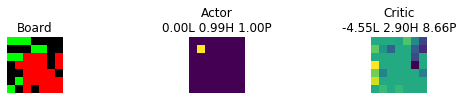

 72%|███████▏  | 718/1000 [3:28:53<48:33, 10.33s/it]

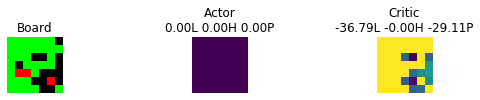

 72%|███████▏  | 719/1000 [3:29:05<50:55, 10.87s/it]

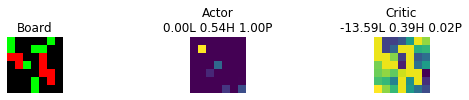

 72%|███████▏  | 720/1000 [3:29:20<56:13, 12.05s/it]

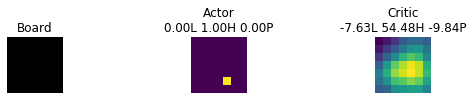

 72%|███████▏  | 721/1000 [3:29:44<1:12:52, 15.67s/it]

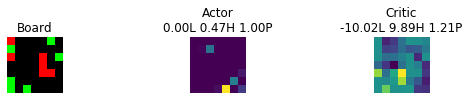

 72%|███████▏  | 722/1000 [3:29:52<1:02:14, 13.43s/it]

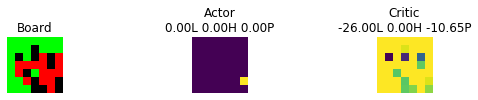

 72%|███████▏  | 723/1000 [3:30:04<1:00:43, 13.15s/it]

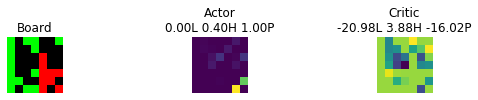

 72%|███████▏  | 724/1000 [3:30:17<59:19, 12.90s/it]  

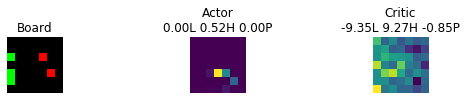

 72%|███████▎  | 725/1000 [3:30:36<1:07:30, 14.73s/it]

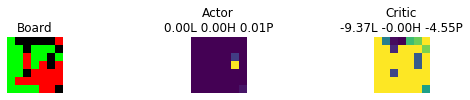

 73%|███████▎  | 726/1000 [3:30:59<1:18:55, 17.28s/it]

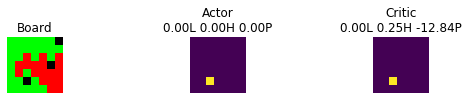

 73%|███████▎  | 727/1000 [3:31:31<1:38:21, 21.62s/it]

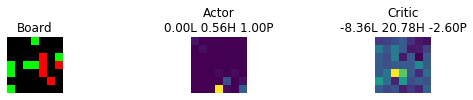

 73%|███████▎  | 728/1000 [3:31:43<1:25:26, 18.85s/it]

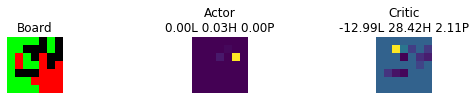

 73%|███████▎  | 729/1000 [3:31:56<1:17:07, 17.08s/it]

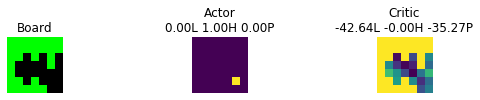

 73%|███████▎  | 730/1000 [3:32:20<1:26:40, 19.26s/it]

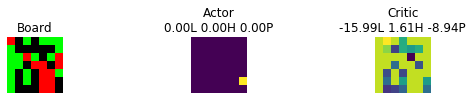

 73%|███████▎  | 731/1000 [3:32:58<1:50:19, 24.61s/it]

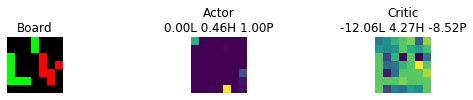

 73%|███████▎  | 732/1000 [3:33:07<1:29:30, 20.04s/it]

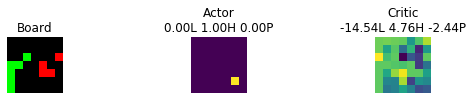

 73%|███████▎  | 733/1000 [3:33:21<1:21:47, 18.38s/it]

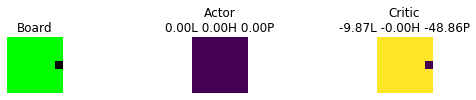

 73%|███████▎  | 734/1000 [3:33:31<1:09:54, 15.77s/it]

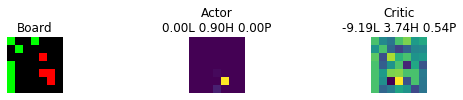

 74%|███████▎  | 735/1000 [3:33:43<1:05:01, 14.72s/it]

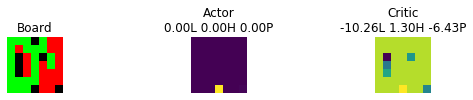

 74%|███████▎  | 736/1000 [3:33:56<1:02:37, 14.23s/it]

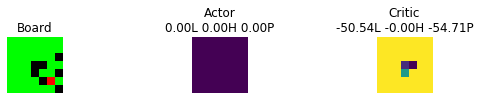

 74%|███████▎  | 737/1000 [3:34:09<59:33, 13.59s/it]  

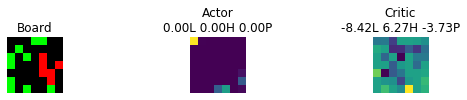

 74%|███████▍  | 738/1000 [3:34:21<58:22, 13.37s/it]

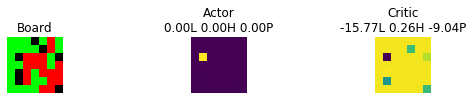

 74%|███████▍  | 739/1000 [3:34:34<57:40, 13.26s/it]

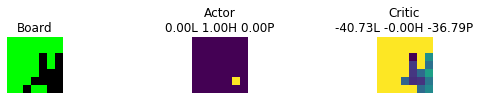

 74%|███████▍  | 740/1000 [3:34:48<57:19, 13.23s/it]

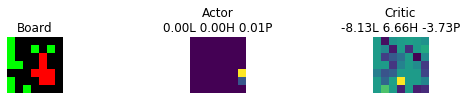

 74%|███████▍  | 741/1000 [3:35:02<58:17, 13.50s/it]

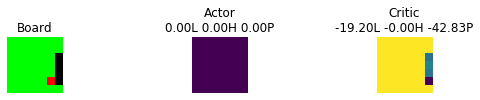

 74%|███████▍  | 742/1000 [3:35:21<1:05:02, 15.12s/it]

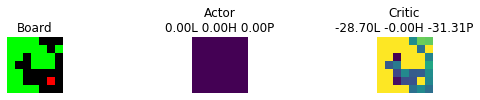

 74%|███████▍  | 743/1000 [3:35:33<1:01:13, 14.29s/it]

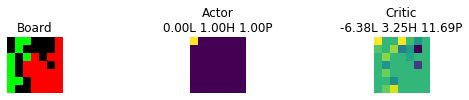

 74%|███████▍  | 744/1000 [3:35:45<58:27, 13.70s/it]  

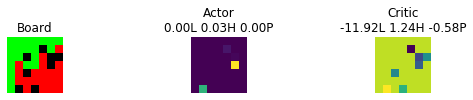

 74%|███████▍  | 745/1000 [3:35:58<56:47, 13.36s/it]

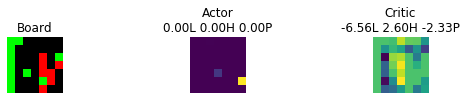

 75%|███████▍  | 746/1000 [3:36:10<55:34, 13.13s/it]

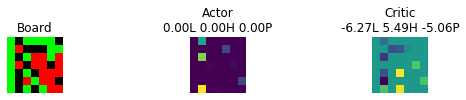

 75%|███████▍  | 747/1000 [3:36:35<1:10:06, 16.62s/it]

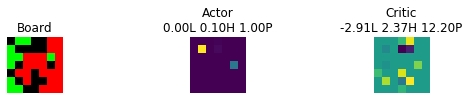

 75%|███████▍  | 748/1000 [3:36:47<1:04:10, 15.28s/it]

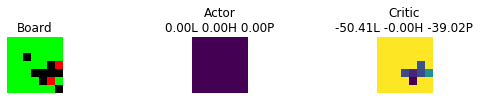

 75%|███████▍  | 749/1000 [3:37:28<1:36:07, 22.98s/it]

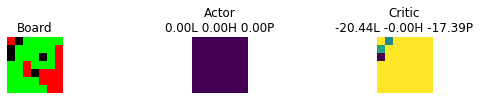

 75%|███████▌  | 750/1000 [3:37:38<1:19:02, 18.97s/it]

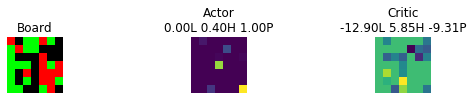

 75%|███████▌  | 751/1000 [3:37:52<1:12:02, 17.36s/it]

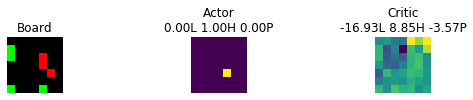

 75%|███████▌  | 752/1000 [3:38:23<1:29:13, 21.58s/it]

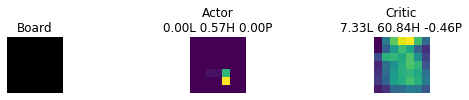

 75%|███████▌  | 753/1000 [3:38:36<1:18:48, 19.15s/it]

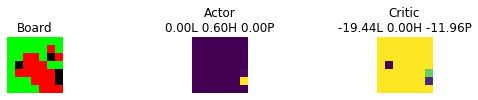

 75%|███████▌  | 754/1000 [3:38:59<1:22:19, 20.08s/it]

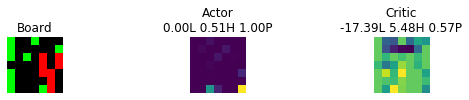

 76%|███████▌  | 755/1000 [3:39:11<1:13:00, 17.88s/it]

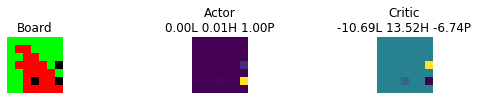

 76%|███████▌  | 756/1000 [3:39:19<1:00:30, 14.88s/it]

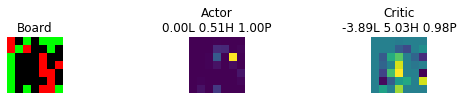

 76%|███████▌  | 757/1000 [3:39:32<58:07, 14.35s/it]  

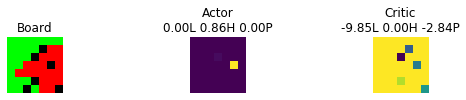

 76%|███████▌  | 758/1000 [3:39:46<57:02, 14.14s/it]

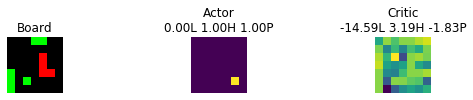

 76%|███████▌  | 759/1000 [3:40:23<1:24:17, 20.99s/it]

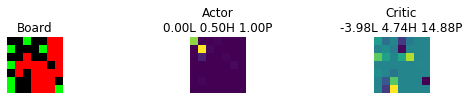

 76%|███████▌  | 760/1000 [3:40:43<1:23:18, 20.83s/it]

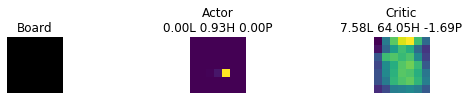

 76%|███████▌  | 761/1000 [3:40:54<1:10:29, 17.70s/it]

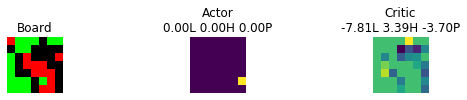

 76%|███████▌  | 762/1000 [3:41:07<1:04:44, 16.32s/it]

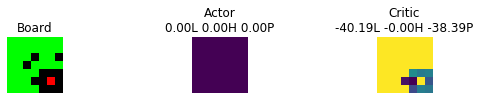

 76%|███████▋  | 763/1000 [3:41:16<56:12, 14.23s/it]  

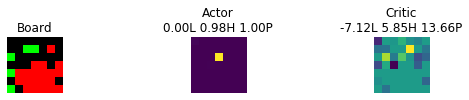

 76%|███████▋  | 764/1000 [3:41:32<57:42, 14.67s/it]

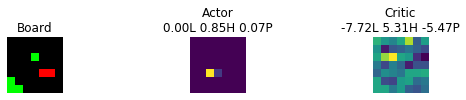

 76%|███████▋  | 765/1000 [3:41:47<58:13, 14.87s/it]

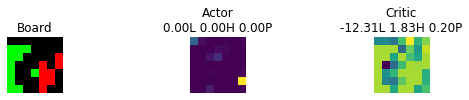

 77%|███████▋  | 766/1000 [3:42:04<59:37, 15.29s/it]

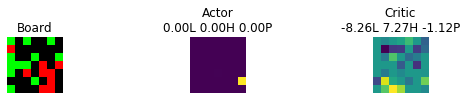

 77%|███████▋  | 767/1000 [3:42:13<52:54, 13.62s/it]

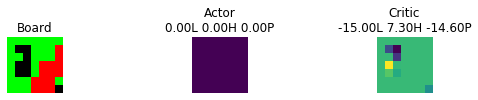

 77%|███████▋  | 768/1000 [3:42:26<51:21, 13.28s/it]

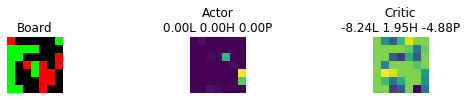

 77%|███████▋  | 769/1000 [3:42:51<1:04:43, 16.81s/it]

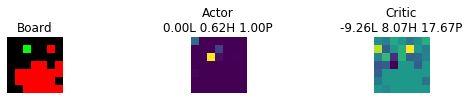

 77%|███████▋  | 770/1000 [3:43:15<1:12:18, 18.86s/it]

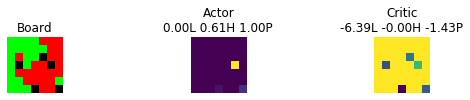

 77%|███████▋  | 771/1000 [3:43:34<1:12:11, 18.91s/it]

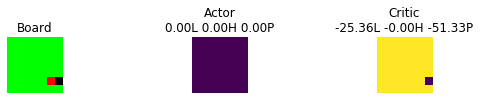

 77%|███████▋  | 772/1000 [3:43:41<58:56, 15.51s/it]  

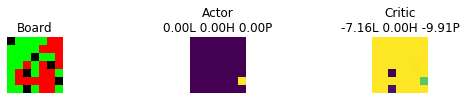

 77%|███████▋  | 773/1000 [3:44:01<1:03:36, 16.81s/it]

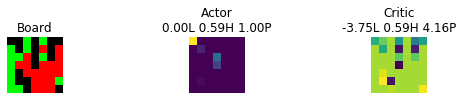

 77%|███████▋  | 774/1000 [3:44:20<1:05:22, 17.36s/it]

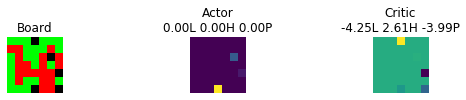

 78%|███████▊  | 775/1000 [3:44:32<59:27, 15.85s/it]  

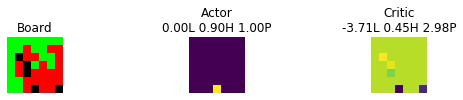

 78%|███████▊  | 776/1000 [3:45:09<1:22:41, 22.15s/it]

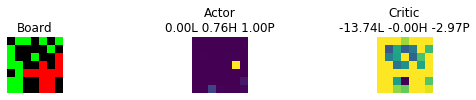

 78%|███████▊  | 777/1000 [3:45:22<1:11:53, 19.34s/it]

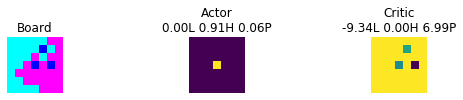

 78%|███████▊  | 778/1000 [3:45:41<1:11:52, 19.42s/it]

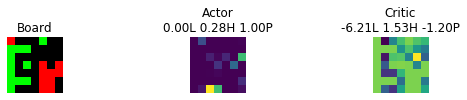

 78%|███████▊  | 779/1000 [3:45:54<1:04:04, 17.40s/it]

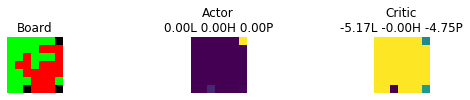

 78%|███████▊  | 780/1000 [3:46:11<1:03:31, 17.32s/it]

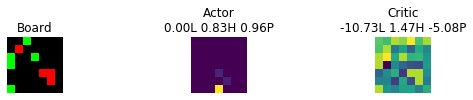

 78%|███████▊  | 781/1000 [3:46:24<58:27, 16.02s/it]  

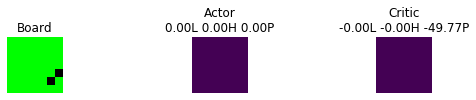

 78%|███████▊  | 782/1000 [3:47:06<1:26:01, 23.68s/it]

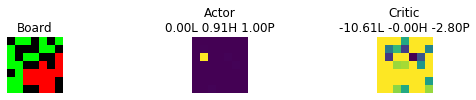

 78%|███████▊  | 783/1000 [3:47:26<1:21:56, 22.66s/it]

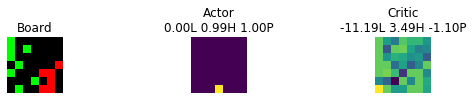

 78%|███████▊  | 784/1000 [3:47:58<1:31:17, 25.36s/it]

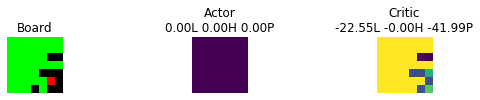

 78%|███████▊  | 785/1000 [3:48:10<1:17:13, 21.55s/it]

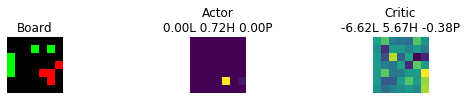

 79%|███████▊  | 786/1000 [3:48:23<1:07:14, 18.85s/it]

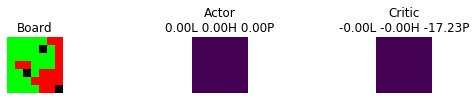

 79%|███████▊  | 787/1000 [3:49:04<1:31:18, 25.72s/it]

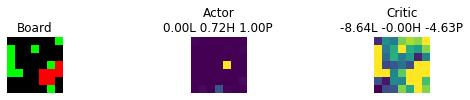

 79%|███████▉  | 788/1000 [3:49:29<1:29:40, 25.38s/it]

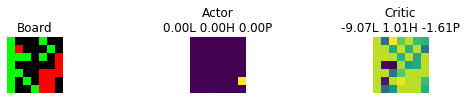

 79%|███████▉  | 789/1000 [3:49:43<1:17:16, 21.97s/it]

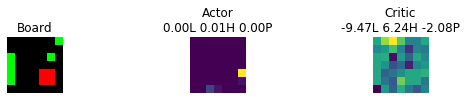

 79%|███████▉  | 790/1000 [3:49:56<1:07:40, 19.34s/it]

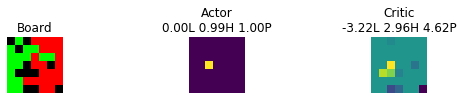

 79%|███████▉  | 791/1000 [3:50:08<59:51, 17.19s/it]  

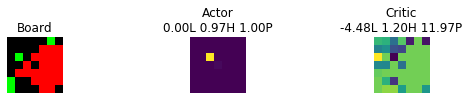

 79%|███████▉  | 792/1000 [3:50:43<1:17:20, 22.31s/it]

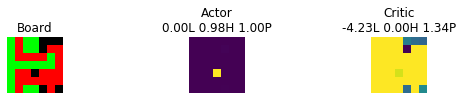

 79%|███████▉  | 793/1000 [3:50:51<1:02:04, 17.99s/it]

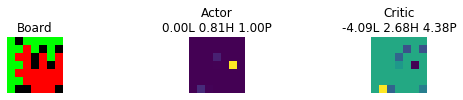

 79%|███████▉  | 794/1000 [3:51:10<1:03:33, 18.51s/it]

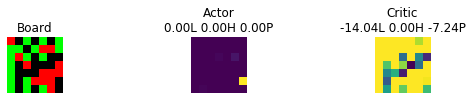

 80%|███████▉  | 795/1000 [3:51:29<1:03:29, 18.58s/it]

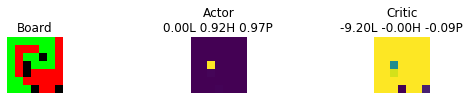

 80%|███████▉  | 796/1000 [3:51:53<1:08:49, 20.24s/it]

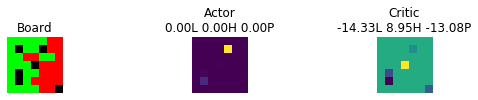

 80%|███████▉  | 797/1000 [3:52:05<1:00:21, 17.84s/it]

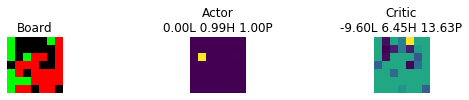

 80%|███████▉  | 798/1000 [3:52:38<1:14:38, 22.17s/it]

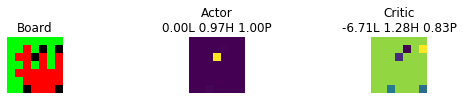

 80%|███████▉  | 799/1000 [3:52:56<1:10:29, 21.04s/it]

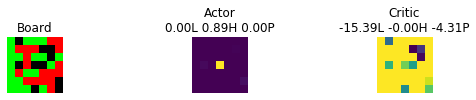

 80%|████████  | 800/1000 [3:53:09<1:02:16, 18.68s/it]I0720 21:25:54.127832 4623369664 <ipython-input-34-fc3bfac52b9e>:10] Updated opponent


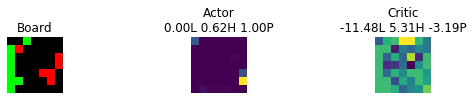

 80%|████████  | 801/1000 [3:53:29<1:03:15, 19.07s/it]

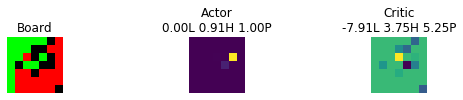

 80%|████████  | 802/1000 [3:53:42<56:45, 17.20s/it]  

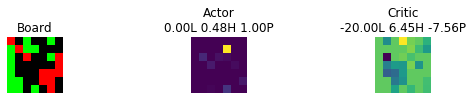

 80%|████████  | 803/1000 [3:54:02<58:39, 17.87s/it]

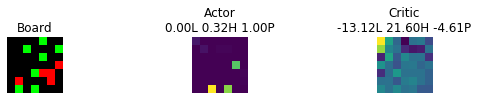

 80%|████████  | 804/1000 [3:54:13<52:23, 16.04s/it]

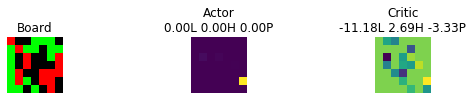

 80%|████████  | 805/1000 [3:54:24<47:13, 14.53s/it]

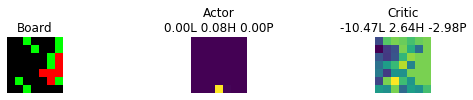

 81%|████████  | 806/1000 [3:54:38<46:23, 14.35s/it]

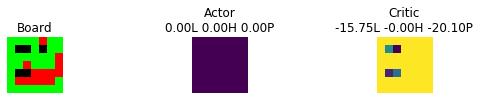

 81%|████████  | 807/1000 [3:54:55<48:23, 15.04s/it]

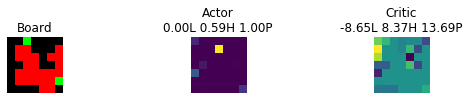

 81%|████████  | 808/1000 [3:55:07<44:57, 14.05s/it]

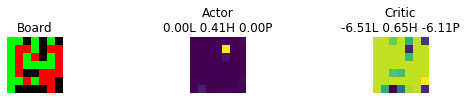

 81%|████████  | 809/1000 [3:55:31<54:31, 17.13s/it]

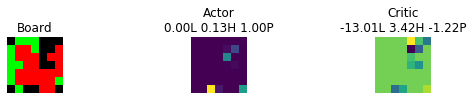

 81%|████████  | 810/1000 [3:55:43<49:23, 15.60s/it]

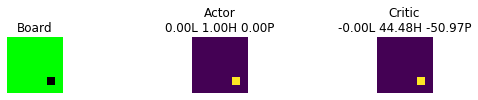

 81%|████████  | 811/1000 [3:55:52<42:41, 13.55s/it]

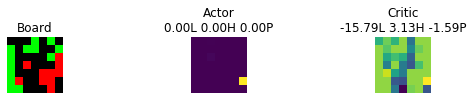

 81%|████████  | 812/1000 [3:56:08<44:36, 14.24s/it]

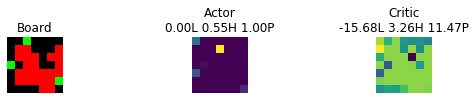

 81%|████████▏ | 813/1000 [3:56:18<40:49, 13.10s/it]

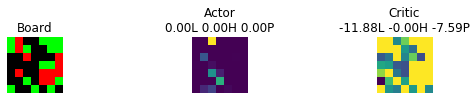

 81%|████████▏ | 814/1000 [3:56:27<36:53, 11.90s/it]

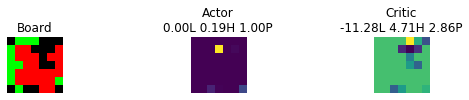

 82%|████████▏ | 815/1000 [3:56:41<38:31, 12.49s/it]

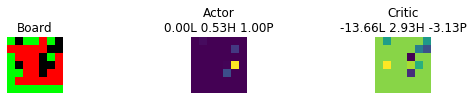

 82%|████████▏ | 816/1000 [3:56:55<39:59, 13.04s/it]

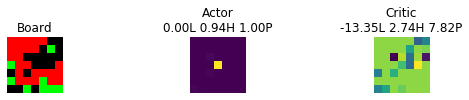

 82%|████████▏ | 817/1000 [3:57:08<39:28, 12.94s/it]

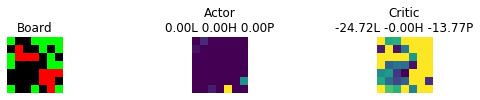

 82%|████████▏ | 818/1000 [3:57:15<34:06, 11.24s/it]

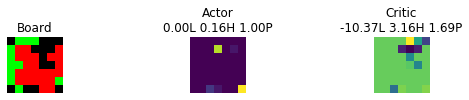

 82%|████████▏ | 819/1000 [3:57:24<31:26, 10.42s/it]

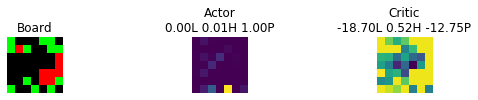

 82%|████████▏ | 820/1000 [3:57:38<34:48, 11.60s/it]

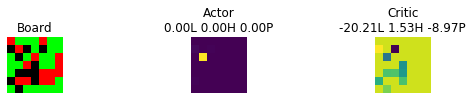

 82%|████████▏ | 821/1000 [3:57:51<36:06, 12.10s/it]

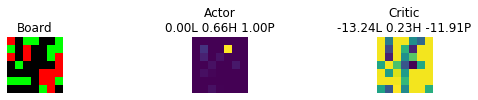

 82%|████████▏ | 822/1000 [3:58:05<36:45, 12.39s/it]

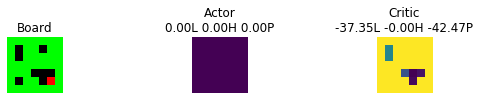

 82%|████████▏ | 823/1000 [3:58:17<36:34, 12.40s/it]

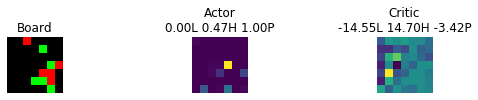

 82%|████████▏ | 824/1000 [3:58:33<39:55, 13.61s/it]

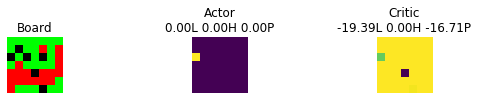

 82%|████████▎ | 825/1000 [3:58:46<39:14, 13.45s/it]

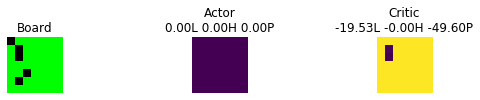

 83%|████████▎ | 826/1000 [3:59:11<48:16, 16.65s/it]

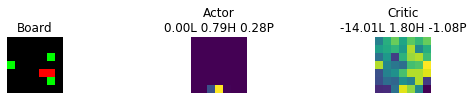

 83%|████████▎ | 827/1000 [3:59:26<47:10, 16.36s/it]

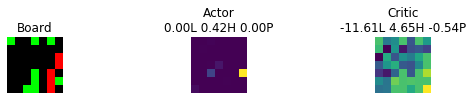

 83%|████████▎ | 828/1000 [3:59:34<39:10, 13.67s/it]

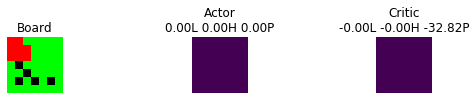

 83%|████████▎ | 829/1000 [3:59:47<38:54, 13.65s/it]

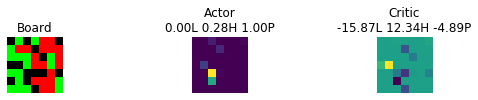

 83%|████████▎ | 830/1000 [3:59:55<33:30, 11.83s/it]

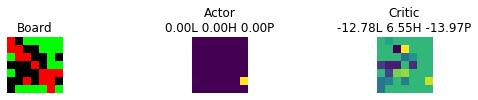

 83%|████████▎ | 831/1000 [4:00:11<36:45, 13.05s/it]

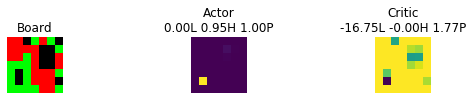

 83%|████████▎ | 832/1000 [4:00:21<34:17, 12.25s/it]

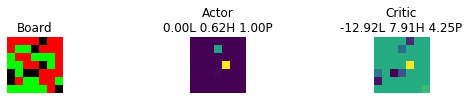

 83%|████████▎ | 833/1000 [4:00:33<34:00, 12.22s/it]

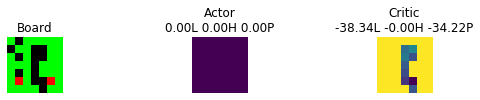

 83%|████████▎ | 834/1000 [4:00:47<35:07, 12.70s/it]

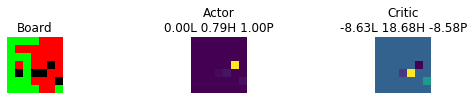

 84%|████████▎ | 835/1000 [4:00:56<32:08, 11.69s/it]

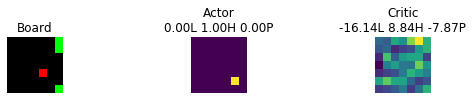

 84%|████████▎ | 836/1000 [4:01:10<33:37, 12.30s/it]

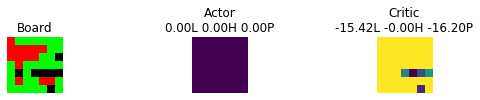

 84%|████████▎ | 837/1000 [4:01:33<41:45, 15.37s/it]

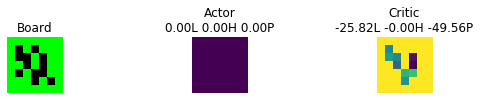

 84%|████████▍ | 838/1000 [4:01:47<40:33, 15.02s/it]

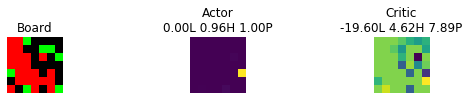

 84%|████████▍ | 839/1000 [4:02:01<39:16, 14.63s/it]

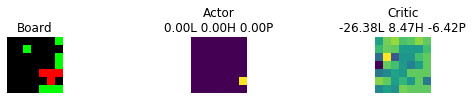

 84%|████████▍ | 840/1000 [4:02:13<37:22, 14.02s/it]

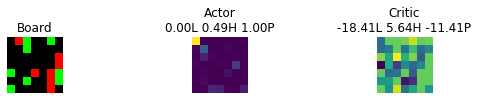

 84%|████████▍ | 841/1000 [4:02:27<37:22, 14.10s/it]

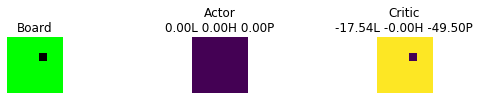

 84%|████████▍ | 842/1000 [4:02:37<33:49, 12.85s/it]

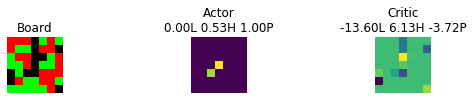

 84%|████████▍ | 843/1000 [4:02:50<33:41, 12.87s/it]

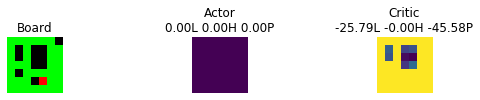

 84%|████████▍ | 844/1000 [4:03:06<35:44, 13.75s/it]

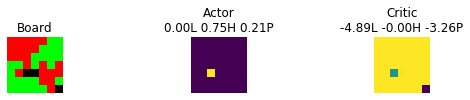

 84%|████████▍ | 845/1000 [4:03:19<35:03, 13.57s/it]

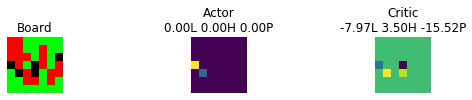

 85%|████████▍ | 846/1000 [4:03:32<33:52, 13.20s/it]

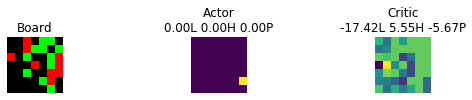

 85%|████████▍ | 847/1000 [4:03:44<33:08, 13.00s/it]

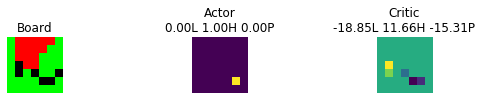

 85%|████████▍ | 848/1000 [4:03:54<30:42, 12.12s/it]

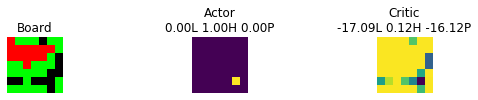

 85%|████████▍ | 849/1000 [4:04:09<32:15, 12.82s/it]

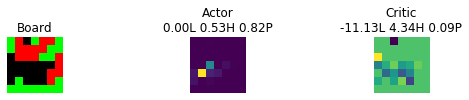

 85%|████████▌ | 850/1000 [4:04:21<31:40, 12.67s/it]

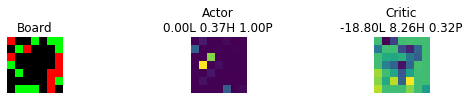

 85%|████████▌ | 851/1000 [4:04:38<34:22, 13.84s/it]

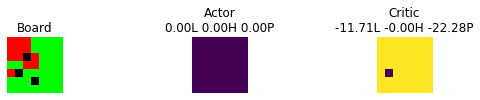

 85%|████████▌ | 852/1000 [4:04:51<33:57, 13.77s/it]

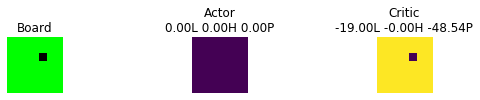

 85%|████████▌ | 853/1000 [4:05:08<35:54, 14.66s/it]

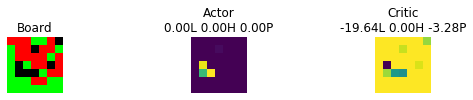

 85%|████████▌ | 854/1000 [4:05:23<35:51, 14.74s/it]

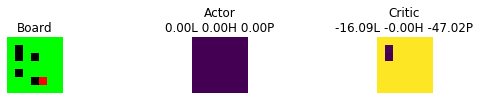

 86%|████████▌ | 855/1000 [4:05:32<31:29, 13.03s/it]

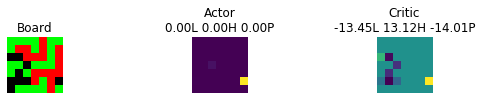

 86%|████████▌ | 856/1000 [4:05:40<28:03, 11.69s/it]

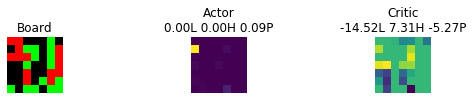

 86%|████████▌ | 857/1000 [4:05:53<28:17, 11.87s/it]

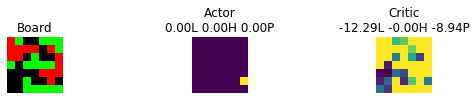

 86%|████████▌ | 858/1000 [4:06:06<29:02, 12.27s/it]

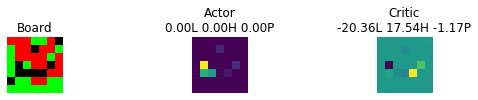

 86%|████████▌ | 859/1000 [4:06:19<29:05, 12.38s/it]

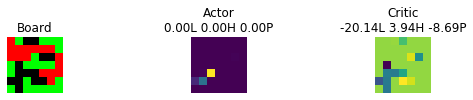

 86%|████████▌ | 860/1000 [4:06:39<34:48, 14.92s/it]

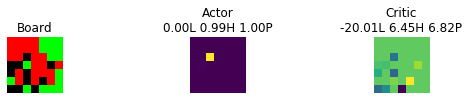

 86%|████████▌ | 861/1000 [4:06:53<33:50, 14.61s/it]

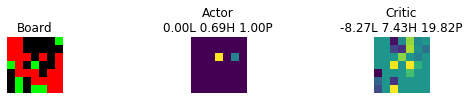

 86%|████████▌ | 862/1000 [4:07:18<40:51, 17.76s/it]

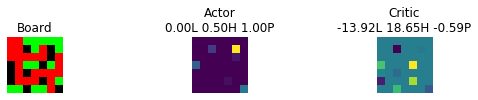

 86%|████████▋ | 863/1000 [4:07:31<36:50, 16.14s/it]

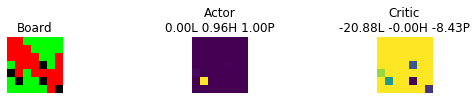

 86%|████████▋ | 864/1000 [4:07:45<35:31, 15.68s/it]

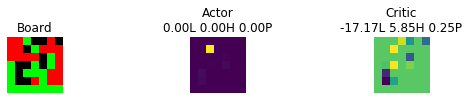

 86%|████████▋ | 865/1000 [4:07:55<30:55, 13.75s/it]

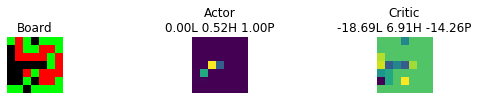

 87%|████████▋ | 866/1000 [4:08:04<27:50, 12.46s/it]

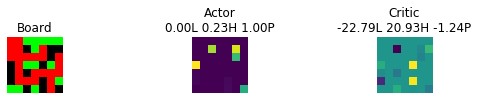

 87%|████████▋ | 867/1000 [4:08:26<34:09, 15.41s/it]

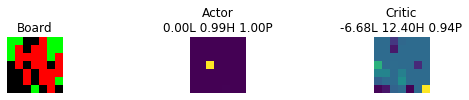

 87%|████████▋ | 868/1000 [4:08:37<30:45, 13.98s/it]

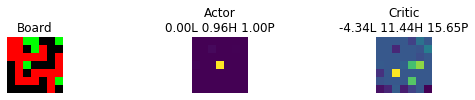

 87%|████████▋ | 869/1000 [4:08:50<29:37, 13.57s/it]

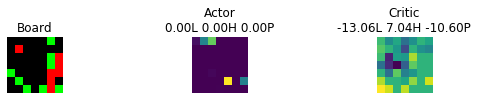

 87%|████████▋ | 870/1000 [4:09:02<28:23, 13.11s/it]

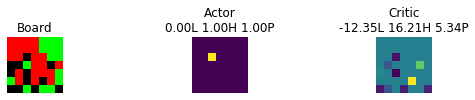

 87%|████████▋ | 871/1000 [4:09:10<24:50, 11.55s/it]

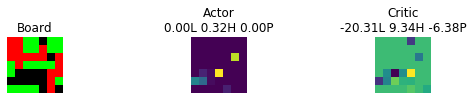

 87%|████████▋ | 872/1000 [4:09:25<26:50, 12.58s/it]

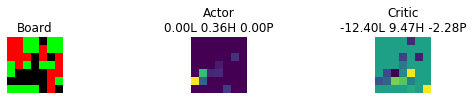

 87%|████████▋ | 873/1000 [4:09:38<27:07, 12.81s/it]

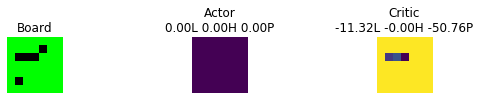

 87%|████████▋ | 874/1000 [4:09:45<23:36, 11.24s/it]

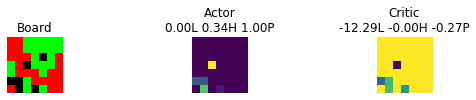

 88%|████████▊ | 875/1000 [4:09:58<24:17, 11.66s/it]

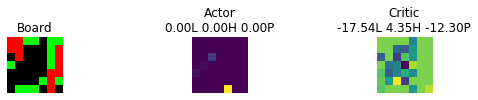

 88%|████████▊ | 876/1000 [4:10:11<24:34, 11.89s/it]

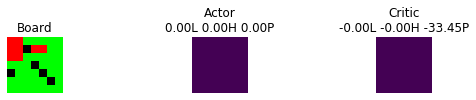

 88%|████████▊ | 877/1000 [4:10:28<27:59, 13.65s/it]

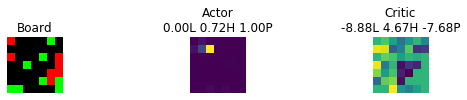

 88%|████████▊ | 878/1000 [4:10:39<25:56, 12.75s/it]

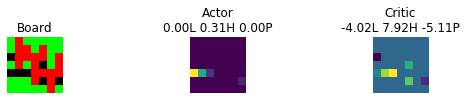

 88%|████████▊ | 879/1000 [4:10:53<26:36, 13.19s/it]

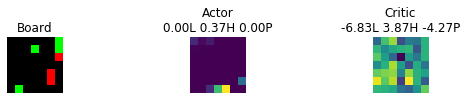

 88%|████████▊ | 880/1000 [4:11:02<23:36, 11.81s/it]

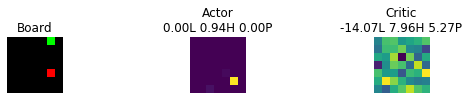

 88%|████████▊ | 881/1000 [4:11:15<24:04, 12.14s/it]

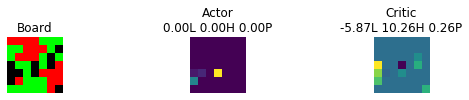

 88%|████████▊ | 882/1000 [4:11:24<22:07, 11.25s/it]

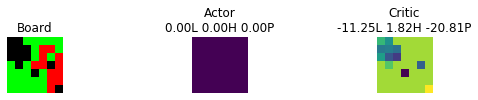

 88%|████████▊ | 883/1000 [4:11:33<20:54, 10.72s/it]

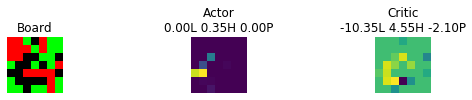

 88%|████████▊ | 884/1000 [4:11:46<21:49, 11.29s/it]

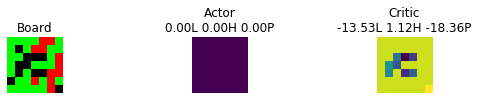

 88%|████████▊ | 885/1000 [4:11:55<20:37, 10.76s/it]

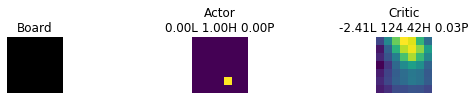

 89%|████████▊ | 886/1000 [4:12:08<21:26, 11.28s/it]

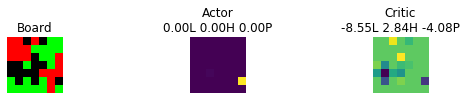

 89%|████████▊ | 887/1000 [4:12:18<20:37, 10.95s/it]

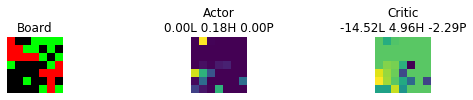

 89%|████████▉ | 888/1000 [4:12:32<22:04, 11.83s/it]

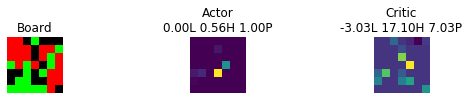

 89%|████████▉ | 889/1000 [4:12:42<20:47, 11.24s/it]

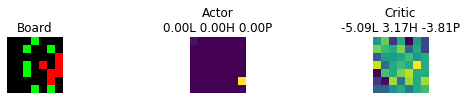

 89%|████████▉ | 890/1000 [4:12:57<22:50, 12.46s/it]

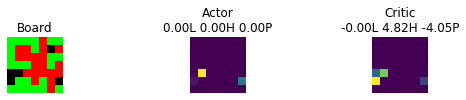

 89%|████████▉ | 891/1000 [4:13:19<27:37, 15.20s/it]

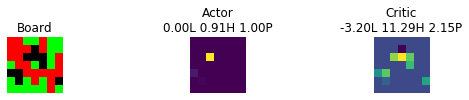

 89%|████████▉ | 892/1000 [4:13:32<26:30, 14.73s/it]

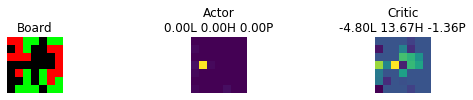

 89%|████████▉ | 893/1000 [4:13:43<23:58, 13.44s/it]

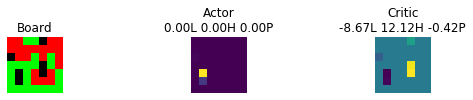

 89%|████████▉ | 894/1000 [4:13:57<23:59, 13.58s/it]

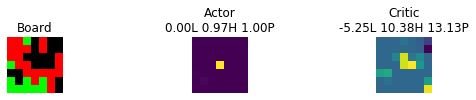

 90%|████████▉ | 895/1000 [4:14:12<24:43, 14.13s/it]

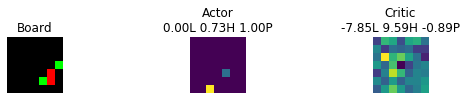

 90%|████████▉ | 896/1000 [4:14:44<33:41, 19.44s/it]

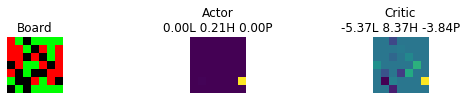

 90%|████████▉ | 897/1000 [4:14:54<28:38, 16.69s/it]

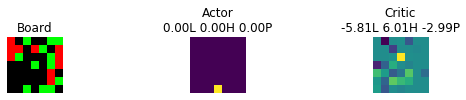

 90%|████████▉ | 898/1000 [4:15:08<26:55, 15.84s/it]

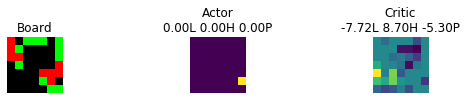

 90%|████████▉ | 899/1000 [4:15:19<24:08, 14.34s/it]

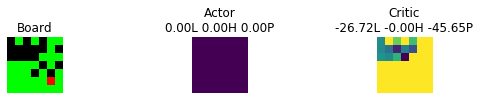

 90%|█████████ | 900/1000 [4:15:30<22:25, 13.45s/it]I0720 21:48:15.182499 4623369664 <ipython-input-34-fc3bfac52b9e>:10] Updated opponent


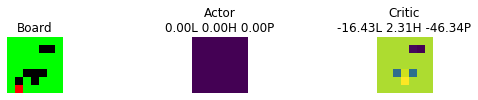

 90%|█████████ | 901/1000 [4:15:44<22:18, 13.52s/it]

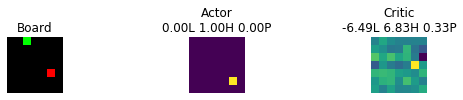

 90%|█████████ | 902/1000 [4:16:13<29:26, 18.03s/it]

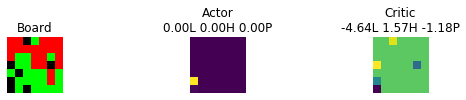

 90%|█████████ | 903/1000 [4:16:31<29:15, 18.10s/it]

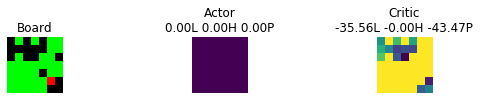

 90%|█████████ | 904/1000 [4:16:45<27:14, 17.02s/it]

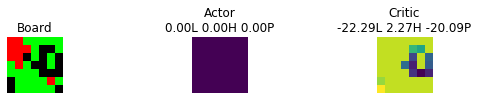

 90%|█████████ | 905/1000 [4:16:58<24:58, 15.78s/it]

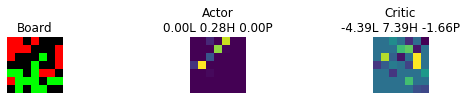

 91%|█████████ | 906/1000 [4:17:11<23:15, 14.84s/it]

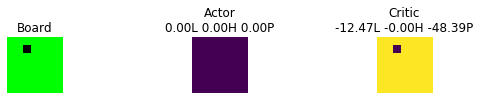

 91%|█████████ | 907/1000 [4:17:19<20:03, 12.94s/it]

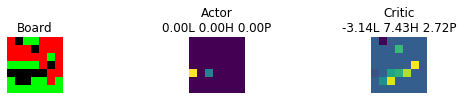

 91%|█████████ | 908/1000 [4:17:33<20:03, 13.09s/it]

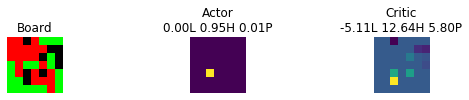

 91%|█████████ | 909/1000 [4:17:40<17:09, 11.31s/it]

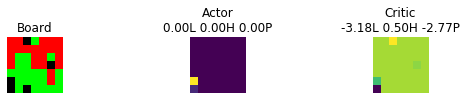

 91%|█████████ | 910/1000 [4:18:10<25:21, 16.90s/it]

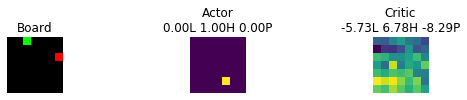

 91%|█████████ | 911/1000 [4:18:39<30:18, 20.43s/it]

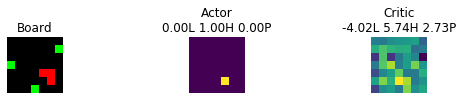

 91%|█████████ | 912/1000 [4:18:52<26:59, 18.41s/it]

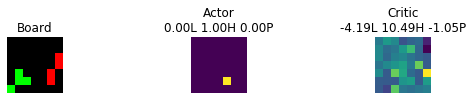

 91%|█████████▏| 913/1000 [4:19:06<24:33, 16.94s/it]

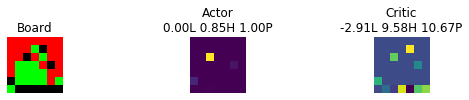

 91%|█████████▏| 914/1000 [4:19:18<22:25, 15.65s/it]

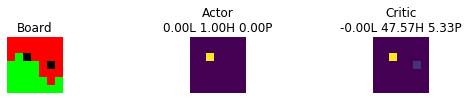

 92%|█████████▏| 915/1000 [4:19:30<20:35, 14.54s/it]

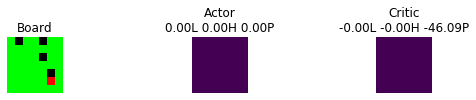

 92%|█████████▏| 916/1000 [4:19:44<19:52, 14.20s/it]

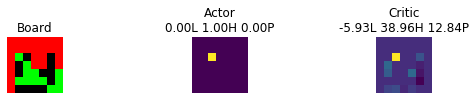

 92%|█████████▏| 917/1000 [4:19:56<18:49, 13.61s/it]

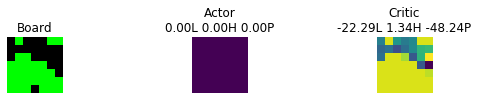

 92%|█████████▏| 918/1000 [4:20:10<18:37, 13.63s/it]

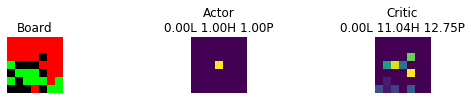

 92%|█████████▏| 919/1000 [4:20:28<20:10, 14.95s/it]

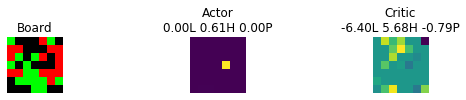

 92%|█████████▏| 920/1000 [4:20:41<19:13, 14.42s/it]

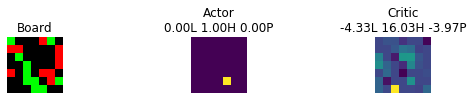

 92%|█████████▏| 921/1000 [4:20:54<18:29, 14.05s/it]

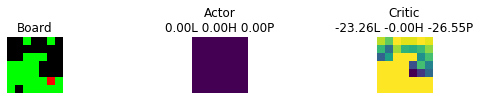

 92%|█████████▏| 922/1000 [4:21:06<17:29, 13.45s/it]

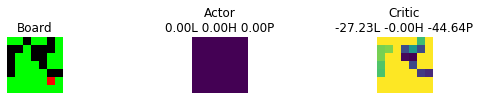

 92%|█████████▏| 923/1000 [4:21:19<16:56, 13.20s/it]

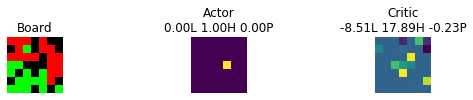

 92%|█████████▏| 924/1000 [4:21:37<18:45, 14.80s/it]

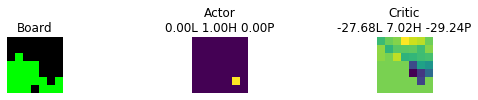

 92%|█████████▎| 925/1000 [4:21:57<20:22, 16.30s/it]

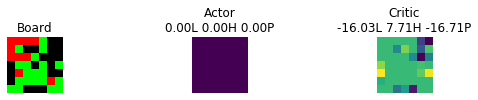

 93%|█████████▎| 926/1000 [4:22:10<18:40, 15.14s/it]

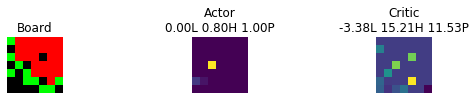

 93%|█████████▎| 927/1000 [4:22:27<19:06, 15.70s/it]

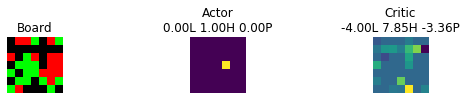

 93%|█████████▎| 928/1000 [4:22:45<19:40, 16.40s/it]

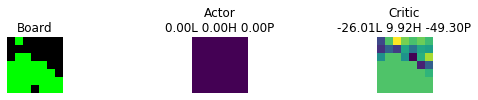

 93%|█████████▎| 929/1000 [4:22:58<18:28, 15.62s/it]

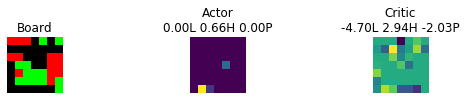

 93%|█████████▎| 930/1000 [4:23:07<15:52, 13.61s/it]

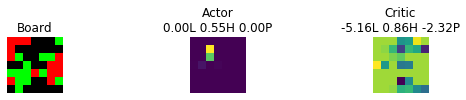

 93%|█████████▎| 931/1000 [4:23:25<17:11, 14.95s/it]

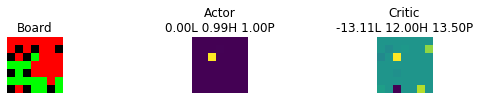

 93%|█████████▎| 932/1000 [4:23:39<16:28, 14.53s/it]

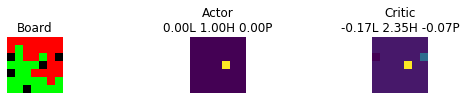

 93%|█████████▎| 933/1000 [4:23:48<14:29, 12.97s/it]

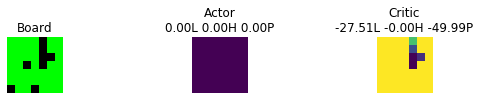

 93%|█████████▎| 934/1000 [4:24:00<14:01, 12.74s/it]

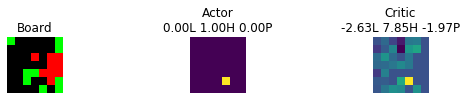

 94%|█████████▎| 935/1000 [4:24:18<15:13, 14.05s/it]

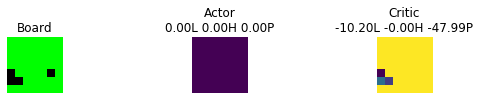

 94%|█████████▎| 936/1000 [4:24:28<13:59, 13.11s/it]

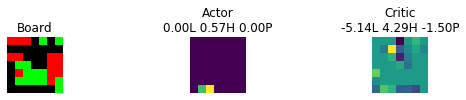

 94%|█████████▎| 937/1000 [4:24:36<12:08, 11.56s/it]

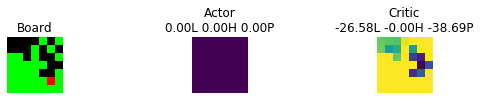

 94%|█████████▍| 938/1000 [4:24:50<12:29, 12.08s/it]

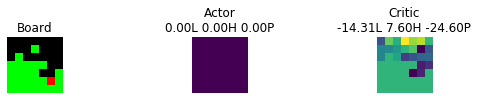

 94%|█████████▍| 939/1000 [4:25:09<14:20, 14.10s/it]

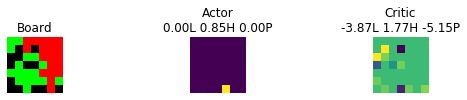

 94%|█████████▍| 940/1000 [4:25:31<16:37, 16.62s/it]

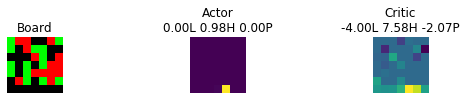

 94%|█████████▍| 941/1000 [4:25:45<15:32, 15.81s/it]

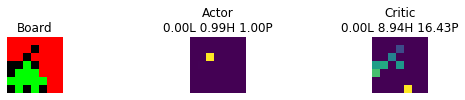

 94%|█████████▍| 942/1000 [4:25:52<12:45, 13.20s/it]

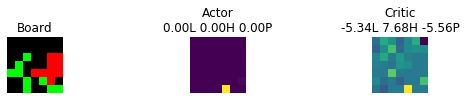

 94%|█████████▍| 943/1000 [4:26:15<15:18, 16.12s/it]

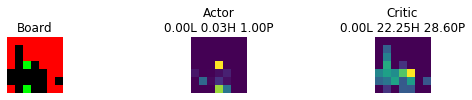

 94%|█████████▍| 944/1000 [4:26:28<14:02, 15.05s/it]

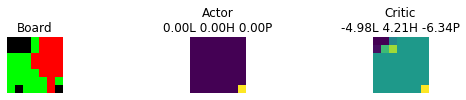

 94%|█████████▍| 945/1000 [4:26:42<13:33, 14.78s/it]

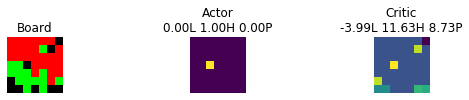

 95%|█████████▍| 946/1000 [4:27:01<14:26, 16.04s/it]

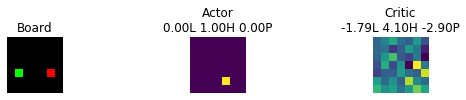

 95%|█████████▍| 947/1000 [4:27:13<13:11, 14.93s/it]

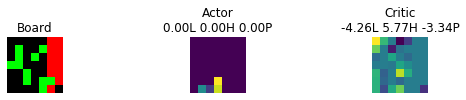

 95%|█████████▍| 948/1000 [4:27:26<12:32, 14.47s/it]

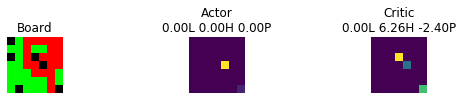

 95%|█████████▍| 949/1000 [4:27:39<11:51, 13.94s/it]

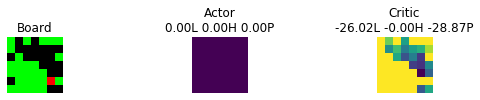

 95%|█████████▌| 950/1000 [4:27:58<12:52, 15.45s/it]

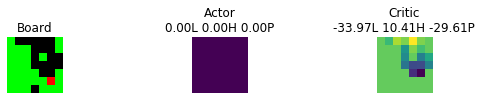

 95%|█████████▌| 951/1000 [4:28:10<11:49, 14.48s/it]

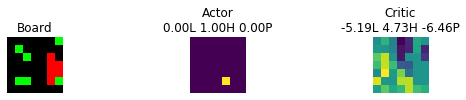

 95%|█████████▌| 952/1000 [4:28:23<11:03, 13.83s/it]

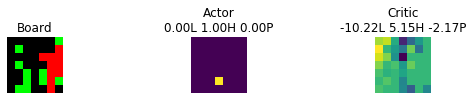

 95%|█████████▌| 953/1000 [4:28:36<10:48, 13.81s/it]

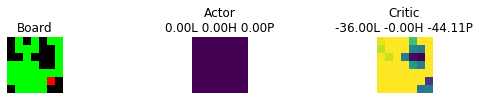

 95%|█████████▌| 954/1000 [4:28:50<10:27, 13.65s/it]

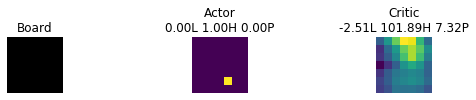

 96%|█████████▌| 955/1000 [4:29:02<09:59, 13.32s/it]

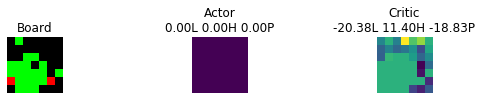

 96%|█████████▌| 956/1000 [4:29:20<10:50, 14.79s/it]

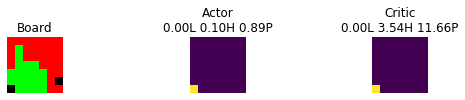

 96%|█████████▌| 957/1000 [4:29:33<10:06, 14.12s/it]

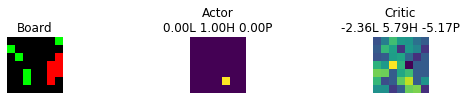

 96%|█████████▌| 958/1000 [4:29:58<12:07, 17.32s/it]

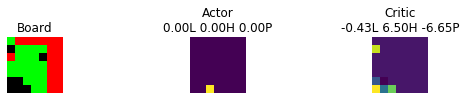

 96%|█████████▌| 959/1000 [4:30:12<11:14, 16.45s/it]

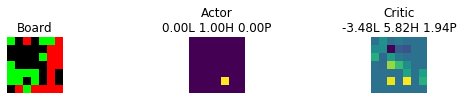

 96%|█████████▌| 960/1000 [4:30:26<10:21, 15.55s/it]

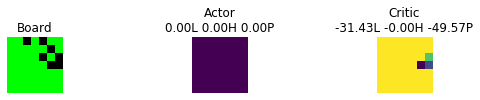

 96%|█████████▌| 961/1000 [4:30:38<09:29, 14.61s/it]

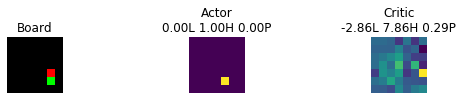

 96%|█████████▌| 962/1000 [4:30:51<08:56, 14.12s/it]

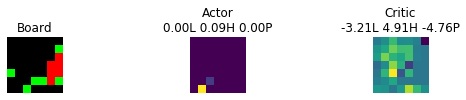

 96%|█████████▋| 963/1000 [4:31:04<08:26, 13.69s/it]

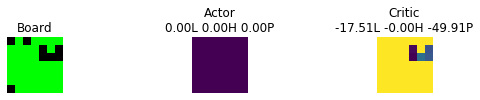

 96%|█████████▋| 964/1000 [4:31:32<10:54, 18.19s/it]

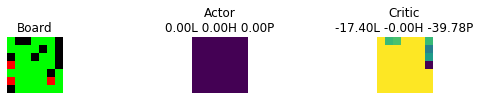

 96%|█████████▋| 965/1000 [4:31:46<09:46, 16.76s/it]

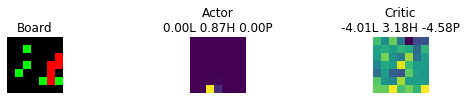

 97%|█████████▋| 966/1000 [4:31:59<08:52, 15.67s/it]

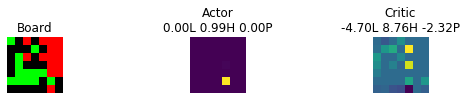

 97%|█████████▋| 967/1000 [4:32:18<09:15, 16.82s/it]

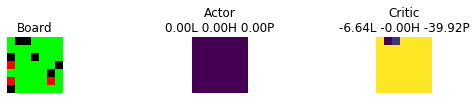

 97%|█████████▋| 968/1000 [4:32:37<09:16, 17.39s/it]

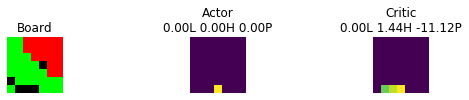

 97%|█████████▋| 969/1000 [4:32:50<08:13, 15.91s/it]

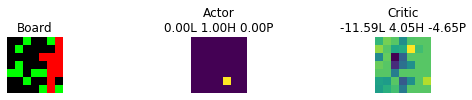

 97%|█████████▋| 970/1000 [4:33:03<07:31, 15.05s/it]

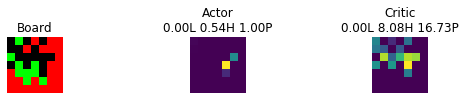

 97%|█████████▋| 971/1000 [4:33:21<07:44, 16.01s/it]

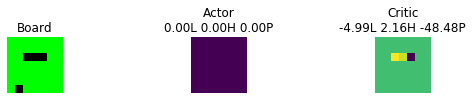

 97%|█████████▋| 972/1000 [4:33:34<07:05, 15.18s/it]

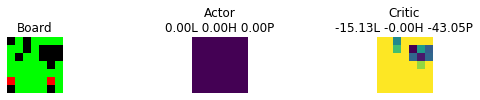

 97%|█████████▋| 973/1000 [4:33:54<07:29, 16.64s/it]

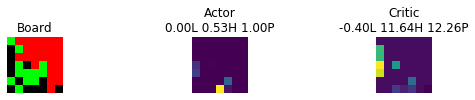

 97%|█████████▋| 974/1000 [4:34:08<06:50, 15.77s/it]

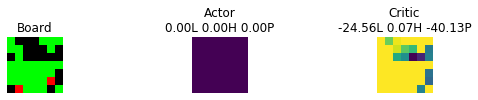

 98%|█████████▊| 975/1000 [4:34:21<06:12, 14.89s/it]

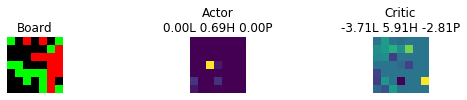

 98%|█████████▊| 976/1000 [4:34:44<06:59, 17.49s/it]

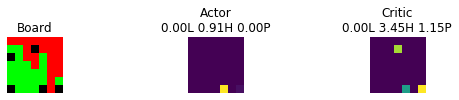

 98%|█████████▊| 977/1000 [4:34:58<06:13, 16.23s/it]

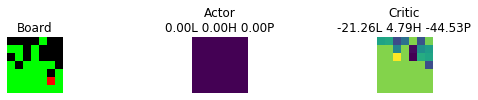

 98%|█████████▊| 978/1000 [4:35:11<05:38, 15.38s/it]

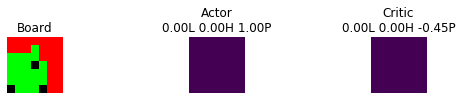

 98%|█████████▊| 979/1000 [4:35:23<05:04, 14.49s/it]

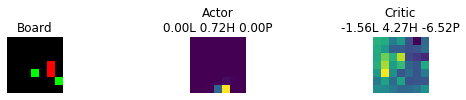

 98%|█████████▊| 980/1000 [4:35:37<04:44, 14.24s/it]

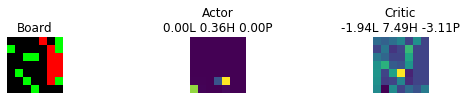

 98%|█████████▊| 981/1000 [4:35:50<04:21, 13.76s/it]

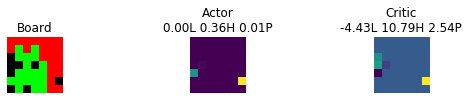

 98%|█████████▊| 982/1000 [4:36:03<04:07, 13.75s/it]

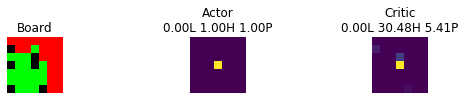

 98%|█████████▊| 983/1000 [4:36:17<03:52, 13.65s/it]

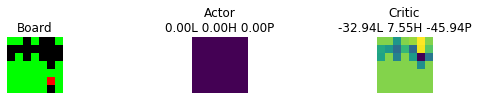

 98%|█████████▊| 984/1000 [4:36:36<04:02, 15.15s/it]

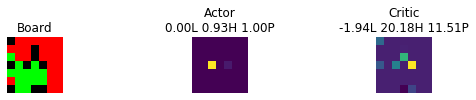

 98%|█████████▊| 985/1000 [4:36:48<03:34, 14.33s/it]

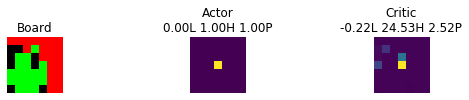

 99%|█████████▊| 986/1000 [4:37:01<03:16, 14.03s/it]

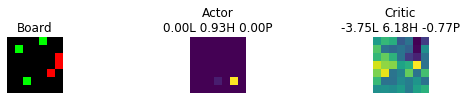

 99%|█████████▊| 987/1000 [4:37:15<03:00, 13.85s/it]

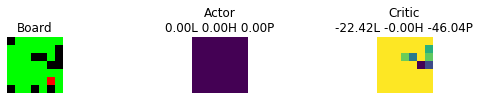

 99%|█████████▉| 988/1000 [4:37:27<02:40, 13.38s/it]

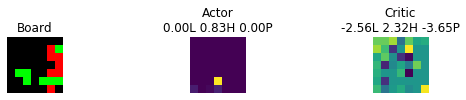

 99%|█████████▉| 989/1000 [4:37:41<02:28, 13.50s/it]

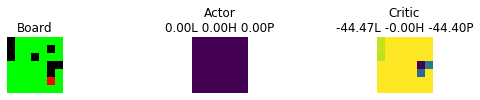

 99%|█████████▉| 990/1000 [4:37:54<02:13, 13.30s/it]

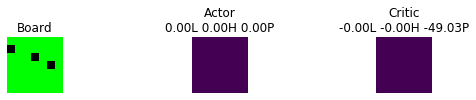

 99%|█████████▉| 991/1000 [4:38:06<01:57, 13.10s/it]

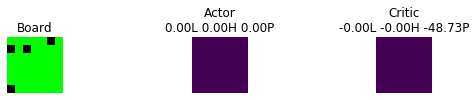

 99%|█████████▉| 992/1000 [4:38:25<01:58, 14.81s/it]

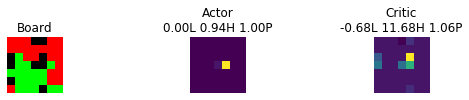

 99%|█████████▉| 993/1000 [4:38:38<01:38, 14.10s/it]

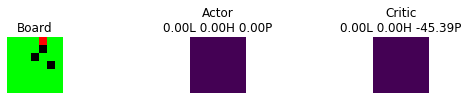

 99%|█████████▉| 994/1000 [4:39:14<02:04, 20.75s/it]

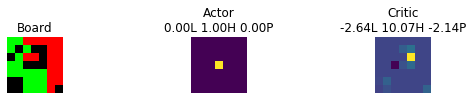

100%|█████████▉| 995/1000 [4:39:28<01:33, 18.73s/it]

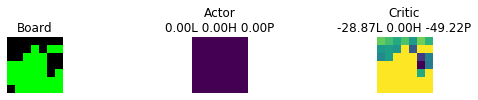

100%|█████████▉| 996/1000 [4:39:41<01:07, 16.93s/it]

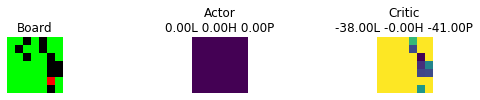

100%|█████████▉| 997/1000 [4:39:54<00:47, 15.98s/it]

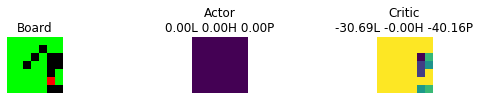

100%|█████████▉| 998/1000 [4:40:07<00:30, 15.12s/it]

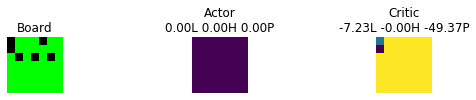

100%|█████████▉| 999/1000 [4:40:20<00:14, 14.38s/it]

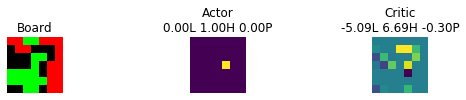

100%|██████████| 1000/1000 [4:40:39<00:00, 15.80s/it]


In [34]:
for episode in tqdm(range(NUM_EPISODES)):
    # Reset all metrics
    for metric in actor_metrics.values():
        metric.reset_states()
    for metric in critic_metrics.values():
        metric.reset_states()
    
    if episode % OPPONENT_UPDATE == 0:
        opponent = tf.keras.models.clone_model(actor)
        logging.info("Updated opponent")
        
    if episode % TARGET_UPDATE == 0:
        target_critic = tf.keras.models.clone_model(critic)

    num_turns, rewards = train(episode)
    
    # Plot samples of states and actor, critic heatmaps
    num_samples = 1
    states, _, _, _,_ = get_batch_obs(num_samples)
    board_prob_distrs, pass_probs = actor([states, 1-states[:,:,:,2]])
    board_val_distrs, pass_vals = critic([states, 1-states[:,:,:,2]])
    plt.figure(figsize=(8,1.5))
    for i in range(num_samples):
        plt.subplot(num_samples,3,3*i+1+0)
        plt.axis('off')
        plt.title('Board')
        plt.imshow(states[i][:,:,[0,1,3]].astype(np.float))
        plt.subplot(num_samples,3,3*i+1+1)
        plt.axis('off')
        plt.title('Actor\n{:.2f}L {:.2f}H {:.2f}P'
                  .format(np.min(board_prob_distrs), 
                          np.max(board_prob_distrs),pass_probs[i][0]))
        plt.imshow(board_prob_distrs[i])
        plt.subplot(num_samples,3,3*i+1+2)
        plt.axis('off')
        plt.title('Critic\n{:.2f}L {:.2f}H {:.2f}P'
                  .format(np.min(board_val_distrs), 
                          np.max(board_val_distrs), pass_vals[i][0]))
        plt.imshow(board_val_distrs[i])
        
    plt.tight_layout()
    plt.show()
    
    # log results
    with summary_writers['main'].as_default():
        tf.summary.scalar('last rewards', rewards[-1], step=episode)
        tf.summary.scalar('rewards sum', sum(rewards), step=episode)
        tf.summary.scalar('number of moves', num_turns, step=episode)
        tf.summary.scalar('critic loss', critic_metrics['loss'].result(), step=episode)
        tf.summary.scalar('actor loss', actor_metrics['loss'].result(), step=episode)
        tf.summary.scalar('epsilon', EPSILON, step=episode)
        

In [35]:
actor.save_weights('tmp/actor.h5')
critic.save_weights('tmp/critic.h5')

# Evaluate

Test against a pretrained AI

In [36]:
# TODO

Play against our AI

In [37]:
go_env = gym.make('gym_go:go-v0', size='S')

state = go_env.reset()

done = False
while not done:
    go_env.render()
    
    # Actor's move
    action = get_action(actor, state, 0)
    
    state, reward, done, info = go_env.step(action)
    
    go_env.render()
    
    # Player's move
    player_moved = False
    while not player_moved:
        coords = input("Enter coordinates separated by space (`q` to quit)\n")
        if coords == 'q':
            done = True
            break
        coords = coords.split()
        try:
            row = int(coords[0])
            col = int(coords[1])
            print(row, col)
            state, reward, done, info = go_env.step((row, col))
            player_moved = True
        except Exception as e:
            print(e)

    0   1   2   3   4   5   6
  -----------------------------
0 |   |   |   |   |   |   |   |
  -----------------------------
1 |   |   |   |   |   |   |   |
  -----------------------------
2 |   |   |   |   |   |   |   |
  -----------------------------
3 |   |   |   |   |   |   |   |
  -----------------------------
4 |   |   |   |   |   |   |   |
  -----------------------------
5 |   |   |   |   |   |   |   |
  -----------------------------
6 |   |   |   |   |   |   |   |
  -----------------------------

    0   1   2   3   4   5   6
  -----------------------------
0 |   |   |   |   |   |   |   |
  -----------------------------
1 |   |   |   |   |   |   |   |
  -----------------------------
2 |   |   |   |   |   |   |   |
  -----------------------------
3 |   |   |   |   |   |   |   |
  -----------------------------
4 |   |   |   |   |   |   |   |
  -----------------------------
5 |   |   |   |   | B |   |   |
  -----------------------------
6 |   |   |   |   |   |   |   |
  ---------